<font color="#9944FF">#9944FF: Questions</font><br />
<font color="#33AA00">#33AA00: Answers</font><br />
<font color="#0077FF">#0077FF: Meta-comments to self</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline
np.set_printoptions(suppress=True)

#data = np.loadtxt('x_sl.dat', skiprows=1)

In [32]:
def jd_to_date(jd):    
    '''
    Converts Julian date to Gregorian date.
    From Astronomical Algorithms, Jean Meeus, 1991.
    '''
    import math

    j = jd + 0.5
    z = math.trunc(j)
    f = j - z

    if z < 2299161:
        A = z
    else:
        alpha = int((z - 1867216.25)/36524.25)
        A = z + 1 + alpha - int(alpha/4)

    B = A + 1524
    C = int((B - 122.1)/365.25)
    D = int(365.25 * C)
    E = int((B - D)/30.6001)

    day = B - D - int(30.6001 * E)
    month = E - 1 if E < 14 else E - 13
    year = C - 4716 if month > 2 else C - 4715

    # added by me to calculate hours, minutes, seconds.
    h = int(f * 24)
    m = int((f * 24 - int(h)) * 60)
    s = int((((f * 24 - int(h)) * 60) - m) * 60)

    return year, month, day, h, m, s

def date_to_jd(date, time):    
    '''
    Converts Gregorian date to Julian date given the format:
    date = YYYY-MM-DD, time = HH:MM:SS
    From Astronomical Algorithms, Jean Meeus, 1991.
    '''
    
    x = time.split(':')
    x = [int(xi) for xi in x]
    s = x[2]
    mi = x[1]
    h = x[0]
    f = h/24 + mi/(60*24) + s/3600
    
    sign = 1
    if date[0] == '-':
        date = date[1:]
        sign = -1
    x = date.split('-')
    x = [int(xi) for xi in x]
    d = x[2]
    mo = x[1]
    y = sign * x[0]
    
    earlyOct1582 = (y==1582 and mo<=10 and d < 15)
    early1582 = (y==1582 and mo<= 9)
    anytimeBefore = (y < 1582)
    
    if earlyOct1582 or early1582 or anytimeBefore:
        flag = 'J'
    else: 
        flag = 'G'

    if mo == 1 or mo == 2:
        y = y - 1
        mo = mo + 12
    
    A = int(y / 100)
    B = 2 - A + int(A / 4) if flag=='G' else 0

    jd = int(365.25 * (y + 4716)) + int(30.6001 * (mo + 1)) + d + B - 1524.5 + f
    
    jd = float('{:.4f}'.format(jd))
    return jd

def get_moon_phase(now):
    '''
    Calculate moon phase for a given Julian date.(cf. Chapman & Linzen)
    ---INPUT---
        now: a Julian date, including hours, minutes, seconds.
    ---OUTPUT---
        nuHrs: Phase of the moon in hours
    '''
    from math import pi
    
    ref = date_to_jd('1899-12-31', '12:00:00')
    T = (now - ref) / 36525
    nu = -9.26009 + 445267.12165*T + 0.00168*(T**2)
    ageDeg = nu % 360
    nuRad = ageDeg * pi / 180
    nuHrs = (nu/15) % 24
    return nuHrs

def generate_tides(startDate, endDate, amps, phase, dt=1, longIncr=15, 
                   nRange=range(1,3), sRange=range(-6,7), filename='tides.txt',
                   component='solar'):
    '''
    Generates tidal data using the equation:
    A + ΣΣS_{ns}*cos[Ωnt + sλ - Φ_{ns}] + ΣΣL_{ns}*cos[Ωnt + sλ - Φ_{ns}]
    for specified amplitudes and phases. 
    This function is altitude and latitude independent (***???)
    where 
        A = amplitude
        n = 2nd harmonic (semidiurnal variation)
        s = zonal wavenumber (maxes and mins along a line of longitude)
            s = 2 => migrating tide
            s = 3 => non-migrating tide
        t = universal time at Greenwich Meridian
        λ = longitude
        Φ = phase
    --INPUT--
        startDate       a start date, format '2016-06-21'
        endDate         an end date, format '2016-06-30'
        amps            List of amplitude values (length = 3).
        phase           info about whether to vary phase or keep it cosntant
        nRange          values of n to use in calculation
        sRange          values of s to use in calculation
        filename        filename to write values to
        component       solar, lunar, s+l (solar+lunar) or all; specifies 
                        summation bounds for n and s
    --OUTUT--
        Tidal data in array of format:
        Solar local time - Lunar local time - Longitude - Solar Julian date - 
        Lunar Julian date - Hour of day - Moon phase in hours - Tidal value
        
    Adapted from script by Dr. Ruth Lieberman by Eryn Cangi for LASP REU 2016.
    '''
    from math import pi, cos
    
    # VARIABLES --------------------------------------------------------------
    A = amps[0]                    # Background amplitude
    S = amps[1]                    # Solar amplitude
    L = amps[2]                    # Lunar amplitude
    if phase=='C':                 # Phases (Φ_{n,s})
        phi = 0
    else:
        phi = lambda t: cos(t + pi/2)
    hoursPerDay = 24 
     
    # DEFINE LONGITUDE GRID --------------------------------------------------
    numLongs = 360 // longIncr
    longs = np.asarray([l*pi/180 for l in list(range(-180, 180, longIncr))])
    W = 2*pi/24                   # Earth rotation rate (omega)
    
    # GET JULIAN DATES -------------------------------------------------------
    ti = date_to_jd(startDate, '00:00:00')
    tf = date_to_jd(endDate, '00:00:00')
    numDays = int(tf - ti) + 1 # +1 to include the last day in the loops
    
    # MAKE OUTPUT ARRAY ------------------------------------------------------
    rows = numLongs * 24/dt * numDays
    output = np.empty([rows,7])
    r = 0
    
    # LOOP THROUGH TIMESPAN (DAYS) ===========================================
    for day in range(numDays):    # + makes inclusive: calculates for last day
        curJulDate = ti + day
        
        # GET REGULAR DATE FOR CALCULATIONS ----------------------------------
        yr, mo, d, h, minute, sec = jd_to_date(curJulDate) 
        curRegDate = '{}-{:>02}-{:>02}'.format(yr, mo, d)
        curRegHour = h
        
        # LOOP THROUGH HOURS IN DAY ==========================================
        for hr in np.arange(hoursPerDay):
            for f in np.arange(0,1,dt):

                # UPDATE HOUR, GET NEW JULIAN DATE -------------------------------
                curRegHour = 0 + hr
                curRegMin = int(f * 60)
                fracHr = curRegHour + f
                curRegTime = '{:>02}:{:>02}:{:>02}'.format(curRegHour, curRegMin, sec)
                newJD = date_to_jd(curRegDate, curRegTime)

                # GET MOON PHASE AT THIS HOUR ------------------------------------
                nuHrs = get_moon_phase(newJD)

                # LOOP OVER LONGITUDES ===========================================
                for l in longs:
                    # CALCULATE SOLAR LOCAL TIME ---------------------------------
                    slt = fracHr + l/W
                    if slt < 0:            # Wrap around behavior, Earth = sphere
                        slt = slt + 24
                    elif slt > 24:
                        slt = slt - 24
                    else:
                        pass

                    # CALCULATE LUNAR LOCAL TIME ---------------------------------
                    llt = slt - nuHrs
                    llt = llt + 24 if llt < 0 else llt

                    # CALCULATE THE TIDES ----------------------------------------

                    # Assign amplitudes
                    # Background
                    if type(A)==int:
                        tide = A
                    else:
                        tide = A(hr,l)

                    # Solar
                    if type(S)==int:
                        A_S = S
                    else:
                        A_S = S(hr,l)

                    # Lunar
                    if type(L)==int:
                        A_L = L
                    else:
                        A_L = L(hr,l)

                    # Assign phase 
                    if type(phi)==int:
                        p = phi
                    else:
                        p = phi(hr)

                    for n in nRange:
                        for s in sRange:
                            if component=='solar':     # solar contribution
                                # DO NOT CHANGE-----------------------------------
                                tide += A_S * cos((2*pi*n/24)*fracHr + s*l - p)
                                #-------------------------------------------------
                            elif component=='lunar':   # lunar contribution
                                tide += A_L * cos((2*pi*n/24)*(fracHr-nuHrs) + s*l - p)

                            elif component=='s+l':
                                tide += A_S*cos((2*pi*n/24)*fracHr + s*l - p) \
                                      + A_L*cos((2*pi*n/24)*(fracHr-nuHrs) + s*l - p)
                    output[r,0] = slt
                    output[r,1] = llt
                    output[r,2] = round(l * 180/pi)
                    output[r,3] = newJD
                    output[r,4] = fracHr
                    output[r,5] = nuHrs
                    output[r,6] = tide
                    r += 1

    # FORMAT HEADER LINE, WRITE FILE -----------------------------------------
    cells = '{:^20}'*7            
    line0 = cells.format('Solar local time', 'Lunar local time', 'Longitude', 
                        'Julian Date', 'UT', 'Moon phase (hrs)', 'Tide')
    np.savetxt(filename, output, fmt='%.4f', delimiter='\t', header=line0)
    
    return output

def bin_by_solar(data):
    '''
    Finds the mean of the solar contribution at a given solar local time.
    Writes a file of means for each pair of a unique solar local time and
    longitude.
    ---INPUT---
        data        Array of tidal data
    ---OUTPUT---
        means       3-column array, columns: solar local time, longitude,
                    mean solar contribution.
    '''

    means = []

    # FIND UNIQUE SOLAR LOCAL TIMES ------------------------------------------
    slt = np.ndarray.tolist(data[:,0])
    unique_slt = set([round(x,4) for x in slt])

    # ITERATE OVER SOLAR LOCAL TIMES & LONGITUDES ----------------------------
    for val in unique_slt:
        for lon in range(-180, 190, 15):
            sltSlice = data[np.where(data[:,0] == val)]
            sltSlice = sltSlice[np.where(sltSlice[:,2]==lon)]
            if sltSlice.size != 0:
                means.append([val, lon, np.mean(sltSlice[:,6])])
                
    means = np.asarray(means)
        
    line0 = 'Solar Local Time\tLongitude\tMean Solar Tide\n'
    np.savetxt('slt_bin.txt', output, delimiter='\t', header=line0)

    return means

def plot_vs_long(data, date, time, flag, title, c):
    '''
    Plots tidal value versus longitude for a specified Julian date
    ---INPUT---
        data        Array of tidal data
        date        date in format YYYY-MM-DD
        time        time in format HH:MM:SS
        flag        'save' or 'show', controls how the plot is handled.
        title       descriptive plot title
        c           plot line color. Just for aesthetics.
    ---OUTPUT---
        A plot
    '''
    
    
    JDdate = date_to_jd(date, time)

    # FIND ROWS IN DATA ARRAY WITH MATCHING DATE -----------------------------
    # Because data for a particular Julian date is all grouped together, the 
    # values in rows[0] (the indices) will be consecutive.
    rows = np.where(data[:,3]==JDdate)[0]
    i = rows[0]
    f = rows[-1]
    longs = data[i:f,2]
    tides = data[i:f,6]
    
    # PLOT -------------------------------------------------------------------
    plt.figure(figsize=(10,8))
    plt.plot(longs, tides, color=c, marker=r'$\bigodot$', markersize=12)
    plt.title('{}, {} at {}'.format(title, date, time))
    plt.xlabel('Longitude')
    plt.ylabel('Tide amplitude') # what actually is the units of this?
    plt.rcParams.update({'font.size': 16})
    
    if flag=='show':
        plt.show()
        plt.close()
    elif flag=='save':
        fn = 'tides_d{}_{:>02}.png'
        plt.savefig(fn.format(date, time.split(':')[0]), bbox_inches='tight')
        plt.clf()
        plt.close()
    
    
    
    
    
def plot_vs_date(data, long, title, data2=None, c=None, m=None, lb=None, 
                 mode='show'):
    '''
    Plots tidal values over time at a particular longitude.
    ---INPUT---
        data        Array of tidal data
        long        Longitude to examine
        title       descriptive plot title
        data2       Optional second data to plot if stacking two tides
        c           color list, has two elements if stacking.
        m           marker shape to use
        lb          Plot legend elements
        mode        Whether to save or show the figure. Default 'show'
    ---OUTPUT---
        A plot
    '''
    
    if data2 != None:
        stack = True
    else: 
        stack = False
        
    # FIND ROWS IN ARRAY WITH MATCHING LONGITUDE -----------------------------
    rows = np.where(data[:,2]==long)[0]
    times = [data[i, 3] for i in rows]
    tides = [data[i, 6] for i in rows]
    
    if stack:
        tides2 = [data2[i,6] for i in rows]
    

    # PLOT -------------------------------------------------------------------
    plt.figure(figsize=(25,6))
    s = len(times)                           # set a limit for plotting
    
    if stack:
        plt.plot(times[:s], tides[:s], color=c[0], marker=m, label=lb[0])
        plt.plot(times[:s], tides2[:s], color=c[1], marker=m, label=lb[1])
        plt.legend(loc='lower right')
    else:
        plt.plot(times, tides, marker=m)
    plt.title('{} by Julian date at {}° Longitude'.format(title, long))
    plt.xlim([min(times),max(times)])
    plt.xlabel('Julian date')
    plt.ylabel('Tide amplitude') # what actually is the units of this?
    plt.rcParams.update({'font.size': 16})
    
    if mode=='show':
        plt.show()
        plt.close()
    elif mode=='save':
        fn = '{} by Julian date at {}° Longitude'.format(title, long)
        plt.savefig(fn, bbox_inches='tight')
        plt.close()
    elif mode=='both':
        fn = '{} by Julian date at {}° Longitude'.format(title, long)
        plt.savefig(fn, bbox_inches='tight')
        plt.show()
        plt.clf()
        plt.close()

def plot_vs_slt(data, time):
    '''
    Plots tidal value versus solar local time
    ---INPUT---
        data        Array of tidal data
        time        time in format HH:MM:SS
    ---OUTPUT---
        A plot
    '''
    
    # FORMAT SLT -------------------------------------------------------------
    time_els = time.split(':')
    time_els = [float(s) for s in time_els]
    time = time_els[0] + time_els[1] / 60 + time_els[2] / 3600

    # CHECK FOR BADLY FORMATTED DECIMALS -------------------------------------
    if time % time_els[0] not in [0, 0.3333, 0.6667]:
        raise Exception('Bad time given')

    # FIND MATCHING SOLAR LOCAL TIMES IN DATA --------------------------------           
    rows = np.where(data[:,0]==time)[0]
    longs = [data[i,2] for i in rows]
    tides = [data[i,6] for i in rows]
    
    # PLOT--------------------------------------------------------------------
    plt.figure(figsize=(10,8))
    plt.scatter(longs,tides, marker='x')
    plt.title('Longitudes vs tides at solar local time {}'.format(time))
    plt.xlabel('Longitude')
    plt.ylabel('Tide value') # what actually is the units of this?
    plt.rcParams.update({'font.size': 16})
    plt.show()
    
def bin_by_solar(data, filename):
    '''
    Finds the mean of the solar contribution at a given solar local time.
    Writes a file of means for each pair of a unique solar local time and
    longitude.
    ---INPUT---
        data        Array of tidal data
        filename    Name for output file
    ---OUTPUT---
        means       3-column array, columns: solar local time, longitude,
                    mean solar contribution.
    '''

    means = []

    # FIND UNIQUE SOLAR LOCAL TIMES ------------------------------------------
    slt = np.ndarray.tolist(data[:,0])
    unique_slt = set([round(x,4) for x in slt])

    # ITERATE OVER SOLAR LOCAL TIMES & LONGITUDES ----------------------------
    for val in unique_slt:
        for lon in range(-180, 190, 15):
            sltSlice = data[np.where(data[:,0] == val)]
            sltSlice = sltSlice[np.where(sltSlice[:,2]==lon)]
            if sltSlice.size != 0:
                means.append([val, lon, np.mean(sltSlice[:,6])])
                
    means = np.asarray(means)
        
    line0 = 'Solar Local Time\tLongitude\tMean Solar Tide'
    np.savetxt('{}_slt_bin.txt'.format(filename), means, fmt='%.4f', delimiter='\t', 
               header=line0)

    return means
    

def remove_solar(c, binfile): 
    '''
    Subtract off the solar tidal averages. Iterates through the file holding 
    solar tidal average data per solar local time and longitude.
    --INPUT--
        c           Data table where columns are solar local time, lunar local time, 
                    longitude, lunar Julian date, hour, moon phase and total tidal 
                    value.
        binfile     Name of a file from which to read binned solar data
    --OUTPUT--
        result      Array holding original data for columns 0-5 and the 
                    "reconstructed" lunar tidal values in column 6
    '''
    
    # create new array to store subtracted values
    r = np.zeros([c.shape[0]])

    # For each file line, find row in c array where solar local time and 
    # longitude for each match. Then subtract the solar tidal data, given in 
    # the file, from combined tidal data in c and store in r
    with open(binfile, 'r') as sbin:
        head = next(sbin)              # takes care of header line
        for line in sbin:
            l = line.split()
            slt = float(l[0])
            lon = float(l[1])
            # find rows in c that match this line's values
            i = np.where((c[:,0]==slt) & (c[:,2]==lon))[0]
            r[i] = c[i,6] - float(l[2])
            
    # Create copy of original data array, replace tidal data with r
    copy = np.array(c)
    copy = np.delete(copy, 6, 1)
    result = np.column_stack((copy, r))
            
    return result

def compare_with_plot(recon, original):
    '''
    Compare reconstructed data with original data over a small window to get 
    a sense of how well it matches.
    ---INPUT---
        recon: lunar tidal data versus some variable (doesn't matter)
        original: data that was fed into the synthetic model
    ---OUTPUT---
        a plot of the two overlaid
    '''

    x = np.arange(0, recon.shape[0])
    i = 477
    s = 350

    plt.figure(figsize=(18,6))
    plt.title('reconstructed lunar tides vs original data')
    plt.plot(x[i:i+s], original[i:i+s], color='blue', label='original lunar tide data')
    plt.plot(x[i:i+s], recon[i:i+s], color='red', label='reconstructed lunar tides')
    plt.xlabel('whatever')
    plt.ylabel('Value')
    plt.legend(loc='upper right')
    plt.rcParams.update({'font.size': 14})
    plt.show()
    
def bin_by_lunar(data, filename):
    '''
    Finds the mean of the solar contribution at a given solar local time.
    Writes a file of means for each pair of a unique solar local time and
    longitude.
    ---INPUT---
        data        Array of tidal data
        filename    Name for output file
    ---OUTPUT---
        means       3-column array, columns: solar local time, longitude,
                    mean solar contribution.
    '''

    means = []

    # FIND UNIQUE SOLAR LOCAL TIMES ------------------------------------------
    llt = np.ndarray.tolist(data[:,1])
    unique_llt = set([round(x,4) for x in llt])
    print(len(unique_llt))
    print(len(data[:,1]))

    # ITERATE OVER LUNAR LOCAL TIMES & LONGITUDES ----------------------------
    for val in unique_llt:
        for lon in range(-180, 190, 15):
            lltSlice = data[np.where(data[:,1] == val)]
            lltSlice = lltSlice[np.where(lltSlice[:,2]==lon)]
            if lltSlice.size != 0:
                means.append([val, lon, np.mean(lltSlice[:,6])])
                
    print('Done iterating over LLT...')
    
    means = np.asarray(means)
        
    line0 = 'Lunar Local Time\tLongitude\tMean Lunar Tide'
    np.savetxt('{}_llt_bin.txt'.format(filename), means, fmt='%.4f', delimiter='\t', 
               header=line0)

    return means

# Organizational plan

7 weeks 13 June - 29 July (basically 6 weeks reserach + 1 week presentation)

* literature Chapman & Lindzen, Meeus (technical), Forbes paper (detailed)
	- what are solar and lunar tides
	- what are SW2 and M2 tides?  
	- what are the origin? How large are they? 
	- Why is it difficult to delineate them?   
	- basic about solar and lunar time 
	- terminology: lunar age, Julian day, etc
	
* Use IDL code to experiment with solar and lunar time
    (or whatever script language you like to use)

* Delineating solar SW2 and lunar M2 tides<br />
    A) synthetic case generate a SW2 and M2 (longitude, ut, day, year)
        1. no background and constant amplitude and phase
        2. varying background  and constant amplitude and phase	
        3. constant background  and varying SW2 amplitude and phase
        4. constant background  and varying M2 amplitude and phase
	
        procedure (remove solar tide, bin residual by lunar local time, 
          calculate amplitude and phase)

        -> compare original amplitude and phase with calculated amplitude 
           and phase 
        -> test sensitivity towards window size (1/2, 3/4, 1 lunar cycle)
        -> any dependence on relative amplitude magnitude of SW2 and M2
        (numerical?)
        -> test by adding additional waves
        -> compare to least square fitting of total variation or other methods
        (not identified yet)	     
	   
   B. TIMEGCM case
       use procedure & results from A to analyze TIMEGCM results
       - analyze latitudinal and temporal variation
       - vertical wavelength
       
* Examine separation of lunar tide from 16 day oscillation
     - issue with synthetic data?
     - numerical model (could add artificial quasi 16 day oscillation)
     - satellite data (if there is time)       	
       
* Are there different ways to determine the lunar phase
  (possibility of testing and influence on results)
  
* If there is time: satellite perspective by using 
     synthetic data based on TIMEGCM (fly satellite through)
     
              
	
	    


# References

Richard Lindzen. 12.810 Dynamics of the Atmosphere, Spring 2008. (Massachusetts Institute of Technology: MIT OpenCourseWare), http://ocw.mit.edu (Accessed 13 Jun, 2016). License: Creative Commons BY-NC-SA <font color="#0077FF">(chapter 9, page 10-11; further cites Haurwitz (1956) which appears to have been a lecture at NYU. No article appears...)</font>

Chapman, Sydney, and Richard S. Lindzen. "The Barometric and Other Daily Variations." Atmospheric Tides. New York: Gorden & Breach, 1970. 4-5, 32-33, 87-90. Print. 



# 10 June 2016

## M2 - Semidiurnal lunar tide forcing

Most significant effect of all lunar tide effects.

**Period**: 12.42 hours

**Calculation**: $M2 = -7933 P^2_2(θ)\cos[2(σ^L_r t + φ)]$

** Terms**:
Where $P^2_2(\theta) = 3\sin^2\theta$, the Legendre Polynomial; this peaks at the equator

$θ$: colatitude (polar angle)

$σ^L_r t$: angular speed of Earth’s self-rotation with respect to the moon. (How 
fast a given point on Earth passes given point on moon)

Calculation of $σ^L_r t$: $\frac{2π}{\text(sidereal day)} - \frac{2π}{\text(sidereal lunar month)}$

$φ$: Longitude

$t$: Universal Time, but <font color="##9944FF">what kind?</font> (See <a href="https://en.wikipedia.org/wiki/Universal_Time#Versions">here</a>: UT1? UT1R? UTC?) <font color="#33AA00">(13/6/16: I think it's probably UT1 due to <a href="https://en.wikipedia.org/wiki/Solar_time#Mean_solar_time">this Wikipedia note</a>.)</font>

So does the M2 equation evaluate to 12.42 h if you plug everything in? Or is it calculating the amplitude at a given latitude and longitude (R, θ, φ)?


## Useful Diagram

<img src="usefuldiagram.png" />

**v**: Lunar phase angle. v = 0 corresponds to new moon and is when the moon is aligned with sun. So in this case “phase angle” literally means the moon rotation phase?

What are τ, t, μ?


# 13 June 2016

9:00 am

## $S_2$ - Semidiurnal solar forcing

**Period**: 12.00 hours

**Calculation**: $S_2 = -3700 P^2_2(θ)\cos[2(σ^S_r t + φ)]$

** Terms**:

$P^2_2(\theta) = 3\sin^2\theta$: the Legendre Polynomial; this peaks at the equator

$θ$: colatitude (polar angle)

$σ^S_r t$: anguar speed of Earth's self-rotation with respect to the sun. 

Calculation of $σ^S_r t$: $\frac{2π}{\text(sidereal day)} - \frac{2π}{\text(sidereal year)}$

$φ$: Longitude

$t$: Universal Time, but <font color="#9944FF">what kind?</font> (See <a href="https://en.wikipedia.org/wiki/Universal_Time#Versions">here</a>: UT1? UT1R? UTC?)  <font color="#33AA00">(13/6/16: I think it's probably UT1 due to <a href="https://en.wikipedia.org/wiki/Solar_time#Mean_solar_time">this Wikipedia note</a>.)</font>

## Terminology

**Synodic day (general)**: Time it takes for a body to rotate once in relation to the larger body it is orbiting.

**Sidereal lunar month**: 27.321661 solar days. Time it takes for moon to go around the Earth relative to fixed stars (Wikipedia). Also: 27 days, 7 hours, 43 minutes. (Chapman & Lindzen 69). This is when the moon completes its own orbit (if we ignore its position relative to the line connecting Earth and Sun centers).

**Synodic lunar month**: Time it takes for the moon to make one rotation around the Earth *relative to the line connecting the solar and terran centers*. 29.5306 days (Chapman & Lindzen 69).

**Sidereal lunar day**: mean lunar day, defined as "average interval between two successive passages of the moon across any terrestrial meridian." 24 hours, 50.47 minutes (Chapman & Lindzen 69). 

**Sidereal terran day**: From Wikipedia: Mean: 23.9344699 hours or 0.99726958 mean solar days and defines it as the time it takes the Earth to make one rotation relative to the vernal equinox (from Wikipedia). i.e. if you pick a star in the sky, the star will again appear in the same place over the horizon in 23.93... hours.

**Synodic terran day**: Time it takes for Earth to make one rotation relative to the Sun. 24 hours. 

**Sidereal year**: Time it takes for the sun to return to the same position with respect to the stars. See <a href="http://astro.unl.edu/naap/motion3/sidereal_synodic.html">UNL</a>.

**Tropical year**: Time in which the seasons repeat. Basis for calendar. See <a href="http://astro.unl.edu/naap/motion3/sidereal_synodic.html">UNL</a>.

**Julian day**: count of whole solar days since January 1, 4713 BC in the Julian day count. Day starts at noon Greenwich Mean Time. Expressed as decimals to account for time after the noon that has elapsed so far.

**Lunar age**:

etc...

<img src="siderealtime.png" />

<a href="https://en.wikipedia.org/wiki/Sidereal_time">Sidereal time (Wikipedia)</a><br />
<a href="http://www.sumanasinc.com/webcontent/animations/content/sidereal.html">Animation showing sidereal and synodic lunar months</a><br />
<a href="http://astro.unl.edu/naap/motion3/sidereal_synodic.html">U Nebraska-Lincoln</a><br />
<a href="https://en.wikipedia.org/wiki/Synodic_day">Synodic dafy (Wikipedia)</a>

## Useful Diagram 

<img src="usefuldiagram.png" />

***ν*, lunar phase angle**
"Phase angle" corresponds directly to the moon phase. It is the angle between the Sun and moon. Some values for perceived moon phase at point P (Chapman & Lindzen 1970):
- $ν = 0°$: new moon
- $ν = 90°$: first quarter (half moon)
- $ν = 180°$: full moon
- $ν = 270°$: last quarter (half moon)
- $ν = 360°$: new moon

$v$ is very nearly a linear function of universal time.

**τ, mean lunar time**

This angle is the angle between the meridian opposite the moon's current location and the point of interest, P. Mean lunar time is calculated with respect to a fictitious "mean moon" that orbits with a uniform speed about the Earth.

- $τ=0$: Corresponds to midnight in mean solar time

(Sugiura and Fanselau)

**t', true or apparent time**

Expressed in angular measure with the conversion 15° = 1 hour. Measured eastward from the midnight meridian (the meridian opposite the sun's location). Thus, $t'$ is the angle between the meridian opposite the Sun's current location and the point of interest, P. At point P, when $t' = 180°$, the sun is directly overhead.

**t, mean solar time**

Mean solar time is related to the apparent time like so:

$t = t'_u + e + φ$

$t = t' + e$

Where $t'_u$ is the apparent time at the Greenwich meridian. The second equation is the important one, so whenever you need to get the mean time based on your actual apparent time, you just add $e$. $e$ varies in value by the month and the chart is given in Chapman & Lindzen (1969). 

Relation with τ and v: $t = τ + v$, or perhaps a bit more obviously, $τ = t - v$.

Thus when $t = 0$, the Sun is 180° from the point of interest P and either both τ and v are 0 or are equal in magnitude (but one is negative based on the conventions).

**μ**

μ = 24 - ν. That's all.

## Note on Universal Time

I think it's probably UT1 due to <a href="https://en.wikipedia.org/wiki/Solar_time#Mean_solar_time">this Wikipedia note</a>.

12:45 pm


<font color="#0077FF">Astrid has some specific things to look for written up in her summary of the project plan. Here I attempt to fill in the blanks in addition to what is above.</font>

## What are solar and lunar tides?

Just like the oceans, the atmosphere has tides that are driven by the gravitational effects of the Sun and the moon. These tides affect things such as the density, pressure and wind speeds (Forbes 2013). Being tides, they are periodic, and affect the weather, climate and interactions between different layers of the atmosphere.

## What are SW2 and M2 tides?

M2 is the semidiurnal lunar tidal forcing effect. It is the most significant of the tides caused by the moon and would be the only effect if the moon orbited the Earth in a perfect circle and in the plane of the equator. M2 has a period of 12.42 hours, which is half the length of a lunar day. The reason the period is half of the lunar day is because of the shape of the gravitational potential created by the moon's presence--having the moon either directly overhead or directly underfoot (which occur 12.42 hours apart) has the same effect on the tides (<a href="https://en.wikipedia.org/wiki/Tide#Principal_lunar_semi-diurnal_constituent">Wikipedia</a>). 

The SW2 is the semidiurnal solar tide, westward-going (since the Sun appears to move westward throughout the day). It has a period of 12 hours for the same reason that the M2's tide is ever 12.42 hours (the period of the Earth rotating once with respect to the Sun is 24 hours).

## What are the origins?

This has been covered--the origin is the positioning of the Sun and moon due to an assumed circular orbit coplanar with the orbited body's equator and the gravitational potentials they create, like so:

<img src="gravpot.png" /> (By <a href="//commons.wikimedia.org/wiki/User:Krishnavedala" title="User:Krishnavedala">Krishnavedala</a> - <span class="int-own-work" lang="en">Own work</span>, <a title="Creative Commons Attribution-Share Alike 3.0" href="http://creativecommons.org/licenses/by-sa/3.0">CC BY-SA 3.0</a>, https://commons.wikimedia.org/w/index.php?curid=32941013)

## How big are they?

The atmospheric tides must be measured primarily with barometers; therefore the metric by which they are judged is changes in pressure (Chapman and Lindzen 1970). 

The SW2 tide varies in strength from $10$ to $110$ $10^{-2}$ mbar (0.1 to 1.1 mbar) in terms of pressure readings (Lindzen 2008)`*`. Note that this information was given for S2, not necessary SW2 but I'm pretty sure they're the same.

The M2 (sometimes called L2 in the literature) tide varies from about 1 to 92 μbar (Chapman and Lindzen 1970, p 88-90). 

The data given above for M2 and SW2 are all fairly old, note, and are based on observation.
 
<font color="#0077FF">`*` - use this citation because he explicitly says it's the solar semidiurnal oscillation.</font>

## Why is it so difficult to delineate them?

It's difficult to delineate the solar and lunar tides because their periods are so similar and their effects that we are interested in operate on the same medium (the atmosphere). 

Experimentally, we have many observations of the data, which gives us the ability to plot it and show the periodicity over time. But since the data are discrete, it's difficult to interpolate two different periodic functions with very similar periods. In order to do so with any sort of accuracy, the sampling frequency must be very high and the accuracy must be high. Additionally, "significant local time variations" in the data we attempt to fit for the lunar tide can cause aliasing, further obscuring the lunar contribution (Forbes et all 2013). 

Theoretically... <font color="#9944FF">**why is it hard theoretically?**</font>

4:45 pm

Questions for Dr. Maute:
    
Other terminology to look for?

Where is the Meuss paper?

# 15 June 2016 - Commenting IDL scripts

So, yesterday I didn't really get much done because I had to take Carrie to the urgent care... long story on that one. I did that in the afternoon. In the morning I mostly mucked around with IDL and am trying to understand the code that Astrid gave me.

Tasks for today:

1. Summarize what the IDL codes do (make copies and comment them more thoroughly)
2. Attend the lunch colloquium, etc. 
3. Print additional papers that I found that looked useful (the one in the emails with Astrid)
4. Read papers


2:25 pm
    
Okay it's after all the lunch stuff. I'm almost done with commenting `tides_synthetic.pro`. There are some lines that are confusing.

Here's one of the lines:

    x_sw2 = amp_sw2*cos(2π/p_sw2*slt + s_sw2*lonrad(i) - phs_sw2)
    
And a similar line for the lunar tide. 

amp_sw2 is obvious, it's the amplitude and in the case of this code it is a parameter that is set. I don't fully understand why it's set because I thought amplitudes was something that are usually measured.

The cosine is similar to this equation that appears in presentations given by Drs. Maute and Hagan:

$A_{ns}\cos(\frac{2πnt}{24} - sλ + Φ_{ns})$

n = tidal harmonic number, which in this case is 2. <br />
t is universal time. <br />
p_sw2 is the period. In this code, p_sw2 = 12. Therefore, the code above makes sense. There's no 2 in the numerator of the fraction because the p_sw2 is 12. 2/24 = 1/12.

slt must therefore represent the time dependence, and indeed, this variable is calculated in the code loops and seems to be in hours. But is it universal time or local time? Probably local. Yeah, it's local because the calculation is like so:

```
for i=0, numlon-1 do begin
    slt = fnt + lonrad(i)/omega
```
    
Where `numlon` is the number of longitude lines to draw over the globe (defined earlier, it can be whatever, it's just to define a grid), <br />
`fnt` is just a float version of an hour value `nt` (which ranges between 0 and 23), <br />
`lonrad` is a list of all the drawn longitude lines, and <br />
`omega` is the angular speed of earth in radians per hour.

I think `slt` stands for solar local time.

3:30 pm
    
I'm not going to worry about commenting and understanding test_slt_llt because it's just a test script that was eventually incorporated into the `tides_synthetic.pro`.

Going to move on to the other script now.--Oh wait, I don't even have the file that it needs to generate data. Hmmm...

Actually I am going to read a paper for the rest of the day.

# 16 June 2016 - Practice Plotting Data

9:30 am

Okay, well, the code produces data. Following Greg's constant advice, I'm going to plot it and see what happens. 

## Initial plots of tidal data

In [2]:
!cp IDL\ code/x_sl.dat .

In [3]:
!head -n 8 x_sl.dat

   Solar local time  Lunar local time  Longitude   Lunar jul. date       Hour        Moon phase (hrs)   Solar tide     Lunar tide
        12.0000         20.9573       -180.0000    2456293.5000          0.0000         15.0427         -0.0000         -3.7547
        12.6667         21.6239       -170.0000    2456293.5000          0.0000         15.0427          6.4279          2.9714
        13.3333         22.2906       -160.0000    2456293.5000          0.0000         15.0427          9.8481          8.3509
        14.0000         22.9573       -150.0000    2456293.5000          0.0000         15.0427          8.6603          9.9459
        14.6667         23.6239       -140.0000    2456293.5000          0.0000         15.0427          3.4202          7.0335
        15.3333          0.2906       -130.0000    2456293.5000          0.0000         15.0427         -3.4202         -3.1615
        16.0000          0.9573       -120.0000    2456293.5000          0.0000         15.0427       

In [2]:
data = np.loadtxt('x_sl.dat', skiprows=1)
data

array([[  12.    ,   20.9573, -180.    , ...,   15.0427,   -0.    ,
          -3.7547],
       [  12.6667,   21.6239, -170.    , ...,   15.0427,    6.4279,
           2.9714],
       [  13.3333,   22.2906, -160.    , ...,   15.0427,    9.8481,
           8.3509],
       ..., 
       [   9.    ,    9.4825,  150.    , ...,   23.5175,   -5.    ,
          -8.184 ],
       [   9.6667,   10.1491,  160.    , ...,   23.5175,   -9.3969,
          -2.6867],
       [  10.3333,   10.8158,  170.    , ...,   23.5175,   -9.3969,
           4.0281]])

### Tide vs Longitude for one day

In [4]:
rows = np.where(lonVtides[:,3]==2456293.5000)
start = rows[0][0]
stop = rows[0][-1]

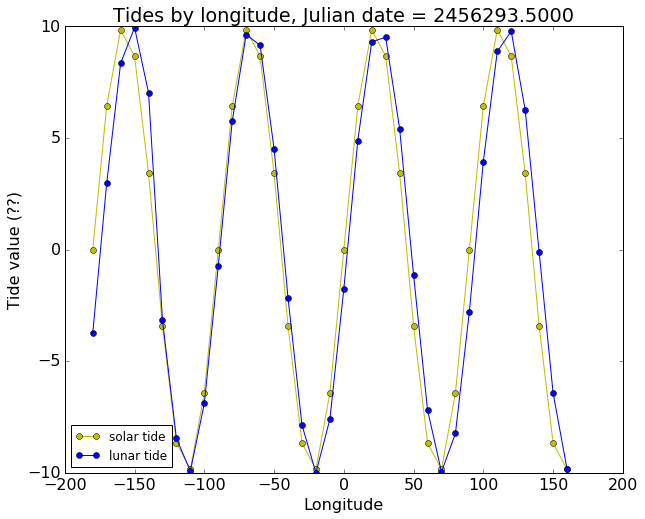

In [5]:
plt.figure(figsize=(10,8))
plt.plot(lonVtides[start:stop,2], lonVtides[start:stop,6], 'yo-', label='solar tide')
plt.plot(lonVtides[start:stop,2], lonVtides[start:stop,7], 'bo-', label='lunar tide')
plt.title('Tides by longitude, Julian date = 2456293.5000')
plt.xlabel('Longitude')
plt.ylabel('Tide value (??)') # what actually is the units of this?
plt.rcParams.update({'font.size': 16})
plt.legend(loc='lower left', fontsize=12)
plt.show()

### Tide vs. time at single longitude

In [4]:
rows = np.where(lonVtides[:,2]==-100.0000)

In [5]:
times = [lonVtides[i, 3] for i in rows[0]]
soltide = [lonVtides[i, 6] for i in rows[0]]
luntide = [lonVtides[i, 7] for i in rows[0]]

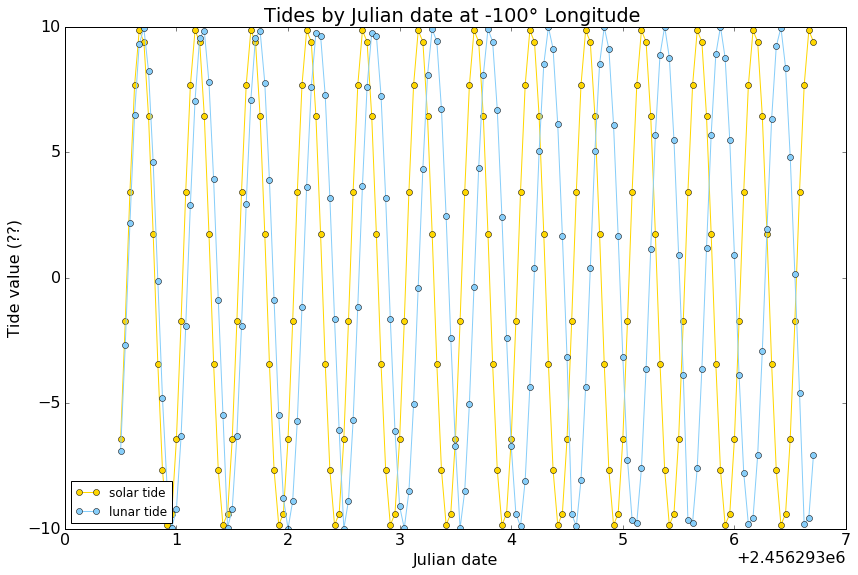

In [6]:
s = 150

plt.figure(figsize=(14,9))
plt.plot(times[:s], soltide[:s], color='gold', marker='o', label='solar tide')
plt.plot(times[:s], luntide[:s], color='lightskyblue', marker='o', label='lunar tide')
plt.title('Tides by Julian date at -100° Longitude ')
plt.xlabel('Julian date')
plt.ylabel('Tide value (??)') # what actually is the units of this?
plt.rcParams.update({'font.size': 16})
plt.legend(loc='lower left', fontsize=12)
plt.show()

To note: the waves perfectly extend to an amplitude of 10, which was specified in this particular instance of the code. 

11:30 am

## Notes from meeting with Astrid

**To try next: try adding the tides together and plotting that, since in the atmosphere it will of course be a stacked effect. It should represent part of what we observe (not all, since it won't be including the smaller effects from the sun and moon and other things like gravity waves).**

Binning:
- test_slt_llt.pro does the binning for you: it sorts by solar local time in the leftmost column - so this file actually is useful and I need to review it
- Should get a single period when plotting based on binning
- Later: binning by solar local time and then averaging; then I think we subtract it out and this removes the solar effect.

Julian date is used to help calculate the moon phase which is written out to the file also. Probably won't need Julian date for most plotting or analysis except maybe to look at patterns over time at a specific location...

Lunar local time corresponds to _where the moon is in the sky_. <br />
Moon age in hours/radians corresponds to _moon phase_ and is independent of the observer position on Earth.

Over time, the lunar and solar tidal waves become out of phase and it is easier to extract the two phases. But, it's hard to quantify the lunar contribution on a small time scale due to the fact that in small scales they are more in phase.  

Units of amplitude in the code: Unclear... Astrid isn't sure. Can probably determine it somehow. Maybe it's temperature, that's a common one.

**To do next: Try running FFT analysis and least χ² fit on data to extract amplitude and phase. Will later use this technique on part B - on the numerical model TIMEGCM.  **

## FFT Analysis on Solar Tidal Data

In [22]:
# This stuff I used to figure things out. I'm leaving it here for documentation purposes.

# GOOD-------------------------------------------------------------------------------
# interv = 0.0417                          # sampling interval
# Fs = 1.0/interv                          # sampling rate in points / time

# sol = np.fft.fft(soltide, norm='ortho')
# n = len(sol)
# k = np.arange(n)                 # indices
# T = n/Fs                         # this should be 1 I guess?
# frq = k/T                        # generate all frequencies
# frq = frq[0:n//2]                # only need half the frequencies

# sol_real = sol[0:n//2]
# END GOOD ---------------------------------------------------------------------------

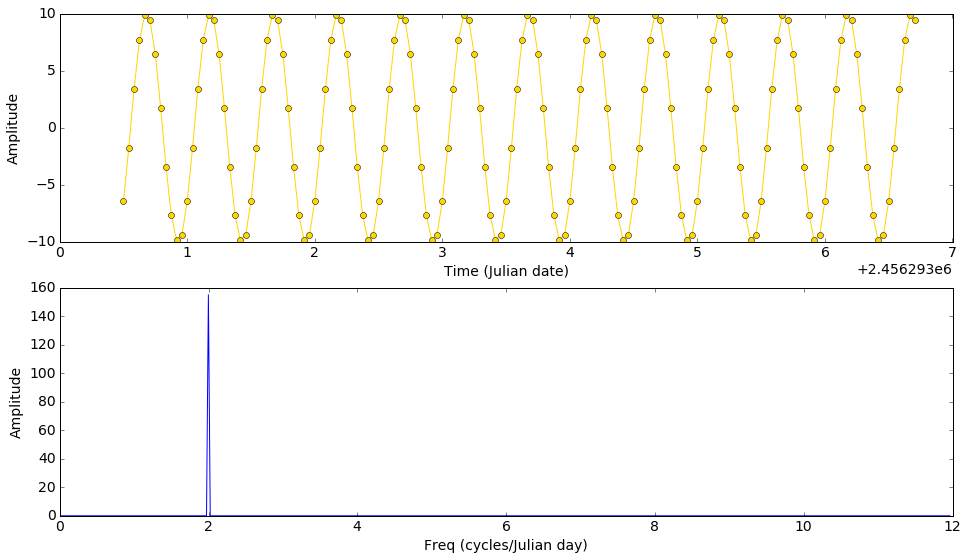

Strongest frequency: 1.9984 cycles/Julian day
Period: 0.5004 days


In [23]:
# length of data
n = len(soltide)

# frequencies
freqs = np.fft.fftfreq(n, d=0.0417)
freqs = freqs[0:n//2]

# perform FFT and calculate associated magnitudes
sol = np.fft.fft(soltide, norm='ortho')
sol_real = sol[0:n//2]
mags = np.absolute(sol_real)       # Calculate amplitude

# Plot everything
plt.figure(figsize=(16,9))
plt.subplot(2,1,1)
plt.plot(times[:s], soltide[:s], color='gold', marker='o')
plt.xlabel('Time (Julian date)')
plt.ylabel('Amplitude')
plt.subplot(2,1,2)
plt.plot(freqs, mags, 'b')         # plotting the spectrum
plt.xlabel('Freq (cycles/Julian day)')
plt.ylabel('Amplitude')
plt.rcParams.update({'font.size': 14})
plt.show()

i = np.where(mags==np.max(mags))
print('Strongest frequency: {} cycles/Julian day'.format(round(freqs[i][0],4)))
print('Period: {} days'.format(round(1/freqs[i][0], 4)))

The following cell does the same task and I used it to help me figure out why I suck so much at FFT. I stole it from here: http://glowingpython.blogspot.com/2011/08/how-to-plot-frequency-spectrum-with.html

Strongest frequency: 1.9984 cycles/Julian day
Period: 0.5004 days


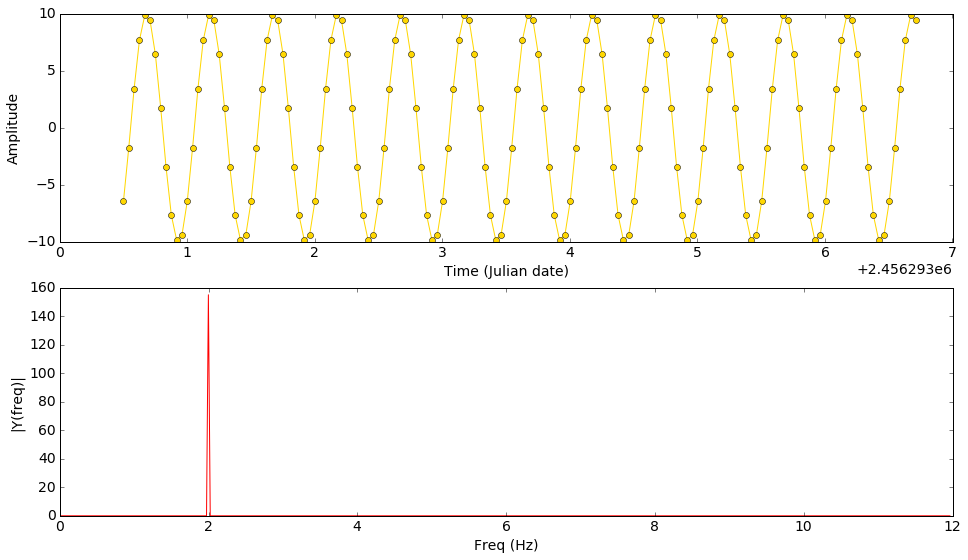

In [24]:
# stolen from someone on the internet

def plotSpectrum(y,Fs):
    """
    Plots a Single-Sided Amplitude Spectrum of y(t)
    """
    n = len(y)                       # Get length of the signal
    k = np.arange(n)                 # indices
    T = n/Fs                         # this should be 1 I guess?
    frq = k/T                        # generate all frequencies
    frq = frq[0:n//2]                # only need half the frequencies
    Y = np.fft.fft(y, norm='ortho')  # fft computing and normalization
    Y = Y[0:n//2]
    mags = abs(Y)
    
    plt.plot(frq, mags, 'r')         # plotting the spectrum
    plt.xlabel('Freq (Hz)')
    plt.ylabel('|Y(freq)|')
    i = np.where(mags==np.max(mags))
    print('Strongest frequency: {} cycles/Julian day'.format(round(frq[i][0],4)))
    print('Period: {} days'.format(round(1/frq[i][0], 4)))
    


Ts = 0.0417                          # sampling interval
Fs = 1.0/Ts                          # sampling rate in points / time
t = np.arange(2456293.5000,2456333.4583+Ts,Ts)                # time vector
y = soltide

plt.figure(figsize=(16,9))
plt.subplot(2,1,1)
plt.plot(t[:s], soltide[:s], color='gold', marker='o')
plt.xlabel('Time (Julian date)')
plt.ylabel('Amplitude')
plt.subplot(2,1,2)
plotSpectrum(y,Fs)
plt.show()

Moral of the story: Use FFT functions correctly.

1. <font color="red">Use np.fft.fft() and np.fft.fftfreq.</font> 
2. **<font color="red">ALWAYS PUT IN THE SPACING (d) INTO THE FFTFREQ FUNCTION</font>**
3. <font color="red">Avoid using rfftfreq, apparently</font>
4. <font color="red">n is original length of data</font>
4. <font color="red">After getting the frequencies and fft transform, use this tag on each array to get only the real data (non-negative frequencies and associated magnitudes): [0:n//2]</font>
5. <font color="red">Absolute value the magnitudes to deal with the imaginary numbers</font>

Note: the spacing is the distance between points in time. 

I think that's enough for now, at least we know this FFT code works and we can use it later. I'll put it into a function so it can be easily use.

To do tomorrow:
* Put the code into a function so I can easily call it regularly
* Read papers
* Try adding together the tides
* Talk with Astrid about next week

# 17 June 2016 - Writing FFT analysis functions

Here's the function.

## Function to run FFT analysis


In [21]:
def runFFT(timeData, tideData, long, dt, stop=None):
    '''
    Performs an FFT analysis on a given set of tidal data and plots the 
    original data as well as the FFT output (frequency spectrum).
    
    timeData: A 1D array listing the points in time at which data were taken.
    tideData: A 1D array of solar or lunar tidal values.
    long: Longitude for which the data exists
    dt: separation of the data points in time.
    '''
    n = len(tideData)

    # Identify the frequencies used in the analysis
    freqs = np.fft.fftfreq(n, d=dt)
    freqs = freqs[0:n//2]             # Only the real frequencies are required

    # Do FFT analysis and calculate the magnitudes
    f = np.fft.fft(tideData, norm='ortho')
    f_real = f[0:n//2]
    mags = np.absolute(f_real)        # Calculate amplitude

    # Plot everything
    if stop != None:
        s = stop                # Number of steps to plot from original data
    else:
        s = n+1
    plt.figure(figsize=(16,9))
    plt.subplot(2,1,1)
    plt.title('Tides and associated frequency at {}° Longitude'.format(long))
    plt.plot(timeData[:s], tideData[:s], color='blueviolet', marker='o')
    plt.xlabel('Time (Julian date)')
    plt.ylabel('Amplitude')
    plt.subplot(2,1,2)
    plt.plot(freqs, mags, color='forestgreen')         # plotting the spectrum
    plt.xlabel('Frequency (cycles/Julian day)')
    plt.ylabel('Amplitude')
    plt.rcParams.update({'font.size': 14})
    plt.show()

    # Find the largest peak and display the information about it
    i = np.where(mags==np.max(mags))
    print('Strongest frequency: {} cycles/Julian day'.format(round(freqs[i][0],4)))
    print('Period: {} days'.format(round(1/freqs[i][0], 4)))

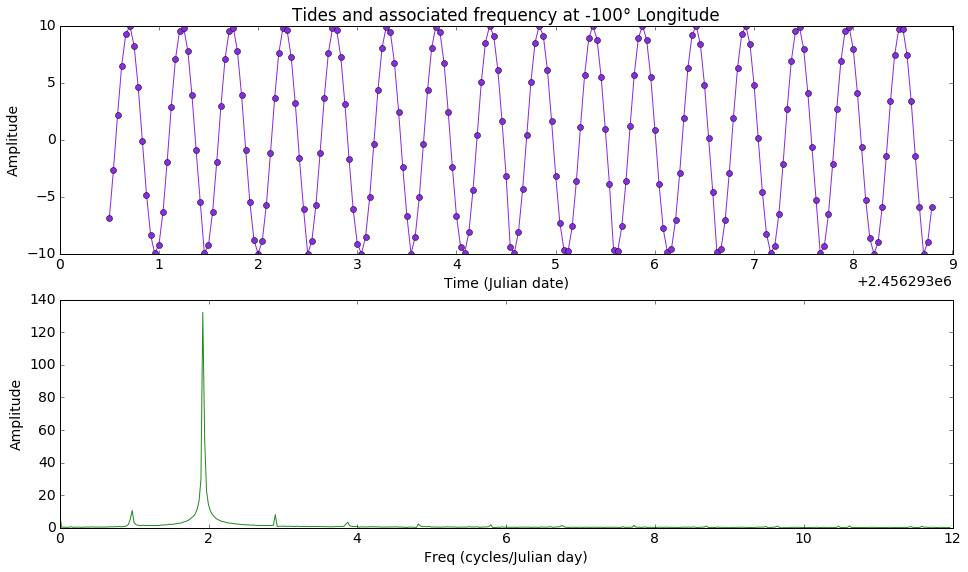

Strongest frequency: 1.9235 cycles/Julian day
Period: 0.5199 days


In [27]:
runFFT(times, luntide, -100, 0.0417, 200)

## Try adding together the tides

Not really sure, but I'll sum the two inputs together and then run FFT on it.

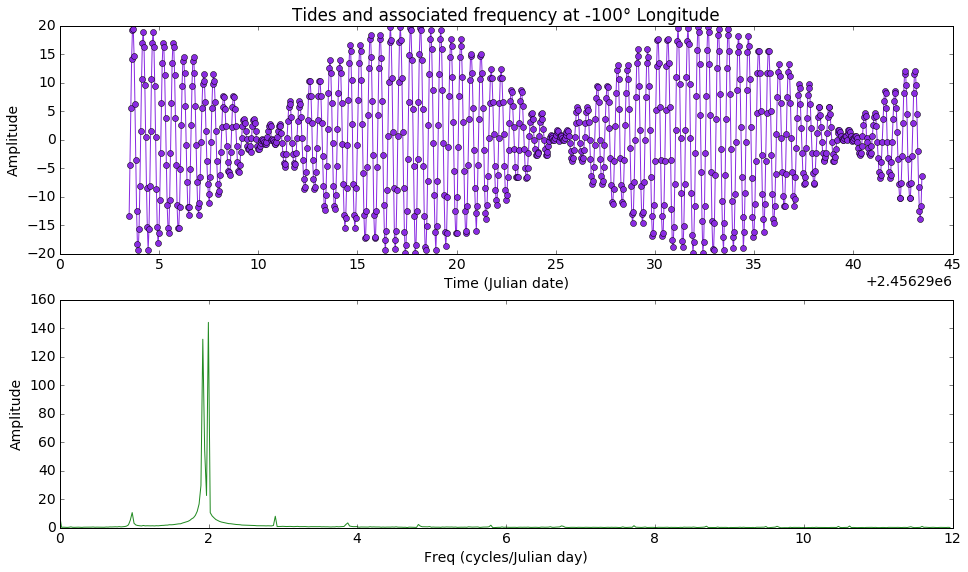

Strongest frequency: 1.9984 cycles/Julian day
Period: 0.5004 days


In [28]:
combined = np.asarray(soltide) + np.asarray(luntide)
runFFT(times, combined, -100, 0.0417)

Yeah. That makes sense. You can easily see that it's the sum of two sinusoids in the plot and also that there are two peak frequencies in the FFT analysis with the solar one being slightly larger (it's the one on the right).

The little peaks that are visible, but small, are probably artifacts because the time points are actually not always 0.0417 apart. Sometimes they are 0.0001 off.

They could also be due to cutting off the wave (because of when data was taken).

11:45 am

## Notes from meeting with Astrid:

Background: In general, we have the tides but also other effects from heating, wind and so on. If the background is constant, it is easy to subtract; but, when it has seasonal variations, it could be harder to subtract.

Migrating tides: 
- Have same responses at different longitudes but same local time (if amplitude and phase are the same)

Non-migrating tides:
- For same local times, it varies with longitude

Astrid's files she sent:
- my_get...: Does a least-squares fit
- my_readfile: Called by my_get... to read in a NetCDF file

Longitude and local time are both independent variables since they are in the argument of the cosine function.

**Fits**: fit will be to the form $A_{ns}\cos[\frac{2πnt}{24} - s\lambda + \Phi_{ns}]$

**Goal/process of part A: Test removing solar components and analyze residuals for lunar tide. Build a system that will: **
1. Feed in data (knowing the universal time, day, longitude)
2. Bin by solar local time (using the IDL script, maybe)
3. Average the solar data 
4. Subtract the solar data mean from the data set
5. Bin this residual by lunar local time 
6. Look at amplitude and phase of lunar tides; get amplitude and phase either visually or via fitting. For fitting, use FFT analysis as well as χ².
7. Compare to the values of amplitude and phase that we fed in to the data generation routine. 

For steps A1 - A4....

Background:
- We can generate it to add it to the data. Just pick a number. Astrid may be able to provide some ballpark numbers for its magnitude.

Window sensitivity: use a sliding box moved by a day each time. This smooths over the effects from cutting off a wave at a random point in the cycle, which causes edge effects.

Note: amplitudes are the same in the data generation routine because, in periods of Sudden Stratospheric Warming, they would be comparable.

Ratios of amplitudes:
- With no noise, we expect to easily recover amplitude and phase without regard to the ratio of the amplitudes of solar and lunar tides.
- If we can't, we need to figure out why

How to recover the phase:
- Phase is related to longitude. Sometimes given as local time. 
- Phase can be represented by where the maximum in a wave is at specific universal time versus the local time.

Fitting:
- FFT: reveals info about period. 2-step process because you have to pull out first the solar wave number. (I still don't fully understand this)
- χ²: 1 step process because you just fit it using the model given above and it will tell you what each parameter is.
- Wavenumbers: the number corresponds to the number of maxima and minima. For example, wavenumber = 2 means 2 max, 2 min (i.e. a period of 12 hours ish).

## Plan for next steps 

12:44 pm
    
Going forward for the next week, let's focus on this process:

**Goal/process of part A: Test removing solar components and analyze residuals for lunar tide. Build a system that will: **
1. Feed in data (knowing the universal time, day, longitude)
2. Bin by solar local time (using the IDL script, maybe)
3. Average the solar data 
4. Subtract the solar data mean from the data set
5. Bin this residual by lunar local time 
6. Look at amplitude and phase of lunar tides; get amplitude and phase either visually or via fitting. For fitting, use FFT analysis as well as χ².
7. Compare to the values of amplitude and phase that we fed in to the data generation routine. 

Now I could use the IDL script `test_slt_llt.pro` to bin by solar local time, but to do that I have to edit the loop and rerun the script and then I get a file with data for one longitude across solar local times (but like solar local times are grouped together). This is because the code steps forward one Julian day at a time, so every new line is a new Julian day at longitude *L* and the solar local time is then further grouped by hour (12 noon, 1300, 1400 etc). The code only runs for *D* days so you get $D \times 24$ rows.

That means that in the particular iteration I've been toying with, which runs for 40 days, I should have $40 \times 24 = 960$ rows of data. I just checked it in gedit on the other computer and indeed, that is correct.

I think an easier process of binning will be to just read in the entire data set for all longitudes and then use numpy operations to find what I need.

Then, the average of the solar tidal data will be computed based on the solar local time for these *D* days, so I'll have an average solar tidal value for solar local time 12 across all longitudes and the *D* days. Then this gets subtracted from the data set that is the solar and lunar tides added together, since that's what we'd do with real data. 

Finally, after subtracting the solar contribution, I'll have the lunar contribution, which I will then analyze using FFT and χ² to see if I can recover the original amplitude, period and phase. 

My concern is that I won't get a reasonable average for the solar tidal data because a non-squared sinusoid should average to 0 over its period.... but maybe it won't average to 0 over the *D* days period. Maybe that's the idea.

**Note**: Actually that 960 figure from above is for only one longitude. If you include all longitudes then the real value is $40 \times 24 \times 36 = 34560$.

## Notes from meeting with Astrid again 
MORE NOTES 2:00 pm

All the solar local times have a decimal value of .0000, .3333, or .6667.

Should include something to generate own wave; using the equation from the presentation. Actually do the summation; summing over wave numbers and period.

calculate values for all times and longitudes using specified longitudinal separation, day, UT, year.

(change values in other scripts to generate more sets of data with different wavenumbers and different n). 

Test with a few waves. Put phase = 0 in the beginning

Average: 
- Pick one wavenumber, wavenumber = 2 for example. (we define)
- Generate data with the summation function for solar and lunar waves. (we define)
- Know year, day, UT, longitude for the variables. (we define)
- Pick one solar local time and longitude
- Average solar tide value over solar local time. This should give a value. In the cases here it will be probably just the value at each point if they are the same.

Ruth was reading in data from a numerical model (nogaps_alpha). Using only wind and temperature, but later we watn to do longitude and time and stuff

note: if see I, J, K, it's longitude, latitude, height in Ruth's script.

Later: try using wavenumber = 3 because this is non migrating and then you would need the whole day (different values at different longitudes though solar local time is the same). 
So for non migrating, it is not consistent for the same local time at different longitudes so you need to use all the solar local times for a day to do the average.

Equation vs Ruth's data:

Best to use the equation to generate the data so you can easily track the changes throughout.

So use  $\sum \sum A_{ns}\cos[\frac{2πnt}{24} - s\lambda + \Phi_{ns}]$

And input a chosen amplitude, n, t, s, λ, Φ. But start with Φ = 0 and n = 2. For s, pick two values. Doesn't really matter which. (If n=2, then s=2 => migrating, and s=3 => nonmigrating) Will need to loop over longitudes (λ) and times (t). 

t is universal time and is really just the time at Greenwich Meridian. in hours.

n: diurnal or semidiurnal; temporal value<br />
s: zonal wavenumber; represents max and min along a longitude as mentioned above; spatial value

right now just focus on migrating.

## Bin by solar local time

In [4]:
data

array([[  12.    ,   20.9573, -180.    , ...,   15.0427,   -0.    ,
          -3.7547],
       [  12.6667,   21.6239, -170.    , ...,   15.0427,    6.4279,
           2.9714],
       [  13.3333,   22.2906, -160.    , ...,   15.0427,    9.8481,
           8.3509],
       ..., 
       [   9.    ,    9.4825,  150.    , ...,   23.5175,   -5.    ,
          -8.184 ],
       [   9.6667,   10.1491,  160.    , ...,   23.5175,   -9.3969,
          -2.6867],
       [  10.3333,   10.8158,  170.    , ...,   23.5175,   -9.3969,
           4.0281]])

In [4]:
# Establish the possible solar local times
slt = np.ndarray.tolist(data[:,0])
unique_slt = set( [round(x,4) for x in slt] )

In [5]:
# Test for solar local time = 12

slt12 = data[np.where(data[:,0] == 12.0000)]
print(slt12)

[[  12.       20.9573 -180.     ...,   15.0427   -0.       -3.7547]
 [  12.       20.8895  150.     ...,   15.1105   -8.6603   -9.9455]
 [  12.       20.8218  120.     ...,   15.1782   -8.6603   -5.5944]
 ..., 
 [  12.       12.6518  -90.     ...,   23.3482   -0.       -9.9252]
 [  12.       12.5841 -120.     ...,   23.4159    8.6603   -5.7428]
 [  12.       12.5163 -150.     ...,   23.4837    8.6603    4.5268]]


In [6]:
# mean must be calculated for just one longitude at a time.

s = slt12[np.where(slt12[:,2]==150)]
print(np.mean(s[:,6]))

-8.6603


In [7]:
#============================================================================#
# Bin by solar local time for particular longitudes and calculate mean solar 
# tide value
#============================================================================#
means = []

# iterate over solar local times
for val in unique_slt:
    # iterate over longitudes
    for lon in range(-180, 190, 10):
        sltSlice = data[np.where(data[:,0] == val)]
        sltSlice = sltSlice[np.where(sltSlice[:,2]==lon)]
        if sltSlice.size != 0:
            means.append([val, lon, np.mean(sltSlice[:,6])])
            
means = np.asarray(means)

with open('solar tides binned by solar local time.txt', 'w') as f:
    f.write('Solar Local Time\tLongitude\tMean Solar Tide\n')
    for line in means:
        f.write('{}\t{}\t{}\n'.format(line[0], line[1], line[2]))
        
#=============================================================================================#

## To do for next time

1. Build code to generate my own data apart from that generated by Ruth's script
2. Re-run the binning and averaging as above
3. Review throughly the various concepts 
4. Figure out what the "complete data set" is that the solar stuff will be subtracted from

# 20 June 2016 - Writing functions to remove solar contribution, compare to original and run chi squared test

10:22 am

Gussied up the code above that bins by solar local time and writes info to a file. It can be adapted later to other data that will be created by a code I write.

Going to make a table of contents now because this document is getting big.

11:30 am

Question: How do I subtract off the mean solar tide from the whole data? 

For every solar local time and longitude I have basically a different solar mean. This is a mean over time (solar local time and longitude held constant; Julian day allowed to vary). I think what I should do is subtract calculated means from any row matching the longitude and local time in the data set where I add them together. In some cases this must result in a 0 for the solar contribution, which is okay, since we're working with synthetic data here. Let's try it and work up the code.

## Functions for main task

In [8]:
data[:,7]

array([-3.7547,  2.9714,  8.3509, ..., -8.184 , -2.6867,  4.0281])

In [8]:
#============================================================================#
# create combined array
#============================================================================#
combined = np.array(data)
combined = np.delete(combined, 7, 1)
combined[:,6] = data[:,6] + data[:,7]
combined

array([[  12.    ,   20.9573, -180.    , ...,    0.    ,   15.0427,
          -3.7547],
       [  12.6667,   21.6239, -170.    , ...,    0.    ,   15.0427,
           9.3993],
       [  13.3333,   22.2906, -160.    , ...,    0.    ,   15.0427,
          18.199 ],
       ..., 
       [   9.    ,    9.4825,  150.    , ...,   23.    ,   23.5175,
         -13.184 ],
       [   9.6667,   10.1491,  160.    , ...,   23.    ,   23.5175,
         -12.0836],
       [  10.3333,   10.8158,  170.    , ...,   23.    ,   23.5175,
          -5.3688]])

In [9]:
ind = np.where((combined[:,0]==0) & (combined[:,2]==-180))[0]
combined.shape[0]

34560

In [10]:
#============================================================================#
# Reconstruct lunar tidal data by subtracting solar tide averages from combined
# tidal totals
#============================================================================#

def remove_solar(c, filename): 
    '''
    Subtract off the solar tidal averages. Iterates through the file holding 
    solar tidal average data per solar local time and longitude.
    --INPUT--
        c    Data table where columns are solar local time, lunar local time, 
             longitude, lunar Julian date, hour, moon phase and total tidal 
             value.
    --OUTPUT--
        r    1D array holding "reconstructed" lunar tidal values, extracted by
             removing solar contributions.
    '''
    # create new array to store subtracted values
    r = np.zeros([c.shape[0]])

    # For each file line, find row in c array where solar local time and 
    # longitude for each match. Then subtract the solar tidal data, given in 
    # the file, from combined tidal data in c and store in r
    with open(filename, 'r') as sbin:
        head = next(sbin)              # takes care of header line
        for line in sbin:
            l = line.split()
            slt = float(l[0])
            lon = float(l[1])
            # find rows in c that match this line's values
            i = np.where((c[:,0]==slt) & (c[:,2]==lon))[0]
            r[i] = c[i,6] - float(l[2])
            
    return r
            
recon = remove_solar(combined, 'solar tides binned by solar local time.txt')

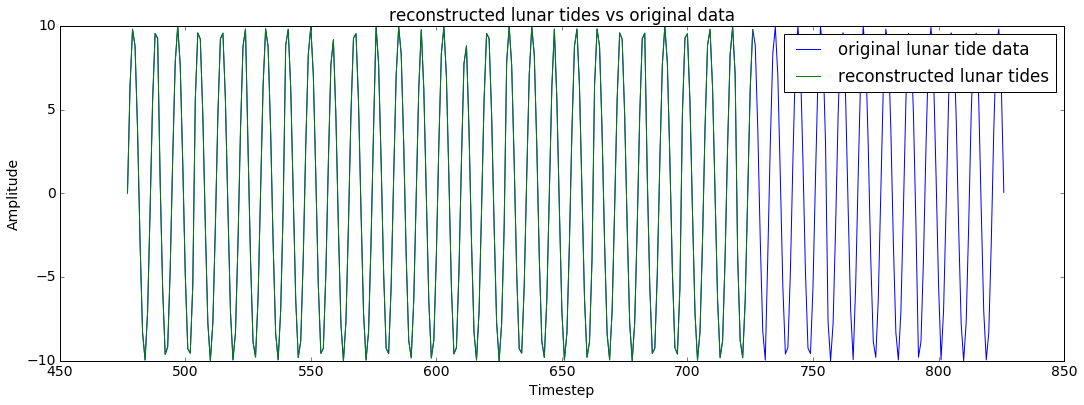

In [12]:
#============================================================================#
# Compare reconstructed data to original data 
#============================================================================#

# Plot to get a general sense of things

def compare_with_plot(recon, original):
    x = np.arange(0, recon.shape[0])
    i = 477
    s = 350

    plt.figure(figsize=(18,6))
    plt.title('reconstructed lunar tides vs original data')
    plt.plot(x[i:i+s], original[i:i+s], label='original lunar tide data')
    plt.plot(x[i:i+s-100], recon[i:i+s-100], label='reconstructed lunar tides')
    plt.xlabel('Timestep')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper right')
    plt.rcParams.update({'font.size': 14})
    plt.show()
    
compare_with_plot(recon, data[:,7])

2:00 pm

Looking pretty good.  It's hard to look at the whole set at once since it's so large. We can also do a χ² minimization.

In [12]:
#============================================================================#
# Perform χ² minimization test for the observed ('recon') and expected 
# ('original') lunar tidal data. We expect the result to be quite good since 
# we are working with basically perfect data (non-real world).
#============================================================================#

def chisq(obs, exp):
    '''
    Do χ² minimization given two data sets in the form of numpy arrays.
    '''
    tot = 0

    for o,e in zip(obs, exp):
        chisq = (o-e)**2 / e
        tot += chisq

    print(tot)
    
original = data[:,7]
chisq(recon, original)

-1.16868084096e-26


<font color="#9944FF">Hmmm... why is it negative?</font>

8:00 pm 

Now going to just work the above codes into functions for use later.

8:20 pm

# 21 June 2016 - Writing Tide Generating Function V1

9:00 am

Now going to write the function that generates data using the equation, $$\sum_{n=1}^2 \sum_{s=2}^{3} A_{ns} \cos\left(\frac{2πnt}{24} − sλ + Φ_{ns}\right)$$

But how do year and day come into this? I know I need to know universal time, but where does the Julian date etc. fit in?

I'm reviewing some of the documents Astrid gave me for information. I'll collect information here.

## s - longitudinal wave number

* Ranges from -6 to 6 (13 total numbers)
* $s > 0$ implies a westward-migrating wave.
* $s = 0$: standing wave, does not move WRT earth (i think)


## n - temporal frequency

* $n = 1 \implies $ diurnal variation (24 hour period)
* n = 2 => semidiurnal variation (12 hour period)
* n = 3 => teriurnal variation (8 hour period)

## migrating tide

* Stationary with respect to sun, so it progresses about the earth westward with the same speed as the sun does
* $s = 2$ when $n=2$, for example
* Global scale
* Periods are harmonics of one day
* Caused by absorption of solar radiation, which causes excitation
* Excitation is in entire atmosphere
* longitudinally invariant!

## non-migrating tide

* When $s \neq n$
* Move either faster or slower than sun
* Excited mostly in troposphere
* Caused by daily variations in latent heat release due to clouds and raindrops 



11:00 am
    
Cell below is where I will build the tide-generating function. This will mimic the code written by Maura Hagan, tides_synthetic.pro. I think my doing this is mostly for my own edification.

Primer on using Astropy time module for Julian date and so on: http://docs.astropy.org/en/stable/time/

Okay, here's what I'm now going to do, as I explained it to my partner who has some physics background and is mostly a computer scientist:

I'm still a little confused by some terminology and can't keep them straight in my head all the time, but I'm pretty sure I know what I'm supposed to be doing now. This is to write a new script that is similar to Dr. Hagan's `tides_synthetic.pro`. My script will use the summation function to generate the total tidal value from which we will later try to reconstruct the lunar data. I'm going to basically translate her script into Python and add the summation, since hers doesn't do the summation. 

Here is what Astrid just emailed me:
<blockquote>
your process is the right way to go. Step bu step.
Yes, generate a few waves and look at the time variation.
Start with one and then add. Look at a particular longitude (plot over UT), and then at particular local time maybe.
</blockquote>

1:46 pm

Note: I don't need to do the stuff associated with checking if we crossed into a new month and finding the "today_jul_lun" that Dr. Hagan does because what she is doing is re-calculating a new Julian date that includes hours. I chose to include the hour start time as a parameter so my dates are automatically accurate enough to skip that part.

Also, she increments the day within the hour loop, but that's a waste of resources. I move it up one level to save cycles.

2:15 pm

**IMPORT AMENDMENT TO ABOVE**

Julian dates do not have precision down to the hour.... and/or we don't know exactly what we're getting from the Python module because it's a black box. So, it's best to not specify a start time and just start at midnight. Then as we loop through the hours, we can increment those and get the associated Julian date.

In [24]:
def gen_tides_v1(startDate, endDate):
    '''
    Generates tidal data using the equation ΣΣA_{ns} cos[2πnt/24 − sλ + Φ_{ns}]
    with constant amplitude and phase (***?). This function is altitude and 
    latitude independent (***???)
    where 
        A = amplitude
        n = 2nd harmonic (semidiurnal variation)
        s = zonal wavenumber (maxes and mins along a line of longitude)
            s = 2 => migrating tide
            s = 3 => non-migrating tide
        t = universal time at Greenwich Meridian
        λ = longitude
        Φ = phase
    --INPUT--
        startDate: a start date, format '2016-06-21'
        endDate: an end date, format '2016-06-30'
    --OUTUT--
        Tidal data in array of format:
        Solar local time - Lunar local time - Longitude - Solar Julian date - 
        Lunar Julian date - Hour of day - Moon phase in hours - Tidal value
        
    Adapted from a script by Dr. Maura Hagan by Eryn Cangi for LASP REU 2016.
    '''
    from math import pi, cos
    from astropy.time import Time
    from jdcal import jd2gcal
    
    # Establish amplidues, phases, hours in day and other variables
    A = 10
    phi_S = pi/2
    phi_L = 0                    # just to start, set phase to 0
    hoursPerDay = 24 
    
    # Define longitude grid using radians; define omega (earth rotation rate)
    # *** Make adjustable later
    # Tested good.
    numLongCells = 36
    longIncr = 360 // numLongCells
    longs = np.asarray([l*pi/180 for l in list(range(-180, 180, longIncr))])
    omega = 2*pi/24
    
    # Identify start and stop day, convert to Julian dates. Tested good.
    start = startDate + ' 00:00:00'
    end = endDate + ' 00:00:00'
    ti = Time(start, format='iso', scale='utc').jd # Julian converstion
    tf = Time(end, format='iso', scale='utc').jd
    numDays = int(tf - ti)
    print(numDays)
    
    f = open('emc.txt', 'w')
    f.write('{:^20}{:^20}{:^20}{:^20}{:^20}{:^20}{:^20}{:^20}\n'.format('Solar'
                                               +' local time', 'Lunar' +
                                               ' local time', 'Longitude', 
                                               'Julian Date', 'Hour',
                                               'Moon phase (hrs)', 'SW2', 
                                               'M2'))

    # LOOP THROUGH TIMESPAN (DAYS)
    for day in range(numDays+1):       # + makes inclusive: does work for last day
        # Calculate current Julian date
        curJulDate = ti + day
        # Reconvert to Julian date to get regular date and format a string
        conv = jd2gcal(curJulDate,0) 
        curRegDate = '{}-{:>02}-{:>02}'.format(conv[0], conv[1], conv[2])
        
        # current hour - should always be 0 because we start at midnight and
        # have not yet incremented the hours (see next loop)
        curRegHour = conv[3]
        
        # LOOP THROUGH HOURS IN DAY
        for hr in range(hoursPerDay):        
            # Update hour on Julian date
            curRegHour = 0 + hr
            
            # Get Julian date for purposes of finding lunar phase
            preciseDate = '{} {:>02}:00:00'.format(curRegDate, curRegHour)
            preciseJDate = Time(preciseDate, format='iso', scale='utc').jd
            
            # Calculate moon phase (cf. Chapman & Linzen)
            ref = Time('1899-12-31 12:00:00', format='iso', scale='utc').jd
            T = (preciseJDate - ref) / 36525
            nu = -9.26009 + 445267.12165*T + 0.00168*(T**2)
            ageDeg = nu % 360
            nuRad = ageDeg * pi / 180
            nuHrs = (nu/15) % 24
            
            # LOOP OVER LONGITUDES
            for l in longs:
                # Calculate solar local time
                slt = hr + l/omega
                if slt < 0:
                    slt = slt + 24
                elif slt > 24:
                    slt = slt - 24
                else:
                    pass

                # Calculate lunar local time
                llt = slt - nuHrs
                llt = llt + 24 if llt < 0 else llt
                
                # CALCULATE THE TIDES!! SUMMATION GOES HERE !! FIX
                s = 2
                sw2 = A * cos((2*pi/12)*slt + s*l - phi_S)
                m2 = A * cos((2*pi/12.41)*llt + s*l - phi_L)
                
                slt = round(slt,4)
                llt = round(llt,4)
                l = round(l*180/pi,4)
                preciseJDate = round(preciseJDate,4)
                hr = round(hr,4)
                nuHrs = round(nuHrs,4)
                sw2 = round(sw2,4)
                m2 = round(m2,4)
                
                f.write('{:^20}{:^20}{:^20}{:^20}'
                        '{:^20}{:^20}{:^20}{:^20}\n'.format(slt, llt, l, 
                                                            preciseJDate, hr, 
                                                            nuHrs, sw2, m2))
                
    f.close()

In [25]:
gen_tides_v1('2013-01-01', '2013-02-09')

39


4:07 pm
    
Nice! This is looking good. There's some weirdness with a few values, but this mostly reproduces the output of the script written by Dr. Hagan. Tomorrow I will actually alter it so it uses the real equation.

# 23 June 2016 - In which I start out chipper but then waste the entire day chasing a stupid precision error when I should have acted on my instincts and tested that first

Good morning! Here's the plan for today. I skipped yesterday since we had a lunch excursion to NOAA and a friend was in town.

1. Check my function's output against that of Dr. Hagan's to make sure they produce the same results.
2. Rewrite the function to generate tides to include the summation
3. Do what Astrid said (edited for conciseness and clarity):

    <blockquote>
    <ol>
    <li>start with one period p=12 and zonal wavenumber = 2</li>
    <li>study this one (over 1-2 days) with longitude</li>
    <li>then instead of p=12 use p=24 -> study<br />
    the first one is migrating the second one is nonmigrating.</li>
    <li>use p=24 and s=1 -> migrating diurnal tide (at each longitude it should look the same if the solar local time is the same) -> check this</li>

    <li>once you see and understand you can add them to see what you get.</li>

    <li>if this works focus on the M2 and do the same.</li>
    </blockquote>

And as needed I can start slides for final talk and poster (afternoon or whenever I get stuck)

10:30 am

There are some differences between the codes. This seems to be because I was using different values for the phases (hers were 90 degrees out of phase, mine are not) and the period for M2 is 0.01 off. I'll fix those things now and see how the output looks.

Okay, that's done: now let's just read in some lines and compare them because I don't want to do this by eye.

In [22]:
hagan = np.loadtxt('x_sl.dat', skiprows=1)
emc = np.loadtxt('test.txt', skiprows=1)

r = emc.shape[0]
c = emc.shape[1]

print(r,c)

print(emc.shape)

match = np.zeros([r,c])

for i in range(0,36):
    for j in range(0,c):
        if hagan[i,j] == emc[i,j]:
            match[i,j] = 1

print(match)
    

34560 8
(34560, 8)
[[ 1.  0.  1. ...,  0.  1.  0.]
 [ 1.  0.  1. ...,  0.  1.  0.]
 [ 1.  0.  1. ...,  0.  1.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


Okay so they're not equal. That may be okay... it may be differences in how IDL and python handle numbers and rounding. How off are they?

In [23]:
print(emc.shape)
print(hagan.shape)
diff = emc - hagan
print(diff)

np.savetxt('diff_emc_hagan.txt', diff, fmt='%8.4f', delimiter='\t')

(34560, 8)
(34560, 8)
[[ 0.      0.0002  0.     ..., -0.0002  0.      0.0012]
 [ 0.      0.0003  0.     ..., -0.0002  0.      0.0011]
 [ 0.      0.0002  0.     ..., -0.0002  0.      0.0006]
 ..., 
 [ 0.      0.0002  0.     ..., -0.0002  0.      0.0007]
 [ 0.      0.0003  0.     ..., -0.0002  0.      0.0011]
 [ 0.      0.0002  0.     ..., -0.0002  0.      0.0011]]


Aha! I have found something in scrolling through the file created in the above cell.

Periodically the solar local time is off from Hagan's by 24!

<img src="pics/off1.png" />
<img src="pics/off2.png" />

Difference is

In [38]:
2956-2092

864

That's exactly

In [39]:
24 * 36

864

So something is wrong in the way I'm looping with longitudes or something. Here's the 2093rd line from each file, since in the diffs there is no header:

**emc**

24.0     6.9935     -150.0    2456295.9167     10     17.0065    8.6603     -1.2406       


**hagan**

0.0000    6.9932    -150.0    2456295.9167      10    17.0068    8.6603     -1.2421


AHA! So my code is accidentally going into the 24th hour which is actually the next day. It's in the solar local time calculation. It's probably when I do the ± 24. Yeah, it must be when I say "if slt > 24 then slt = slt - 24". It needs to be >=.

11:37 am

okay I think I fixed it but sublime still shows a 24 where there should be a 0 at line 2093. But all the other lines are fine. So it can't be what I thought. 

11:40 am

Okay I just checked the difference array again and now there are some cells that are -24 off! i.e. Hagan's code has some 24s in there, just in a difference place than mine. So the > 24 must have been correct--it's something *else*.

It must be related to this: 

WARNING: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)" [astropy._erfa.core]

Based on a cursory google search this may be related to using UTC instead of UT1, which I think I determined I was supposed to do earlier in this notebook. Let's try it with UT1.

In [29]:
def gen_tides_v2(startDate, endDate):
    '''
    Generates tidal data using the equation ΣΣA_{ns} cos[2πnt/24 − sλ + Φ_{ns}]
    with constant amplitude and phase (***?). This function is altitude and 
    latitude independent (***???)
    where 
        A = amplitude
        n = 2nd harmonic (semidiurnal variation)
        s = zonal wavenumber (maxes and mins along a line of longitude)
            s = 2 => migrating tide
            s = 3 => non-migrating tide
        t = universal time at Greenwich Meridian
        λ = longitude
        Φ = phase
    --INPUT--
        startDate: a start date, format '2016-06-21'
        endDate: an end date, format '2016-06-30'
    --OUTUT--
        Tidal data in array of format:
        Solar local time - Lunar local time - Longitude - Solar Julian date - 
        Lunar Julian date - Hour of day - Moon phase in hours - Tidal value
        
    Adapted from a script by Dr. Maura Hagan by Eryn Cangi for LASP REU 2016.
    '''
    from math import pi, cos
    from astropy.time import Time
    from jdcal import jd2gcal
    
    # Establish amplidues, phases, hours in day and other variables
    A = 10
    phi_S = pi/2
    phi_L = 0                    # just to start, set phase to 0
    hoursPerDay = 24 
    
    # Define longitude grid using radians; define omega (earth rotation rate)
    # *** Make adjustable later
    # Tested good.
    numLongCells = 36
    longIncr = 360 // numLongCells
    longs = np.asarray([l*pi/180 for l in list(range(-180, 180, longIncr))])
    omega = 2*pi/24
    
    # Identify start and stop day, convert to Julian dates. Tested good.
    start = startDate + ' 00:00:00'
    end = endDate + ' 00:00:00'
    ti = Time(start, format='iso', scale='ut1').jd # Julian converstion
    tf = Time(end, format='iso', scale='ut1').jd
    numDays = int(tf - ti)
    
    f = open('emc2.txt', 'w')
    f.write('{:^20}{:^20}{:^20}{:^20}{:^20}{:^20}{:^20}{:^20}\n'.format('Solar'
                                               +' local time', 'Lunar' +
                                               ' local time', 'Longitude', 
                                               'Julian Date', 'Hour',
                                               'Moon phase (hrs)', 'SW2', 
                                               'M2'))

    # LOOP THROUGH TIMESPAN (DAYS)
    for day in range(numDays+1):       # + makes inclusive: does work for last day
        # Calculate current Julian date
        curJulDate = ti + day
        
        # Reconvert to Julian date to get regular date and format a string
        conv = jd2gcal(curJulDate,0) 
        curRegDate = '{}-{:>02}-{:>02}'.format(conv[0], conv[1], conv[2])
        
        # current hour - should always be 0 because we start at midnight and
        # have not yet incremented the hours (see next loop)
        curRegHour = conv[3]
        
        # LOOP THROUGH HOURS IN DAY
        for hr in range(hoursPerDay):        
            # Update hour on Julian date
            curRegHour = 0 + hr
            
            # Get Julian date for purposes of finding lunar phase
            preciseDate = '{} {:>02}:00:00'.format(curRegDate, curRegHour)
            preciseJDate = Time(preciseDate, format='iso', scale='ut1').jd
            
            # Calculate moon phase (cf. Chapman & Linzen)
            ref = Time('1899-12-31 12:00:00', format='iso', scale='ut1').jd
            T = (preciseJDate - ref) / 36525
            nu = -9.26009 + 445267.12165*T + 0.00168*(T**2)
            ageDeg = nu % 360
            nuRad = ageDeg * pi / 180
            nuHrs = (nu/15) % 24
            
            # LOOP OVER LONGITUDES
            for l in longs:
                # Calculate solar local time
                slt = hr + l/omega
                if slt < 0:
                    slt = slt + 24
                elif slt > 24:
                    slt = slt - 24
                else:
                    pass

                # Calculate lunar local time
                llt = slt - nuHrs
                llt = llt + 24 if llt < 0 else llt
                
                # CALCULATE THE TIDES!! SUMMATION GOES HERE !! FIX
                s = 2
                sw2 = A * cos((2*pi/12)*slt + s*l - phi_S)
                m2 = A * cos((2*pi/12.41)*llt + s*l - phi_L)
                
                slt = round(slt,4)
                llt = round(llt,4)
                l = round(l*180/pi,4)
                preciseJDate = round(preciseJDate,4)
                hr = round(hr,4)
                nuHrs = round(nuHrs,4)
                sw2 = round(sw2,4)
                m2 = round(m2,4)
                
                f.write('{:^20}{:^20}{:^20}{:^20}'
                        '{:^20}{:^20}{:^20}{:^20}\n'.format(slt, llt, l, 
                                                            preciseJDate, hr, 
                                                            nuHrs, sw2, m2))
                
    f.close()

    
gen_tides_v2('2013-01-01', '2013-02-09')

hagan2 = np.loadtxt('x_sl.dat', skiprows=1)
emc2 = np.loadtxt('emc2.txt', skiprows=1)

r = emc2.shape[0]
c = emc2.shape[1]

print(r,c)

print(emc2.shape)

match2 = np.zeros([r,c])

for i in range(0,36):
    for j in range(0,c):
        if hagan2[i,j] == emc2[i,j]:
            match2[i,j] = 1

print(match)
    
diff = emc - hagan
print(diff)

np.savetxt('diff_emc_hagan2.txt', diff, fmt='%8.4f', delimiter='\t')

34560 8
(34560, 8)
[[ 1.  0.  1. ...,  0.  1.  0.]
 [ 1.  0.  1. ...,  0.  1.  0.]
 [ 1.  0.  1. ...,  0.  1.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.      0.0002  0.     ..., -0.0002  0.      0.0012]
 [ 0.      0.0003  0.     ..., -0.0002  0.      0.0011]
 [ 0.      0.0002  0.     ..., -0.0002  0.      0.0006]
 ..., 
 [ 0.      0.0002  0.     ..., -0.0002  0.      0.0007]
 [ 0.      0.0003  0.     ..., -0.0002  0.      0.0011]
 [ 0.      0.0002  0.     ..., -0.0002  0.      0.0011]]


No. That didn't fix it either. Let's slow down and think about this. What is the differences file telling me?

1. Lunar local time is always a slight amount higher than Hagan's
2. Moon phase is always a slight amount less than Hagan's
3. Solar tide is almost always spot on, and is at the most 0.0001 off despite SLT display problems.
4. Lunar tides vary between overshooting and undershooting Hagan's script but are always on the order of 0.0010 off.

So there is DEFINITELY something wrong with the lunar calculations. Let's look at those.

Lunar local time = solar local time - nu

There's a problem on EVERY data point but SLT isn't always wrong, sometimes it's right on. So something is going on with the calculation of nu. Nu is in hours, so maybe something is wrong with the order of operations surrounding the modulus usage. It could also be converting Julian date bak to actual date wrong--this is very likely since I DID use a blackbox. I'll try changing order of op with mod just to see if that's it.

That didn't work, actually. In fact it made no difference.

1:11 pm after lunch

Before lunch I thought that the problem is most likely due to the conversion of the julian date back to the regular date. But what good is seeking out code that explicitly calculates Julian date if its just as much of a blackbox?

In referencing *Astronomical Algorithms*, a table is given on page 61 of some dates and their JD equivalent. I can use these to test the black box I am using to make sure it works--even though I tested my start and end dates, a few more datapoints would be useful.

In [58]:
print(jd2gcal(2451545.0,0))
print(jd2gcal(2446822.5,0))
print(jd2gcal(2446966.0,0))
print(jd2gcal(2447187.5,0))
print(jd2gcal(2447332.0,0))
print(jd2gcal(2415020.5,0))
print(jd2gcal(2305447.5,0))
print(jd2gcal(2305812.5,0))
print(jd2gcal(2026871.8,0))
print(jd2gcal(1356001.0,0))
print(jd2gcal(1355866.5,0))
print(jd2gcal(1355671.4,0))
print(jd2gcal(0.0,0))

(2000, 1, 1, 0.5)
(1987, 1, 27, 0.0)
(1987, 6, 19, 0.5)
(1988, 1, 27, 0.0)
(1988, 6, 19, 0.5)
(1900, 1, 1, 0.0)
(1600, 1, 1, 0.0)
(1600, 12, 31, 0.0)
(837, 4, 14, 0.30000000004656613)
(-1000, 7, 3, 0.5)
(-1000, 2, 19, 0.0)
(-1001, 8, 7, 0.8999999999068677)
(-4713, 11, 24, 0.5)


Okay, so this module clearly doesn't work for dates very far in the past. But does that matter for us? Either way, let's program a function directly out of this book to see if we can get correct results with that.

In [108]:
def jd_to_date(jd):    
    '''
    Converts Julian date to Gregorian date.
    From Astronomical Algorithms, Jean Meeus, 1991.
    '''
    import math

    j = jd + 0.5
    z = math.trunc(j)
    f = j - z

    if z < 2299161:
        A = z
    else:
        alpha = int((z - 1867216.25)/36524.25)
        A = z + 1 + alpha - int(alpha/4)

    B = A + 1524
    C = int((B - 122.1)/365.25)
    D = int(365.25 * C)
    E = int((B - D)/30.6001)

    day = B - D - int(30.6001 * E)
    month = E - 1 if E < 14 else E - 13
    year = C - 4716 if month > 2 else C - 4715

    # added by me to calculate hours, minutes, seconds.
    h = int(f * 24)
    m = int((f * 24 - int(h)) * 60)
    s = int((((f * 24 - int(h)) * 60) - m) * 60)

    return year, month, day, h, m, s

In [109]:
print(jd_to_date(2456293.5000))
print(jd_to_date(2456333.4583))

(2013, 1, 1, 0, 0, 0)
(2013, 2, 9, 22, 59, 57)


Now test with our points from the book:

In [110]:
print(jd_to_date(2451545.0))
print(jd_to_date(2446822.5))
print(jd_to_date(2446966.0))
print(jd_to_date(2447187.5))
print(jd_to_date(2447332.0))
print(jd_to_date(2415020.5))
print(jd_to_date(2305447.5))
print(jd_to_date(2305812.5))
print(jd_to_date(2026871.8))
print(jd_to_date(1356001.0))
print(jd_to_date(1355866.5))
print(jd_to_date(1355671.4))
print(jd_to_date(0.0))

(2000, 1, 1, 12, 0, 0)
(1987, 1, 27, 0, 0, 0)
(1987, 6, 19, 12, 0, 0)
(1988, 1, 27, 0, 0, 0)
(1988, 6, 19, 12, 0, 0)
(1900, 1, 1, 0, 0, 0)
(1600, 1, 1, 0, 0, 0)
(1600, 12, 31, 0, 0, 0)
(837, 4, 10, 7, 12, 0)
(-1000, 7, 12, 12, 0, 0)
(-1000, 2, 29, 0, 0, 0)
(-1001, 8, 17, 21, 35, 59)
(-4712, 1, 1, 12, 0, 0)


2:16 pm 

Good. These results all match those in the book! Let's go forward with this converter and try the files again.

In [ ]:
def gen_tides_v3(startDate, endDate):
    '''
    Generates tidal data using the equation ΣΣA_{ns} cos[2πnt/24 − sλ + Φ_{ns}]
    with constant amplitude and phase (***?). This function is altitude and 
    latitude independent (***???)
    where 
        A = amplitude
        n = 2nd harmonic (semidiurnal variation)
        s = zonal wavenumber (maxes and mins along a line of longitude)
            s = 2 => migrating tide
            s = 3 => non-migrating tide
        t = universal time at Greenwich Meridian
        λ = longitude
        Φ = phase
    --INPUT--
        startDate: a start date, format '2016-06-21'
        endDate: an end date, format '2016-06-30'
    --OUTUT--
        Tidal data in array of format:
        Solar local time - Lunar local time - Longitude - Solar Julian date - 
        Lunar Julian date - Hour of day - Moon phase in hours - Tidal value
        
    Adapted from a script by Dr. Maura Hagan by Eryn Cangi for LASP REU 2016.
    '''
    from math import pi, cos
    from astropy.time import Time
    
    # Establish amplidues, phases, hours in day and other variables
    A = 10
    phi_S = pi/2
    phi_L = 0                    # just to start, set phase to 0
    hoursPerDay = 24 
    
    # Define longitude grid using radians; define omega (earth rotation rate)
    # *** Make adjustable later
    # Tested good.
    numLongCells = 36
    longIncr = 360 // numLongCells
    longs = np.asarray([l*pi/180 for l in list(range(-180, 180, longIncr))])
    omega = 2*pi/24
    
    # Identify start and stop day, convert to Julian dates. Tested good.
    start = startDate + ' 00:00:00'
    end = endDate + ' 00:00:00'
    ti = Time(start, format='iso', scale='ut1').jd # Julian converstion
    tf = Time(end, format='iso', scale='ut1').jd
    numDays = int(tf - ti)
    
    f = open('emc.txt', 'w')
    f.write('{:^20}{:^20}{:^20}{:^20}'
            '{:^20}{:^20}{:^20}{:^20}\n'.format('Solar local time', 'Lunar' +
                                               ' local time', 'Longitude', 
                                               'Julian Date', 'Hour',
                                               'Moon phase (hrs)', 'SW2', 
                                               'M2'))

    # LOOP THROUGH TIMESPAN (DAYS)
    for day in range(numDays+1):       # + makes inclusive: does work for last day
        # Calculate current Julian date
        curJulDate = ti + day
        
        # Reconvert to Julian date to get regular date and format a string
        yr, mo, d, h, minute, sec = jd_to_date(curJulDate) 
        curRegDate = '{}-{:>02}-{:>02}'.format(yr, mo, d)
        curRegTime = '{:>02}:{:>02}:{:>02}'.format(h, minute, sec)
        curRegHour = h
        
        # LOOP THROUGH HOURS IN DAY
        for hr in range(hoursPerDay):        
            # Update hour on Julian date
            curRegHour = 0 + hr
            curRegTime = '{:>02}:{:>02}:{:>02}'.format(h, minute, sec)
            
            # Get Julian date for purposes of finding lunar phase
            preciseDate = '{} {}'.format(curRegDate, curRegTime)
            preciseJDate = Time(preciseDate, format='iso', scale='ut1').jd
            
            # Calculate moon phase (cf. Chapman & Linzen)
            ref = Time('1899-12-31 12:00:00', format='iso', scale='ut1').jd
            T = (preciseJDate - ref) / 36525
            nu = -9.26009 + 445267.12165*T + 0.00168*(T**2)
            ageDeg = nu % 360
            nuRad = ageDeg * pi / 180
            nuHrs = (nu/15) % 24
            
            # LOOP OVER LONGITUDES
            for l in longs:
                # Calculate solar local time
                slt = hr + l/omega
                if slt < 0:
                    slt = slt + 24
                elif slt > 24:
                    slt = slt - 24
                else:
                    pass

                # Calculate lunar local time
                llt = slt - nuHrs
                llt = llt + 24 if llt < 0 else llt
                
                # CALCULATE THE TIDES!! SUMMATION GOES HERE !! FIX
                s = 2
                sw2 = A * cos((2*pi/12)*slt + s*l - phi_S)
                m2 = A * cos((2*pi/12.41)*llt + s*l - phi_L)
                
                slt = round(slt,4)
                llt = round(llt,4)
                l = round(l*180/pi,4)
                preciseJDate = round(preciseJDate,4)
                hr = round(hr,4)
                nuHrs = round(nuHrs,4)
                sw2 = round(sw2,4)
                m2 = round(m2,4)
                
                f.write('{:^20}{:^20}{:^20}{:^20}'
                        '{:^20}{:^20}{:^20}{:^20}\n'.format(slt, llt, l, 
                                                            preciseJDate, hr, 
                                                            nuHrs, sw2, m2))
                
    f.close()

    
gen_tides_v3('2013-01-01', '2013-02-09')

hagan = np.loadtxt('x_sl.dat', skiprows=1)
emc = np.loadtxt('emc.txt', skiprows=1)

r = emc.shape[0]
c = emc.shape[1]

print(r,c)

print(emc.shape)

match = np.zeros([r,c])

for i in range(0,r):
    for j in range(0,c):
        if hagan[i,j] == emc[i,j]:
            match[i,j] = 1

print(match)
    
diff = emc - hagan
print(diff)

np.savetxt('diff_emc_hagan.txt', diff, fmt='%8.4f', delimiter='\t')

oh, wow. The differences are actually even worse now. Better program date_to_jd myself also...

In [146]:
def date_to_jd(date, time):    
    '''
    Converts Gregorian date to Julian date given the format:
    date = YYYY-MM-DD, time = HH:MM:SS
    From Astronomical Algorithms, Jean Meeus, 1991.
    '''
    x = time.split(':')
    x = [int(xi) for xi in x]
    s = x[2]
    mi = x[1]
    h = x[0]
    f = h/24 + mi/(60*24) + s/3600
    
    sign = 1
    if date[0] == '-':
        date = date[1:]
        sign = -1
    x = date.split('-')
    x = [int(xi) for xi in x]
    d = x[2]
    mo = x[1]
    y = sign * x[0]
    
    earlyOct1582 = (y==1582 and mo<=10 and d < 15)
    early1582 = (y==1582 and mo<= 9)
    anytimeBefore = (y < 1582)
    
    if earlyOct1582 or early1582 or anytimeBefore:
        flag = 'J'
    else: 
        flag = 'G'

    if mo == 1 or mo == 2:
        y = y - 1
        mo = mo + 12
    
    A = int(y / 100)
    B = 2 - A + int(A / 4) if flag=='G' else 0

    jd = int(365.25 * (y + 4716)) + int(30.6001 * (mo + 1)) + d + B - 1524.5 + f
    
    return jd

In [147]:
print(date_to_jd('2000-01-01', '12:00:00'))
print(date_to_jd('1987-01-27', '00:00:00'))
print(date_to_jd('1987-06-19', '12:00:00'))
print(date_to_jd('1988-01-27', '00:00:00'))
print(date_to_jd('1988-06-19', '12:00:00'))
print(date_to_jd('1900-01-01', '00:00:00'))
print(date_to_jd('1600-01-01', '00:00:00'))
print(date_to_jd('1600-12-31', '00:00:00'))
print(date_to_jd('837-04-10', '07:12:00'))
print(date_to_jd('-1000-07-12', '12:00:00'))
print(date_to_jd('-1000-02-29', '00:00:00'))
print(date_to_jd('-1001-08-17', '21:36:00'))
print(date_to_jd('-4712-01-01', '12:00:00'))

2451545.0
2446822.5
2446966.0
2447187.5
2447332.0
2415020.5
2305447.5
2305812.5
2026871.8
1356001.0
1355866.5
1355671.4
0.0


3:40 pm

Good... finally... 

In [149]:
def gen_tides_v4(startDate, endDate):
    '''
    Generates tidal data using the equation ΣΣA_{ns} cos[2πnt/24 − sλ + Φ_{ns}]
    with constant amplitude and phase (***?). This function is altitude and 
    latitude independent (***???)
    where 
        A = amplitude
        n = 2nd harmonic (semidiurnal variation)
        s = zonal wavenumber (maxes and mins along a line of longitude)
            s = 2 => migrating tide
            s = 3 => non-migrating tide
        t = universal time at Greenwich Meridian
        λ = longitude
        Φ = phase
    --INPUT--
        startDate: a start date, format '2016-06-21'
        endDate: an end date, format '2016-06-30'
    --OUTUT--
        Tidal data in array of format:
        Solar local time - Lunar local time - Longitude - Solar Julian date - 
        Lunar Julian date - Hour of day - Moon phase in hours - Tidal value
        
    Adapted from a script by Dr. Maura Hagan by Eryn Cangi for LASP REU 2016.
    '''
    from math import pi, cos
    
    # Establish amplidues, phases, hours in day and other variables
    A = 10
    phi_S = pi/2
    phi_L = 0                    # just to start, set phase to 0
    hoursPerDay = 24 
    
    # Define longitude grid using radians; define omega (earth rotation rate)
    # *** Make adjustable later
    numLongCells = 36
    longIncr = 360 // numLongCells
    longs = np.asarray([l*pi/180 for l in list(range(-180, 180, longIncr))])
    omega = 2*pi/24
    
    # Convert dates to Julian dates
    ti = date_to_jd(startDate, '00:00:00')
    tf = date_to_jd(endDate, '00:00:00')
    numDays = int(tf - ti)
    
    f = open('emc.txt', 'w')
    f.write('{:^20}{:^20}{:^20}{:^20}'
            '{:^20}{:^20}{:^20}{:^20}\n'.format('Solar local time', 'Lunar' +
                                               ' local time', 'Longitude', 
                                               'Julian Date', 'Hour',
                                               'Moon phase (hrs)', 'SW2', 
                                               'M2'))

    # LOOP THROUGH TIMESPAN (DAYS)
    for day in range(numDays+1):       # + makes inclusive: does work for last day
        # Calculate current Julian date
        curJulDate = ti + day
        
        # Reconvert to Julian date to get regular date and format a string
        yr, mo, d, h, minute, sec = jd_to_date(curJulDate) 
        curRegDate = '{}-{:>02}-{:>02}'.format(yr, mo, d)
        curRegTime = '{:>02}:{:>02}:{:>02}'.format(h, minute, sec)
        curRegHour = h
        
        # LOOP THROUGH HOURS IN DAY
        for hr in range(hoursPerDay):        
            # Update hour on Julian date
            curRegHour = 0 + hr
            curRegTime = '{:>02}:{:>02}:{:>02}'.format(curRegHour, minute, sec)
            
            # Get Julian date for purposes of finding lunar phase
            preciseJDate = date_to_jd(curRegDate, curRegTime)
            
            # Calculate moon phase (cf. Chapman & Linzen)
            ref = date_to_jd('1899-12-31', '12:00:00')
            T = (preciseJDate - ref) / 36525
            nu = -9.26009 + 445267.12165*T + 0.00168*(T**2)
            ageDeg = nu % 360
            nuRad = ageDeg * pi / 180
            nuHrs = (nu/15) % 24
            
            # LOOP OVER LONGITUDES
            for l in longs:
                # Calculate solar local time
                slt = hr + l/omega
                if slt < 0:
                    slt = slt + 24
                elif slt > 24:
                    slt = slt - 24
                else:
                    pass

                # Calculate lunar local time
                llt = slt - nuHrs
                llt = llt + 24 if llt < 0 else llt
                
                # CALCULATE THE TIDES!! SUMMATION GOES HERE !! FIX
                s = 2
                sw2 = A * cos((2*pi/12)*slt + s*l - phi_S)
                m2 = A * cos((2*pi/12.41)*llt + s*l - phi_L)
                
                slt = round(slt,4)
                llt = round(llt,4)
                l = round(l*180/pi,4)
                preciseJDate = round(preciseJDate,4)
                hr = round(hr,4)
                nuHrs = round(nuHrs,4)
                sw2 = round(sw2,4)
                m2 = round(m2,4)
                
                f.write('{:^20}{:^20}{:^20}{:^20}'
                        '{:^20}{:^20}{:^20}{:^20}\n'.format(slt, llt, l, 
                                                            preciseJDate, hr, 
                                                            nuHrs, sw2, m2))
                
    f.close()

    
gen_tides_v4('2013-01-01', '2013-02-09')

hagan = np.loadtxt('x_sl.dat', skiprows=1)
emc = np.loadtxt('emc.txt', skiprows=1)

r = emc.shape[0]
c = emc.shape[1]

print(r,c)

print(emc.shape)

match = np.zeros([r,c])

for i in range(0,r):
    for j in range(0,c):
        if hagan[i,j] == emc[i,j]:
            match[i,j] = 1

print(match)
    
diff = emc - hagan
print(diff)

np.savetxt('diff_emc_hagan.txt', diff, fmt='%8.4f', delimiter='\t')

34560 8
(34560, 8)
[[ 1.  0.  1. ...,  0.  1.  0.]
 [ 1.  0.  1. ...,  0.  1.  0.]
 [ 1.  0.  1. ...,  0.  1.  0.]
 ..., 
 [ 1.  0.  1. ...,  0.  1.  0.]
 [ 1.  0.  1. ...,  0.  1.  0.]
 [ 1.  0.  1. ...,  0.  1.  0.]]
[[ 0.      0.0002  0.     ..., -0.0002  0.      0.0012]
 [ 0.      0.0003  0.     ..., -0.0002  0.      0.0011]
 [ 0.      0.0002  0.     ..., -0.0002  0.      0.0006]
 ..., 
 [ 0.      0.0002  0.     ..., -0.0002  0.      0.0007]
 [ 0.      0.0003  0.     ..., -0.0002  0.      0.0011]
 [ 0.      0.0002  0.     ..., -0.0002  0.      0.0011]]


In [150]:
date_to_jd('1899-12-31', '12:00:00')

2415020.0

You know what? After all that, the same problems are there. 

Today has been a colossal waste of time... I mean I guess I learned some things but all that troubleshooting was for nothing.

Okay, that's not true. I know the problem isn't with the Julian date calculation. It's somewhere else.

SOMEWHERE MUCH SIMPLER.

I would like to note that it's not 100% important that I'm able to perfectly match Maura Hagan's script. For all I know, she did something wrong.

4:04 pm

What an apt time to figure this out. The problem is really just precision error. Python has a higher precision than IDL, apparently.

<img src="pics/pythonprecision.png" />
<img src="pics/idlprecision.png" />

You know, I suspected that might have been the error earlier. Why didn't I just TEST it? 

ugh. Oh well. I suppose it's useful to have functions written for julian date because I can't expect everyone to have astropy and jdcal installed. whatever.



In [20]:
def jd_to_date(jd):    
    '''
    Converts Julian date to Gregorian date.
    From Astronomical Algorithms, Jean Meeus, 1991.
    '''
    import math

    j = jd + 0.5
    z = math.trunc(j)
    f = j - z

    if z < 2299161:
        A = z
    else:
        alpha = int((z - 1867216.25)/36524.25)
        A = z + 1 + alpha - int(alpha/4)

    B = A + 1524
    C = int((B - 122.1)/365.25)
    D = int(365.25 * C)
    E = int((B - D)/30.6001)

    day = B - D - int(30.6001 * E)
    month = E - 1 if E < 14 else E - 13
    year = C - 4716 if month > 2 else C - 4715

    # added by me to calculate hours, minutes, seconds.
    h = int(f * 24)
    m = int((f * 24 - int(h)) * 60)
    s = int((((f * 24 - int(h)) * 60) - m) * 60)

    return year, month, day, h, m, s

def date_to_jd(date, time):    
    '''
    Converts Gregorian date to Julian date given the format:
    date = YYYY-MM-DD, time = HH:MM:SS
    From Astronomical Algorithms, Jean Meeus, 1991.
    '''
    x = time.split(':')
    x = [int(xi) for xi in x]
    s = x[2]
    mi = x[1]
    h = x[0]
    f = h/24 + mi/(60*24) + s/3600
    
    sign = 1
    if date[0] == '-':
        date = date[1:]
        sign = -1
    x = date.split('-')
    x = [int(xi) for xi in x]
    d = x[2]
    mo = x[1]
    y = sign * x[0]
    
    earlyOct1582 = (y==1582 and mo<=10 and d < 15)
    early1582 = (y==1582 and mo<= 9)
    anytimeBefore = (y < 1582)
    
    if earlyOct1582 or early1582 or anytimeBefore:
        flag = 'J'
    else: 
        flag = 'G'

    if mo == 1 or mo == 2:
        y = y - 1
        mo = mo + 12
    
    A = int(y / 100)
    B = 2 - A + int(A / 4) if flag=='G' else 0

    jd = int(365.25 * (y + 4716)) + int(30.6001 * (mo + 1)) + d + B - 1524.5 + f
    
    return jd

def get_moon_phase(now):
    '''
    Calculate moon phase for a given Julian date.(cf. Chapman & Linzen)
    ---INPUT---
        now: a Julian date, including hours, minutes, seconds.
    ---OUTPUT---
        nuHrs: Phase of the moon in hours
    '''
    from math import pi
    
    ref = date_to_jd('1899-12-31', '12:00:00')
    T = (now - ref) / 36525
    nu = -9.26009 + 445267.12165*T + 0.00168*(T**2)
    ageDeg = nu % 360
    nuRad = ageDeg * pi / 180
    nuHrs = (nu/15) % 24
    return nuHrs

def gen_tides_v5(startDate, endDate, numLongs):
    '''
    Generates tidal data using the equation ΣΣA_{ns} cos[2πnt/24 − sλ + Φ_{ns}]
    with constant amplitude and phase (***?). This function is altitude and 
    latitude independent (***???)
    where 
        A = amplitude
        n = 2nd harmonic (semidiurnal variation)
        s = zonal wavenumber (maxes and mins along a line of longitude)
            s = 2 => migrating tide
            s = 3 => non-migrating tide
        t = universal time at Greenwich Meridian
        λ = longitude
        Φ = phase
    --INPUT--
        startDate: a start date, format '2016-06-21'
        endDate: an end date, format '2016-06-30'
        numLongs: number of longitudinal cells to divide earth into
    --OUTUT--
        Tidal data in array of format:
        Solar local time - Lunar local time - Longitude - Solar Julian date - 
        Lunar Julian date - Hour of day - Moon phase in hours - Tidal value
        
    Adapted from a script by Dr. Maura Hagan by Eryn Cangi for LASP REU 2016.
    '''
    from math import pi, cos
    
    # Establish amplidues, phases, hours in day and other variables
    A = 10
    phi_S = pi/2                 # just to start, set phase to 0
    phi_L = 0                    # just to start, set phase to 0
    hoursPerDay = 24 
     
    # Define longitude grid using radians; define omega (earth rotation rate)
    # *** Make adjustable later
    longIncr = 360 // numLongs
    longs = np.asarray([l*pi/180 for l in list(range(-180, 180, longIncr))])
    omega = 2*pi/24
    
    # Convert dates to Julian dates
    ti = date_to_jd(startDate, '00:00:00')
    tf = date_to_jd(endDate, '00:00:00')
    numDays = int(tf - ti) + 1 # +1 to include the last day in the loops
    
    # Set up an array in which to store output
    rows = numLongs * 24 * numDays
    output = np.empty([rows,8])
    n = 0 # keep track of rows of data

    # LOOP THROUGH TIMESPAN (DAYS)
    for day in range(numDays):       # + makes inclusive: does work for last day
        # increment date
        curJulDate = ti + day
        
        # Reconvert to Julian date to get regular date and format date string
        yr, mo, d, h, minute, sec = jd_to_date(curJulDate) 
        curRegDate = '{}-{:>02}-{:>02}'.format(yr, mo, d)
        curRegHour = h
        
        # LOOP THROUGH HOURS IN DAY
        for hr in range(hoursPerDay):        
            
            # Update hour on Julian date and format time string, find Julian
            # date for use in finding moon phase
            curRegHour = 0 + hr
            curRegTime = '{:>02}:{:>02}:{:>02}'.format(curRegHour, minute, sec)
            preciseJD = date_to_jd(curRegDate, curRegTime)
            
            # Get moon phase
            nuHrs = get_moon_phase(preciseJD)
            
            # LOOP OVER LONGITUDES
            for l in longs:
                # Calculate solar local time
                slt = hr + l/omega
                if slt < 0:
                    slt = slt + 24
                elif slt > 24:
                    slt = slt - 24
                else:
                    pass

                # Calculate lunar local time
                llt = slt - nuHrs
                llt = llt + 24 if llt < 0 else llt
                
                # CALCULATE THE TIDES!! SUMMATION GOES HERE !! FIX
                s = 2
                sw2 = A * cos((2*pi/12)*slt + s*l - phi_S)
                m2 = A * cos((2*pi/12.41)*llt + s*l - phi_L)
                
                output[n,0] = slt
                output[n,1] = llt
                output[n,2] = l
                output[n,3] = preciseJD
                output[n,4] = hr
                output[n,5] = nuHrs
                output[n,6] = sw2
                output[n,7] = m2
                n += 1
                
    np.savetxt('tides.txt', output, fmt='%.4f', delimiter='\t', 
               header='{:^20}{:^20}{:^20}{:^20}''{:^20}{:^20}{:^20}'
               '{:^20}\n'.format('Solar local time', 'Lunar local time', 
                                 'Longitude', 'Julian Date', 'Hour', 'Moon '
                                 'phase (hrs)', 'SW2', 'M2'))

In [21]:
gen_tides_v5('2013-01-01', '2013-02-09', 36)

In [22]:
!head -n 15 tides.txt

#   Solar local time    Lunar local time       Longitude          Julian Date             Hour          Moon phase (hrs)          SW2                  M2         
# 
12.0000	20.9575	-3.1416	2456293.5000	0.0000	15.0425	0.0000	-3.7535
12.6667	21.6242	-2.9671	2456293.5000	0.0000	15.0425	6.4279	2.9726
13.3333	22.2909	-2.7925	2456293.5000	0.0000	15.0425	9.8481	8.3516
14.0000	22.9575	-2.6180	2456293.5000	0.0000	15.0425	8.6603	9.9457
14.6667	23.6242	-2.4435	2456293.5000	0.0000	15.0425	3.4202	7.0326
15.3333	0.2909	-2.2689	2456293.5000	0.0000	15.0425	-3.4202	-3.1627
16.0000	0.9575	-2.0944	2456293.5000	0.0000	15.0425	-8.6603	-8.4598
16.6667	1.6242	-1.9199	2456293.5000	0.0000	15.0425	-9.8481	-9.9230
17.3333	2.2909	-1.7453	2456293.5000	0.0000	15.0425	-6.4279	-6.8892
18.0000	2.9575	-1.5708	2456293.5000	0.0000	15.0425	-0.0000	-0.7334
18.6667	3.6242	-1.3963	2456293.5000	0.0000	15.0425	6.4279	5.7548
19.3333	4.2909	-1.2217	2456293.5000	0.0000	15.0425	9.8481	9.6350
20.0000	4.9575	-1.0472	2456293.5000	0.

## 4:41 pm summary

Okay, well, I guess I learned some things today. Also, I spent the last half hour gussying up the code into the version above. It now outputs a very lovely file. <font color="#0077FF">This function may get unwieldly if a long frame of time is chosen (so one may need to choose a shorter time frame or run on a better computer).</font>

# 24 June 2016 - Incorporating Equation (finally)

Today: 

1. Rewrite the function to generate tides to include the summation
2. Do what Astrid said (edited for conciseness and clarity):

    <blockquote>
    <ol>
    <li>start with one period p=12 and zonal wavenumber = 2</li>
    <li>study this one (over 1-2 days) with longitude</li>
    <li>then instead of p=12 use p=24 -> study<br />
    the first one is migrating the second one is nonmigrating.</li>
    <li>use p=24 and s=1 -> migrating diurnal tide (at each longitude it should look the same if the solar local time is the same) -> check this</li>

    <li>once you see and understand you can add them to see what you get.</li>

    <li>if this works focus on the M2 and do the same.</li>
    </blockquote>

And as needed I can start slides for final talk and poster (afternoon or whenever I get stuck)

Some questions:

Forbes uses +sλ -Φ and Hagan uses the opposite signs. Which is correct, or does it matter?
Answer: It's +sλ in the Pedatella paper so that's probably correct. I have updated the equation to match.

What is universal time?

I think it's SLT when we're looking at the solar tides, lunar local time when looking at the lunar... but how do we know which is which? Is it that we have n = 1, 2 and s = -6 through 6 for both solar and lunar effects? hmm... Probably. And then the background term in the front is the rest?

Okay, following the pattern in Pedatella et al (2012), equation 3:

$$ T = A + \sum_{n=1}^{2}\sum_{s=-6}^{6} S*\cos(Ωnt_s + sλ - Φ) + \sum_{n=1}^{2}\sum_{s=-6}^{6} L*\cos(Ωnt_L + sλ - Φ) $$

- n = roughly the period (1 = diurnal, 2 = semidiurnal)
- s = zonal wave number (max and min along a line of longitude)
- A = background amplitude of tides (assumed constant)
- S = solar tidal amplitude
- L = lunar tidal amplitude
- Ω = 2π/24, earth rotation rate
- λ = longitude
- Φ = phase

## The main code cell!

In [4]:
def jd_to_date(jd):    
    '''
    Converts Julian date to Gregorian date.
    From Astronomical Algorithms, Jean Meeus, 1991.
    '''
    import math

    j = jd + 0.5
    z = math.trunc(j)
    f = j - z

    if z < 2299161:
        A = z
    else:
        alpha = int((z - 1867216.25)/36524.25)
        A = z + 1 + alpha - int(alpha/4)

    B = A + 1524
    C = int((B - 122.1)/365.25)
    D = int(365.25 * C)
    E = int((B - D)/30.6001)

    day = B - D - int(30.6001 * E)
    month = E - 1 if E < 14 else E - 13
    year = C - 4716 if month > 2 else C - 4715

    # added by me to calculate hours, minutes, seconds.
    h = int(f * 24)
    m = int((f * 24 - int(h)) * 60)
    s = int((((f * 24 - int(h)) * 60) - m) * 60)

    return year, month, day, h, m, s

def date_to_jd(date, time):    
    '''
    Converts Gregorian date to Julian date given the format:
    date = YYYY-MM-DD, time = HH:MM:SS
    From Astronomical Algorithms, Jean Meeus, 1991.
    '''
    
    x = time.split(':')
    x = [int(xi) for xi in x]
    s = x[2]
    mi = x[1]
    h = x[0]
    f = h/24 + mi/(60*24) + s/3600
    
    sign = 1
    if date[0] == '-':
        date = date[1:]
        sign = -1
    x = date.split('-')
    x = [int(xi) for xi in x]
    d = x[2]
    mo = x[1]
    y = sign * x[0]
    
    earlyOct1582 = (y==1582 and mo<=10 and d < 15)
    early1582 = (y==1582 and mo<= 9)
    anytimeBefore = (y < 1582)
    
    if earlyOct1582 or early1582 or anytimeBefore:
        flag = 'J'
    else: 
        flag = 'G'

    if mo == 1 or mo == 2:
        y = y - 1
        mo = mo + 12
    
    A = int(y / 100)
    B = 2 - A + int(A / 4) if flag=='G' else 0

    jd = int(365.25 * (y + 4716)) + int(30.6001 * (mo + 1)) + d + B - 1524.5 + f
    
    jd = float('{:.4f}'.format(jd))
    return jd

def get_moon_phase(now):
    '''
    Calculate moon phase for a given Julian date.(cf. Chapman & Linzen)
    ---INPUT---
        now: a Julian date, including hours, minutes, seconds.
    ---OUTPUT---
        nuHrs: Phase of the moon in hours
    '''
    from math import pi
    
    ref = date_to_jd('1899-12-31', '12:00:00')
    T = (now - ref) / 36525
    nu = -9.26009 + 445267.12165*T + 0.00168*(T**2)
    ageDeg = nu % 360
    nuRad = ageDeg * pi / 180
    nuHrs = (nu/15) % 24
    return nuHrs

def gen_tides_v6(startDate, endDate, amps=[0,10,10], nRange=range(1,3), 
                   sRange=range(-6,7), filename='tides.txt', component='solar'):
    '''
    Generates tidal data using the equation:
    A + ΣΣS_{ns}*cos[Ωnt + sλ - Φ_{ns}] + ΣΣL_{ns}*cos[Ωnt + sλ - Φ_{ns}]
    for specified amplitudes and phases. 
    This function is altitude and latitude independent (***???)
    where 
        A = amplitude
        n = 2nd harmonic (semidiurnal variation)
        s = zonal wavenumber (maxes and mins along a line of longitude)
            s = 2 => migrating tide
            s = 3 => non-migrating tide
        t = universal time at Greenwich Meridian
        λ = longitude
        Φ = phase
    --INPUT--
        startDate       a start date, format '2016-06-21'
        endDate         an end date, format '2016-06-30'
        nRange          values of n to use in calculation
        sRange          values of s to use in calculation
        filename        filename to write values to
        component       solar, lunar, s+l (solar+lunar) or all; specifies 
                        summation bounds for n and s
    --OUTUT--
        Tidal data in array of format:
        Solar local time - Lunar local time - Longitude - Solar Julian date - 
        Lunar Julian date - Hour of day - Moon phase in hours - Tidal value
        
    Adapted from script by Dr. Ruth Lieberman by Eryn Cangi for LASP REU 2016.
    '''
    from math import pi, cos
    
    # VARIABLES --------------------------------------------------------------
    A = amps[0]                  # Background amplitude
    S = amps[1]                  # Solar amplitude
    L = amps[2]                  # Lunar amplitude
    phi = np.zeros([2,13])       # Phases (Φ_{n,s}) (0s = test values)
    hoursPerDay = 24 
     
    # DEFINE LONGITUDE GRID --------------------------------------------------
    longIncr = 360 // 36
    longs = np.asarray([l*pi/180 for l in list(range(-180, 180, longIncr))])
    W = 2*pi/24                  # Earth rotation rate (omega)
    
    # GET JULIAN DATES -------------------------------------------------------
    ti = date_to_jd(startDate, '00:00:00')
    tf = date_to_jd(endDate, '00:00:00')
    numDays = int(tf - ti) + 1 # +1 to include the last day in the loops
    
    # MAKE OUTPUT ARRAY ------------------------------------------------------
    rows = 36 * 24 * numDays
    output = np.empty([rows,7])
    r = 0                        # keep track of rows of data
    
    # LOOP THROUGH TIMESPAN (DAYS) ===========================================
    for day in range(numDays):   # + makes inclusive: calculates for last day
        curJulDate = ti + day
        
        # GET REGULAR DATE FOR CALCULATIONS ----------------------------------
        yr, mo, d, h, minute, sec = jd_to_date(curJulDate) 
        curRegDate = '{}-{:>02}-{:>02}'.format(yr, mo, d)
        curRegHour = h
        
        # LOOP THROUGH HOURS IN DAY ==========================================
        for hr in range(hoursPerDay):        
            
            # UPDATE HOUR, GET NEW JULIAN DATE -------------------------------
            curRegHour = 0 + hr
            curRegTime = '{:>02}:{:>02}:{:>02}'.format(curRegHour, minute, sec)
            newJD = date_to_jd(curRegDate, curRegTime)
            
            # GET MOON PHASE AT THIS HOUR ------------------------------------
            nuHrs = get_moon_phase(newJD)
            
            # LOOP OVER LONGITUDES ===========================================
            for l in longs:
                # CALCULATE SOLAR LOCAL TIME ---------------------------------
                slt = hr + l/W
                if slt < 0:            # Wrap around behavior, Earth = sphere
                    slt = slt + 24
                elif slt > 24:
                    slt = slt - 24
                else:
                    pass

                # CALCULATE LUNAR LOCAL TIME ---------------------------------
                llt = slt - nuHrs
                llt = llt + 24 if llt < 0 else llt
                
                # CALCULATE THE TIDES ----------------------------------------
                tide = 0
                for n in nRange:
                    for s in sRange:
                        if component=='solar':     # solar contribution
                            tide += S * cos((2*pi*n/24)*hr + s*l - phi[n-1,s+6])
                        elif component=='lunar':   # lunar contribution
                            tide += L * cos((2*pi*n/24.84)*hr + s*l - phi[n-1,s+6])
                        elif component=='s+l':
                            tide += S*cos((2*pi*n/24)*slt + s*l - phi[n-1,s+6]) \
                                 + L*cos((2*pi*n/24.84)*llt + s*l - phi[n-1,s+6])
                        elif component=='all':
                            tide += A + S * cos(W*n*hr + s*l - phi[n-1,s+6])\
                                    + L * cos(W*n*hr + s*l - phi[n-1,s+6])
                output[r,0] = slt
                output[r,1] = llt
                output[r,2] = round(l * 180/pi)
                output[r,3] = newJD
                output[r,4] = hr
                output[r,5] = nuHrs
                output[r,6] = tide
                r += 1

    # FORMAT HEADER LINE, WRITE FILE -----------------------------------------
    cells = '{:^20}'*7            
    line0 = cells.format('Solar local time', 'Lunar local time', 'Longitude', 
                        'Julian Date', 'Hour', 'Moon phase (hrs)', 'Tide')
    np.savetxt(filename, output, fmt='%.4f', delimiter='\t', header=line0)
    
    return output

def bin_by_solar(data):
    '''
    Finds the mean of the solar contribution at a given solar local time.
    Writes a file of means for each pair of a unique solar local time and
    longitude.
    ---INPUT---
        data        Array of tidal data
    ---OUTPUT---
        means       3-column array, columns: solar local time, longitude,
                    mean solar contribution.
    '''

    means = []

    # FIND UNIQUE SOLAR LOCAL TIMES ------------------------------------------
    slt = np.ndarray.tolist(data[:,0])
    unique_slt = set([round(x,4) for x in slt])

    # ITERATE OVER SOLAR LOCAL TIMES & LONGITUDES ----------------------------
    for val in unique_slt:
        for lon in range(-180, 190, 10):
            sltSlice = data[np.where(data[:,0] == val)]
            sltSlice = sltSlice[np.where(sltSlice[:,2]==lon)]
            if sltSlice.size != 0:
                means.append([val, lon, np.mean(sltSlice[:,6])])
                
    means = np.asarray(means)
        
    line0 = 'Solar Local Time\tLongitude\tMean Solar Tide\n'
    np.savetxt('slt_bin.txt', output, delimiter='\t', header=line0)

    return means

def plot_vs_long(data, date, time, flag, title, c):
    '''
    Plots tidal value versus longitude for a specified Julian date
    ---INPUT---
        data        Array of tidal data
        date        date in format YYYY-MM-DD
        time        time in format HH:MM:SS
        flag        'save' or 'show', controls how the plot is handled.
        title       descriptive plot title
        c           plot line color. Just for aesthetics.
    ---OUTPUT---
        A plot
    '''
    
    
    JDdate = date_to_jd(date, time)

    # FIND ROWS IN DATA ARRAY WITH MATCHING DATE -----------------------------
    # Because data for a particular Julian date is all grouped together, the 
    # values in rows[0] (the indices) will be consecutive.
    rows = np.where(data[:,3]==JDdate)[0]
    i = rows[0]
    f = rows[-1]
    longs = data[i:f,2]
    tides = data[i:f,6]
    
    # PLOT -------------------------------------------------------------------
    plt.figure(figsize=(10,8))
    plt.plot(longs, tides, color=c, marker=r'$\bigodot$', markersize=12)
    plt.title('{}, {} at {}'.format(title, date, time))
    plt.xlabel('Longitude')
    plt.ylabel('Tide amplitude') # what actually is the units of this?
    plt.rcParams.update({'font.size': 16})
    
    if flag=='show':
        plt.show()
        plt.close()
    elif flag=='save':
        fn = 'tides_d{}_{:>02}.png'
        plt.savefig(fn.format(date, time.split(':')[0]), bbox_inches='tight')
        plt.close()
    
    
    
    
def plot_vs_date(data, long, title, data2=None, c=None, m=None, 
                 lb=None, mode='show'):
    '''
    Plots tidal values over time at a particular longitude.
    ---INPUT---
        data        Array of tidal data
        long        Longitude to examine
        title       descriptive plot title
        data2       Optional second data to plot if stacking two tides
        c           color list, has two elements if stacking.
        m           marker shape to use
        lb          Plot legend elements
        mode        Whether to save or show the figure. Default 'show'
    ---OUTPUT---
        A plot
    '''
    
    if data2 != None:
        stack = True
        
    # FIND ROWS IN ARRAY WITH MATCHING LONGITUDE -----------------------------
    rows = np.where(data[:,2]==long)[0]
    times = [data[i, 3] for i in rows]
    tides = [data[i, 6] for i in rows]
    
    if stack:
        tides2 = [data2[i,6] for i in rows]
    

    # PLOT -------------------------------------------------------------------
    plt.figure(figsize=(25,6))
    s = len(times)                           # set a limit for plotting
    
    if stack:
        plt.plot(times[:s], tides[:s], color=c[0], marker=m, label=lb[0])
        plt.plot(times[:s], tides2[:s], color=c[1], marker=m, label=lb[1])
        plt.legend(loc='lower right')
    else:
        plt.plot(times[:s], tides[:s], marker=m)
    plt.title('{} by Julian date at {}° Longitude'.format(title, long))
    plt.xlim([min(times),max(times)])
    plt.xlabel('Julian date')
    plt.ylabel('Tide amplitude') # what actually is the units of this?
    plt.rcParams.update({'font.size': 16})
    if mode=='show':
        plt.show()
        plt.close()
    elif mode=='save':
        fn = '{} by Julian date at {}° Longitude'.format(title, long)
        plt.savefig(fn, bbox_inches='tight')
        plt.close()
    elif mode=='both':
        fn = '{} by Julian date at {}° Longitude'.format(title, long)
        plt.savefig(fn, bbox_inches='tight')
        plt.show()
        plt.close()

def plot_vs_slt(data, time):
    '''
    Plots tidal value versus solar local time
    ---INPUT---
        data        Array of tidal data
        time        time in format HH:MM:SS
    ---OUTPUT---
        A plot
    '''
    
    # get SLT in proper format
    time_els = time.split(':')
    time_els = [float(s) for s in time_els]
    time = time_els[0] + time_els[1] / 60 + time_els[2] / 3600

    # check for stupid decimal values
    if time % time_els[0] not in [0, 0.3333, 0.6667]:
        raise Exception('Bad time given')

    # find matching SLTs in data            
    rows = np.where(data[:,0]==time)[0]
    longs = [data[i,2] for i in rows]
    tides = [data[i,6] for i in rows]
    
    # make histogram of unique values...
    vals = []
    occurs = []
    uniques = set(tides)
    for u in uniques:
        vals.append(u)
        occurs.append(tides.count(u))
    plt.figure(figsize=(8,6))
    plt.bar(vals, occurs, 0.1, alpha=0.4)
    plt.xlabel('Tidal values')
    plt.ylabel('Occurrences')
    plt.title('Tidal value histogram')
    
    plt.figure(figsize=(10,8))
    plt.scatter(longs,tides, marker='x')
    plt.title('Longitudes vs tides at solar local time {}'.format(time))
    plt.xlabel('Longitude')
    plt.ylabel('Tide value') # what actually is the units of this?
    plt.rcParams.update({'font.size': 16})
    plt.show()

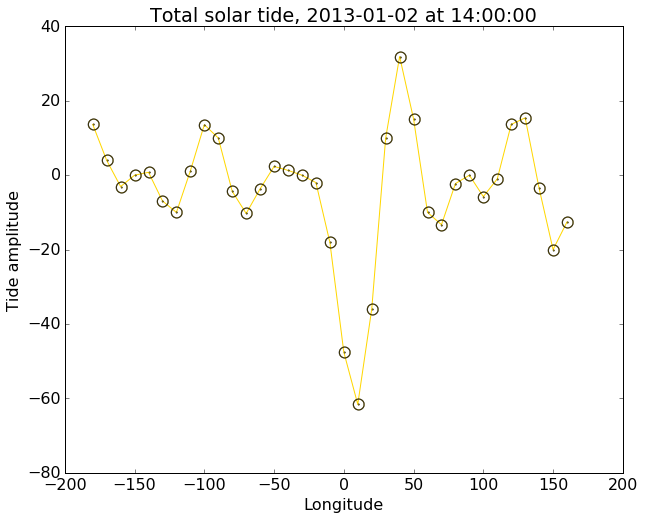

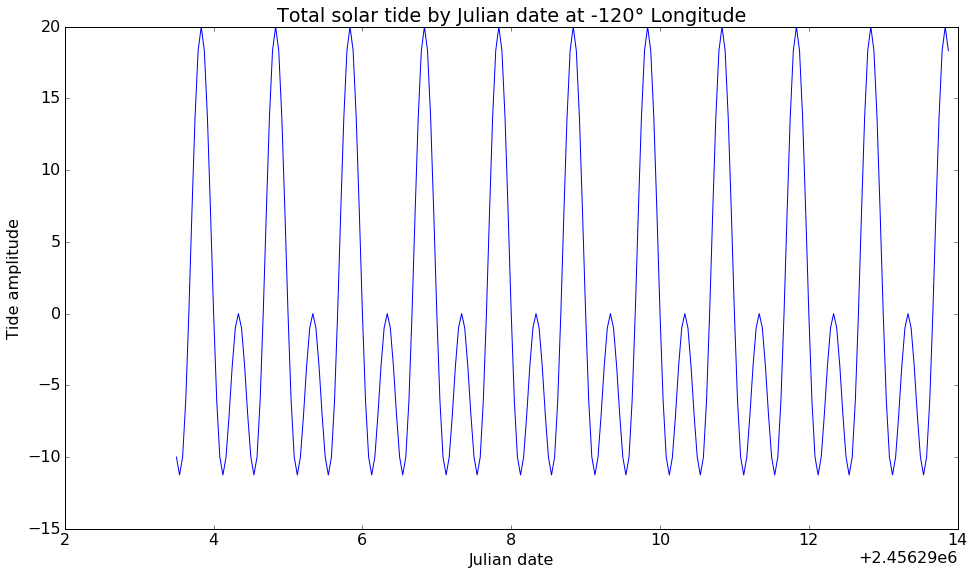

In [19]:
tideData = generate_tides('2013-01-01', '2013-02-09')
plot_vs_long(tideData, '2013-01-02', '14:00:00', 'show', 'Total solar tide', 'gold')
plot_vs_date(tideData, -120, 'Total solar tide')

Interesting but maybe not that useful right now.

In [70]:
!head -n 10 tides.txt

#   Solar local time    Lunar local time       Longitude          Julian Date             Hour          Moon phase (hrs)          Tide        
12.0000	20.9575	-180.0000	2456293.5000	0.0000	15.0425	20.0000
12.6667	21.6242	-170.0000	2456293.5000	0.0000	15.0425	8.4847
13.3333	22.2909	-160.0000	2456293.5000	0.0000	15.0425	-13.0541
14.0000	22.9575	-150.0000	2456293.5000	0.0000	15.0425	-20.0000
14.6667	23.6242	-140.0000	2456293.5000	0.0000	15.0425	-3.6959
15.3333	0.2909	-130.0000	2456293.5000	0.0000	15.0425	18.0767
16.0000	0.9575	-120.0000	2456293.5000	0.0000	15.0425	20.0000
16.6667	1.6242	-110.0000	2456293.5000	0.0000	15.0425	-2.1280
17.3333	2.2909	-100.0000	2456293.5000	0.0000	15.0425	-24.5336


## Studying Generated Data

1:50 pm
   
Looking good! Now let's do what Astrid said.

<blockquote>
    <ol>
    <li>start with one period p=12 and zonal wavenumber = 2</li>
    <li>study this one (over 1-2 days) with longitude</li>
    <li>then instead of p=12 use p=24 -> study<br />
    the first one is migrating the second one is nonmigrating.</li>
    <li>use p=24 and s=1 -> migrating diurnal tide (at each longitude it should look the same if the solar local time is the same) -> check this</li>

    <li>once you see and understand you can add them to see what you get.</li>

    <li>if this works focus on the M2 and do the same.</li>
    </blockquote>

### Note
Cells showing the various solar tides have moved to the next day.

3:47 pm

Everyone has gone, so we're leaving a bit early.

Need to update the plot_by_time function and do that; finish Astrid's list of things.

# 27 June 2016

TO DO - Engine creation & building understanding
1. Finish the plot by time function
2. Finish Astrid's list of tasks for solar
3. Finish Astrid's list of tasks for lunar
4. Finish reading papers and various accumulated articles

TO DO - Part A
1. Use synthetic generated data to do the binning and subtracting of solar local time
2. Use results to bin by lunar local time
3. Compare results to input lunar information
4. Go through numbered steps in part A - varying various parameters

TO DO - Part B
1. Use engine to analyze TIME-GCM results

QUESTIONS
1. Relationship of methods of 
    a) least squares fit, and 
    b) subtracting off solar average and rebinning by lunar time. Are we using two different methods, or are we just looking at the χ² test for tactic b)?
2. Outline of method in powerpoint - check
3. Animations of solar and lunar tide: what are the best parameters to show? Perhaps: NetCDF file showing tide values across globe versus solar local time?
4. To what extent will be analyzing other methods, perhaps those described in papers, of extracting lunar tides? 
5. What is the intent for the end of the REU and future? Is this information that will be published?


10:05 am
    
Working on the plot by time function. It's having a stupid problem where the data display longitudes in nice numbers like 120.0000 and 130.0000 but are actually lie 119.9999. Need to fix this in original function.

10:30 

Finished plot by time function. Went on coffee break with post docs and Rosa.

11:06 am

Astrid's tasks:

<blockquote>
<ol>
<li><s>start with one period p=12 and zonal wavenumber = 2</s></li>
<li><s>study this one (over 1-2 days) with longitude</s></li>
<li><s>then instead of p=12 use p=24 -> study</s><br />
the first one is migrating the second one is nonmigrating.</li>
<li>use p=24 and s=1 -> migrating diurnal tide (at each longitude it should look the same if the solar local time is the same) -> check this</li>

<li>once you see and understand you can add them to see what you get.</li>

<li>if this works focus on the M2 and do the same.</li>
</blockquote>


## Study: p=24, s=1

This is the migrating solar diurnal tide, n=1, s=1.


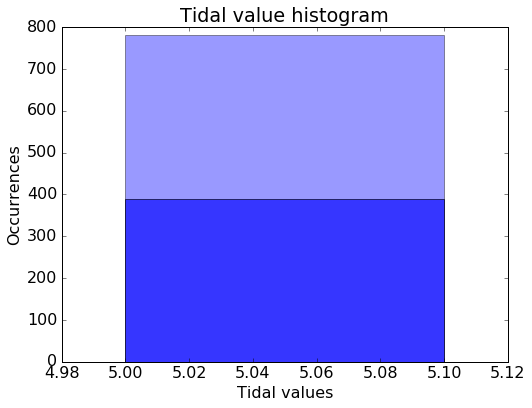

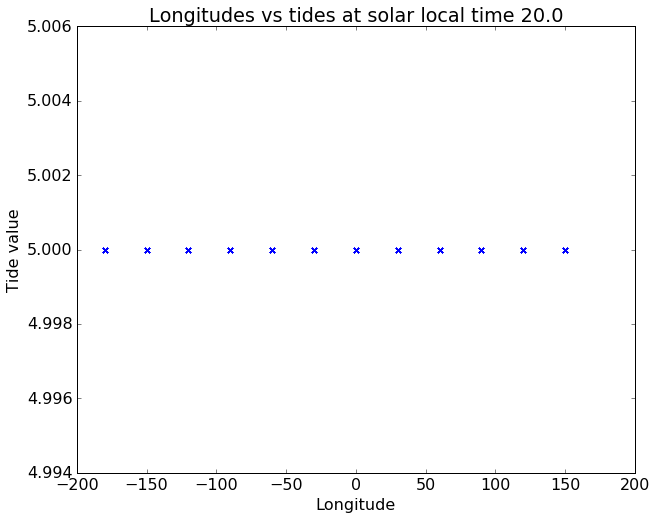

In [16]:
# MY DATA
# tides n=1, s=1 => tides11.txt

n = 1
s = 1
tides11 = generate_tides('2016-06-23', '2016-10-30', nRange=[n], sRange=[s], 
                          filename='tides11.txt')

print('This is the migrating solar diurnal tide, n={}, s={}.'.format(n,s))

plot_vs_slt(tides11, '20:00:00')#, lon=-120

1:16 pm

This doesn't look like what we expect (same values for same solar time). Each mark is another data point for a new date; if this plot was what we expect, we would not see an overall curve.

As a check, let's compare it to the solar tides from Lieberman's script's data. I'll make also a code that shows a histogram of number of points at a given value so we can see any stacking. We *do* want to see stacking.

(After making histogram: Each value in the tidal data appears only once (see histogram).)

This is the migrating solar diurnal tide, n=1, s=1.


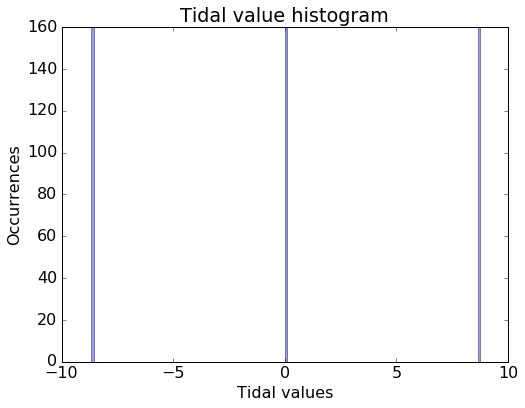

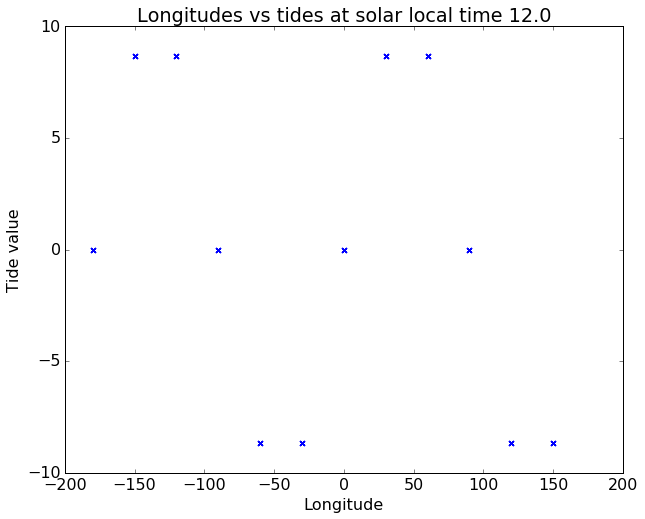

In [21]:
# LIEBERMAN'S DATA

print('This is the migrating solar diurnal tide, n={}, s={}.'.format(n,s))

testdata = np.loadtxt('x_sl.dat', skiprows=1)
plot_vs_slt(testdata, '12:00:00')

So, Hagan's data looks more reasonable. There are three possible unique tidal values, but there are a lot of each of them. The values are equal to *A*, *-A* and 0. This seems reasonable. These are only solar tidal values, though. My data includes cumulative tides; what happens if we make a similar plot for Hagan's data using the cumulative?

This is the migrating solar diurnal tide, n=1, s=1.


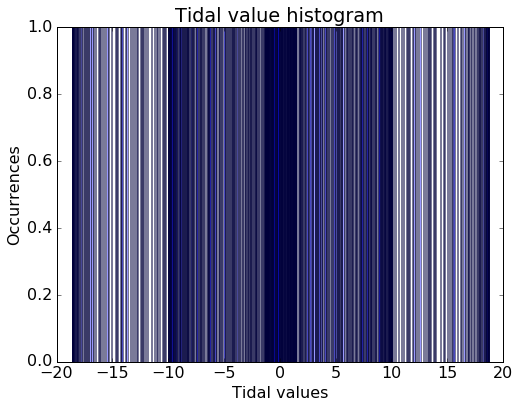

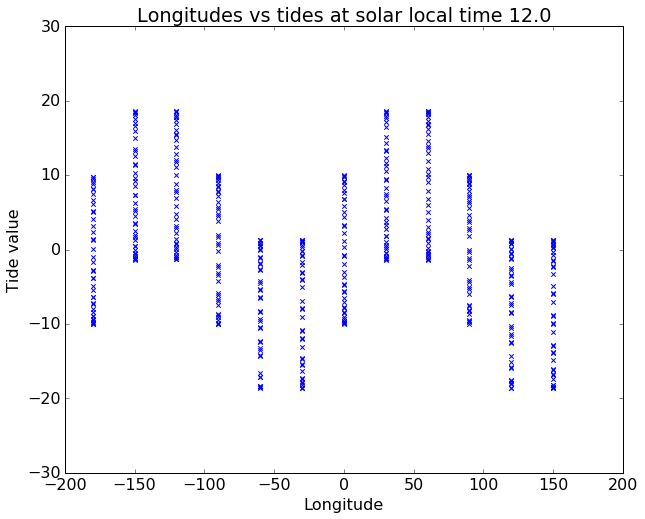

In [22]:
# LIEBERMAN'S DATA 2

print('This is the migrating solar diurnal tide, n={}, s={}.'.format(n,s))

testdata = np.loadtxt('x_sl.dat', skiprows=1)

combined = np.array(testdata)
combined = np.delete(combined, 7, 1)
combined[:,6] = testdata[:,6] + testdata[:,7]

plot_vs_slt(combined, '12:00:00')

Ah--then we get something very similar. So either my method is wrong or this is the expected behavior when examining the total tidal variations by solar local time. I think it's probably the latter.

Oh, I've figured something else out-- my code includes lunar contributions all the time. That's why I'm getting the additive appearance of the tidal values despite choosing a specific *n* and *s*. I should ask Astrid about this.

## Notes from meeting with Astrid

It's LIEBERMAN's script, not Hagan's. Oops.

Note: Things were a bit wonky with the plots because the n and s are actually separate, not married together for both solar and lunar parts. Need to keep these separate!

How to solve for UT: UT = SLT - long/15°

We can examine the solar semidiurnal migrating tide and identify it by the fact that it should move westward (toward negative longitudes) about 15° per hour. (that's also the conversion for time zones, incidentally, that's how we know it's the same speed as sun). 

Some non-migrating tides to check out:
* DW2: Diurnal westward diurnal nonmigrating tide. (n=1, s=2)
* DE3: Diurnal eastward diurnal nonmigrating tide. (n=1, s=-3)

The sign on *s* gives you the direction of propagation. Generally it is as above but it may change from researcher to researcher, it's just a convention.

Suggestion for slide: show SW2 and M2 separately and then show over one lunar cycle. Should see that they are sometimes in sync and sometimes not in sync. One lunar cycle = about 29 days. (look up the value.)

Result slide suggestion: Do something similar, show we need lots of time, not just one day.

Fitting question: Yes, we will fit the generating equation to the data. Can do so using χ². 

Comparing methods (later):
- Can compare to Astrid's script that only does χ² without the solar average subtraction
- Try adding the 16 day planetary waves, compare to that; if bias exists, maybe interesting, maybe publish.

4:29 pm

I haven't been making many updates under this date header but that's because I was doing all the work in the previous day where the code was. It is now pretty good and cleaned up and I have installed the gifs of the tides. I will paste them below and then move to the M2 tides!

In [5]:
#============================================================================#
# Show solar semidiurnal migrating tide
#============================================================================#

n = 2
s = 2
tides222 = generate_tides('2016-06-23', '2016-06-24', nRange=[n], sRange=[s], 
                          filename='tides222.txt')

print('This is the solar semidiurnal tide, n={}, s={}.'.format(n,s))

for h in range(0,24):
    plot_vs_long(tides222, '2016-06-23', '{}:00:00'.format(h), 'save', 
                 'Solar semidiurnal migrating tide', 'orange')

# Create gif of tide
!convert -delay 25 -loop 0 *.png SW2_mig.gif
!rm *.png

This is the solar semidiurnal tide, n=2, s=2.


From this, we can see that there are two maxima and minima, just as s=2 predicts, and that it moves westward at 15° per hour.

In [24]:
#============================================================================#
# Show solar diurnal nonmigrating tide
#============================================================================#

n = 1
s = 2
tides122 = generate_tides('2016-06-23', '2016-06-24', nRange=[n], sRange=[s], 
                          filename='tides122.txt')

print('This is the non-migrating solar diurnal tide, n={}, s={}.'.format(n,s))

for h in range(0,24):
    plot_vs_long(tides122, '2016-06-23', '{}:00:00'.format(h), 'save', 
                 'Solar diurnal non-migrating tide', 'orange')

# Create gif of tide
!convert -delay 25 -loop 0 *.png DW2_nonmig.gif
!rm *.png

This is the non-migrating solar diurnal tide, n=1, s=2.


## M2 plots

In [25]:
#============================================================================#
# Show lunar semidiurnal migrating tide
#============================================================================#

n = 2
s = 2
tidesM2 = generate_tides('2016-06-23', '2016-06-24', nRange=[n], sRange=[s], 
                          filename='tidesM2.txt', component='lunar')

print('This is the lunar semidiurnal tide, n={}, s={}.'.format(n,s))

for h in range(0,24):
    plot_vs_long(tidesM2, '2016-06-23', '{}:00:00'.format(h), 'save', 
                 'Lunar semidiurnal migrating tide', 'deepskyblue')

# Create gif of tide
!convert -delay 25 -loop 0 *.png M2_mig.gif
!rm *.png

This is the lunar semidiurnal tide, n=2, s=2.


This lunar tide seems to be moving as fast as the solar semidiurnal tide, which seems right since they have about the same period. But now that I look at it I'm not sure if it's quite right. It almost appears to be moving at greater than 15° longitude per hour. Is that actually so? 

If I just eyeball it, one of the minima takes 3 steps between λ = 0 and λ = -50 (inclusive to -50, exclusive to 0). 50 / 3 = 16.6, so yeah, that seems about right.

In [26]:
#============================================================================#
# Show lunar diurnal migrating tide
#============================================================================#

n = 1
s = 2
tidesM1 = generate_tides('2016-06-23', '2016-06-24', nRange=[n], sRange=[s], 
                          filename='tidesM1.txt', component='lunar')

print('This is the lunar diurnal tide, n={}, s={}.'.format(n,s))

for h in range(0,24):
    plot_vs_long(tidesM1, '2016-06-23', '{}:00:00'.format(h), 'save', 
                 'Lunar diurnal migrating tide', 'deepskyblue')

# Create gif of tide
!convert -delay 25 -loop 0 *.png M1_mig.gif
!rm *.png

This is the lunar diurnal tide, n=1, s=2.


<img src="M1_mig.gif" />

/home/emc/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:311: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


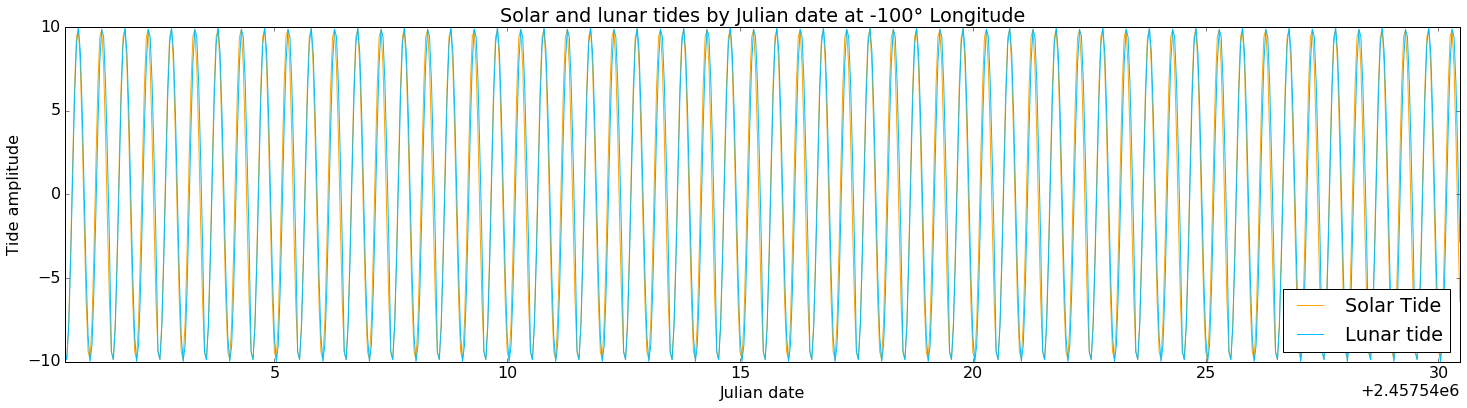

In [6]:
#============================================================================#
# Show solar and lunar semidiurnal migrating tides on top of each other
#============================================================================#

n = 2
s = 2
solar = generate_tides('2016-06-01', '2016-06-30', nRange=[n], sRange=[s], 
                          filename='solar30.txt', component='solar')

lunar = generate_tides('2016-06-01', '2016-06-30', nRange=[n], sRange=[s], 
                          filename='lunar30.txt', component='lunar')

plot_vs_date(solar, -100, 'Solar and lunar tides', data2=lunar, 
             c=['orange','deepskyblue'], lb=['Solar Tide', 'Lunar tide'], 
             mode='both')

Again, this is not quite right because they line up perfectly. **How to account for the lunar period difference?**

## Summary

<p><font color="#9944FF">The lunar semidiurnal tide is the same data as the solar semidiurnal, now that I'm using the equations in the way I am...</p>

**<p>How do I account for the moon's period?</font></p>**

TO DO - Engine creation & building understanding
1. <s>Finish the plot by time function</s>
2. <s>Finish Astrid's list of tasks for solar</s>
3. <s>Finish Astrid's list of tasks for lunar</s>
4. Finish reading papers and various accumulated articles

TO DO - Part A
1. Use synthetic generated data to do the binning and subtracting of solar local time
2. Use results to bin by lunar local time
3. Compare results to input lunar information
4. Go through numbered steps in part A - varying various parameters

TO DO - Part B
1. Use engine to analyze TIME-GCM results

<p><font color="#0077FF">Tonight I will read papers and articles, then tomorrow will be for doing the Part A work.</font></p>

# 28 June 2016

First order of business is to figure out how to make it so the equations give a slightly different lunar period. Then part A work

10:36 am

Fixed problems with lack of period differentiation. It was because we needed to put in the period and local times like this:

    if component=='solar':     # solar contribution
        tide += S * cos((2*pi*n/24)*slt - s*l + phi[n-1,s+6])
    elif component=='lunar':   # lunar contribution
        tide += L * cos((2*pi*n/24.84)*llt - s*l + phi[n-1,s+6])


10:58 am

Oh yeah, I didn't exactly read the papers either. Later today.

Note: The equations above either give a good graph for the two overlaid or good animations but not both.

## Still fixing stuff

Notes talking with Astrid

Correct equations are as below:

    if component=='solar':     # solar contribution
        # DO NOT CHANGE-----------------------------------
        tide += S * cos((2*pi*n/24)*hr + s*l - phi[n-1,s+6])
        #-------------------------------------------------
    elif component=='lunar':   # lunar contribution
        tide += L * cos((2*pi*n/24.84)*(hr-nuHrs) + s*l - phi[n-1,s+6])
       
We have to subtract the moon phase from the universal time for the lunar component - Astrid figured this out.
                            
It may be easier to use 15° for longitude division because that will match with hours.



In [2]:
def jd_to_date(jd):    
    '''
    Converts Julian date to Gregorian date.
    From Astronomical Algorithms, Jean Meeus, 1991.
    '''
    import math

    j = jd + 0.5
    z = math.trunc(j)
    f = j - z

    if z < 2299161:
        A = z
    else:
        alpha = int((z - 1867216.25)/36524.25)
        A = z + 1 + alpha - int(alpha/4)

    B = A + 1524
    C = int((B - 122.1)/365.25)
    D = int(365.25 * C)
    E = int((B - D)/30.6001)

    day = B - D - int(30.6001 * E)
    month = E - 1 if E < 14 else E - 13
    year = C - 4716 if month > 2 else C - 4715

    # added by me to calculate hours, minutes, seconds.
    h = int(f * 24)
    m = int((f * 24 - int(h)) * 60)
    s = int((((f * 24 - int(h)) * 60) - m) * 60)

    return year, month, day, h, m, s

def date_to_jd(date, time):    
    '''
    Converts Gregorian date to Julian date given the format:
    date = YYYY-MM-DD, time = HH:MM:SS
    From Astronomical Algorithms, Jean Meeus, 1991.
    '''
    
    x = time.split(':')
    x = [int(xi) for xi in x]
    s = x[2]
    mi = x[1]
    h = x[0]
    f = h/24 + mi/(60*24) + s/3600
    
    sign = 1
    if date[0] == '-':
        date = date[1:]
        sign = -1
    x = date.split('-')
    x = [int(xi) for xi in x]
    d = x[2]
    mo = x[1]
    y = sign * x[0]
    
    earlyOct1582 = (y==1582 and mo<=10 and d < 15)
    early1582 = (y==1582 and mo<= 9)
    anytimeBefore = (y < 1582)
    
    if earlyOct1582 or early1582 or anytimeBefore:
        flag = 'J'
    else: 
        flag = 'G'

    if mo == 1 or mo == 2:
        y = y - 1
        mo = mo + 12
    
    A = int(y / 100)
    B = 2 - A + int(A / 4) if flag=='G' else 0

    jd = int(365.25 * (y + 4716)) + int(30.6001 * (mo + 1)) + d + B - 1524.5 + f
    
    jd = float('{:.4f}'.format(jd))
    return jd

def get_moon_phase(now):
    '''
    Calculate moon phase for a given Julian date.(cf. Chapman & Linzen)
    ---INPUT---
        now: a Julian date, including hours, minutes, seconds.
    ---OUTPUT---
        nuHrs: Phase of the moon in hours
    '''
    from math import pi
    
    ref = date_to_jd('1899-12-31', '12:00:00')
    T = (now - ref) / 36525
    nu = -9.26009 + 445267.12165*T + 0.00168*(T**2)
    ageDeg = nu % 360
    nuRad = ageDeg * pi / 180
    nuHrs = (nu/15) % 24
    return nuHrs

def generate_tides(startDate, endDate, amps, phase, longIncr=15, nRange=range(1,3), 
                   sRange=range(-6,7), filename='tides.txt', component='solar'):
    '''
    Generates tidal data using the equation:
    A + ΣΣS_{ns}*cos[Ωnt + sλ - Φ_{ns}] + ΣΣL_{ns}*cos[Ωnt + sλ - Φ_{ns}]
    for specified amplitudes and phases. 
    This function is altitude and latitude independent (***???)
    where 
        A = amplitude
        n = 2nd harmonic (semidiurnal variation)
        s = zonal wavenumber (maxes and mins along a line of longitude)
            s = 2 => migrating tide
            s = 3 => non-migrating tide
        t = universal time at Greenwich Meridian
        λ = longitude
        Φ = phase
    --INPUT--
        startDate       a start date, format '2016-06-21'
        endDate         an end date, format '2016-06-30'
        amps            List of amplitude values (length = 3).
        phase           info about whether to vary phase or keep it cosntant
        nRange          values of n to use in calculation
        sRange          values of s to use in calculation
        filename        filename to write values to
        component       solar, lunar, s+l (solar+lunar) or all; specifies 
                        summation bounds for n and s
    --OUTUT--
        Tidal data in array of format:
        Solar local time - Lunar local time - Longitude - Solar Julian date - 
        Lunar Julian date - Hour of day - Moon phase in hours - Tidal value
        
    Adapted from script by Dr. Ruth Lieberman by Eryn Cangi for LASP REU 2016.
    '''
    from math import pi, cos
    
    # VARIABLES --------------------------------------------------------------
    A = amps[0]                    # Background amplitude
    S = amps[1]                    # Solar amplitude
    L = amps[2]                    # Lunar amplitude
    if phase=='C':                 # Phases (Φ_{n,s})
        phi = 0
    else:
        phi = lambda t: cos(t + pi/2)
    hoursPerDay = 24 
     
    # DEFINE LONGITUDE GRID --------------------------------------------------
    numLongs = 360 // longIncr
    longs = np.asarray([l*pi/180 for l in list(range(-180, 180, longIncr))])
    W = 2*pi/24                   # Earth rotation rate (omega)
    
    # GET JULIAN DATES -------------------------------------------------------
    ti = date_to_jd(startDate, '00:00:00')
    tf = date_to_jd(endDate, '00:00:00')
    numDays = int(tf - ti) + 1 # +1 to include the last day in the loops
    
    # MAKE OUTPUT ARRAY ------------------------------------------------------
    rows = numLongs * 24 * numDays
    output = np.empty([rows,7])
    r=0
    
    # LOOP THROUGH TIMESPAN (DAYS) ===========================================
    for day in range(numDays):    # + makes inclusive: calculates for last day
        curJulDate = ti + day
        
        # GET REGULAR DATE FOR CALCULATIONS ----------------------------------
        yr, mo, d, h, minute, sec = jd_to_date(curJulDate) 
        curRegDate = '{}-{:>02}-{:>02}'.format(yr, mo, d)
        curRegHour = h
        
        # LOOP THROUGH HOURS IN DAY ==========================================
        for hr in range(hoursPerDay):        
            
            # UPDATE HOUR, GET NEW JULIAN DATE -------------------------------
            curRegHour = 0 + hr
            curRegTime = '{:>02}:{:>02}:{:>02}'.format(curRegHour, minute, sec)
            newJD = date_to_jd(curRegDate, curRegTime)
            
            # GET MOON PHASE AT THIS HOUR ------------------------------------
            nuHrs = get_moon_phase(newJD)
            
            # LOOP OVER LONGITUDES ===========================================
            for l in longs:
                # CALCULATE SOLAR LOCAL TIME ---------------------------------
                slt = hr + l/W
                if slt < 0:            # Wrap around behavior, Earth = sphere
                    slt = slt + 24
                elif slt > 24:
                    slt = slt - 24
                else:
                    pass

                # CALCULATE LUNAR LOCAL TIME ---------------------------------
                llt = slt - nuHrs
                llt = llt + 24 if llt < 0 else llt
                
                # CALCULATE THE TIDES ----------------------------------------
                
                # Assign amplitudes
                # Background
                if type(A)==int:
                    tide = A
                else:
                    tide = A(hr,l)
                    
                # Solar
                if type(S)==int:
                    A_S = S
                else:
                    A_S = S(hr,l)
                    
                # Lunar
                if type(L)==int:
                    A_L = L
                else:
                    A_L = L(hr,l)
                    
                # Assign phase 
                if type(phi)==int:
                    p = phi
                else:
                    p = phi(hr)
                    
                for n in nRange:
                    for s in sRange:
                        if component=='solar':     # solar contribution
                            # DO NOT CHANGE-----------------------------------
                            tide += A_S * cos((2*pi*n/24)*hr + s*l - p)
                            #-------------------------------------------------
                        elif component=='lunar':   # lunar contribution
                            tide += A_L * cos((2*pi*n/24)*(hr-nuHrs) + s*l - p)
                            
                        elif component=='s+l':
                            tide += A_S*cos((2*pi*n/24)*hr + s*l - p) \
                                  + A_L*cos((2*pi*n/24)*(hr-nuHrs) + s*l - p)
                output[r,0] = slt
                output[r,1] = llt
                output[r,2] = round(l * 180/pi)
                output[r,3] = newJD
                output[r,4] = hr
                output[r,5] = nuHrs
                output[r,6] = tide
                r += 1

    # FORMAT HEADER LINE, WRITE FILE -----------------------------------------
    cells = '{:^20}'*7            
    line0 = cells.format('Solar local time', 'Lunar local time', 'Longitude', 
                        'Julian Date', 'Hour', 'Moon phase (hrs)', 'Tide')
    np.savetxt(filename, output, fmt='%.4f', delimiter='\t', header=line0)
    
    return output

def bin_by_solar(data):
    '''
    Finds the mean of the solar contribution at a given solar local time.
    Writes a file of means for each pair of a unique solar local time and
    longitude.
    ---INPUT---
        data        Array of tidal data
    ---OUTPUT---
        means       3-column array, columns: solar local time, longitude,
                    mean solar contribution.
    '''

    means = []

    # FIND UNIQUE SOLAR LOCAL TIMES ------------------------------------------
    slt = np.ndarray.tolist(data[:,0])
    unique_slt = set([round(x,4) for x in slt])

    # ITERATE OVER SOLAR LOCAL TIMES & LONGITUDES ----------------------------
    for val in unique_slt:
        for lon in range(-180, 190, 15):
            sltSlice = data[np.where(data[:,0] == val)]
            sltSlice = sltSlice[np.where(sltSlice[:,2]==lon)]
            if sltSlice.size != 0:
                means.append([val, lon, np.mean(sltSlice[:,6])])
                
    means = np.asarray(means)
        
    line0 = 'Solar Local Time\tLongitude\tMean Solar Tide\n'
    np.savetxt('slt_bin.txt', output, delimiter='\t', header=line0)

    return means

def plot_vs_long(data, date, time, flag, title, c):
    '''
    Plots tidal value versus longitude for a specified Julian date
    ---INPUT---
        data        Array of tidal data
        date        date in format YYYY-MM-DD
        time        time in format HH:MM:SS
        flag        'save' or 'show', controls how the plot is handled.
        title       descriptive plot title
        c           plot line color. Just for aesthetics.
    ---OUTPUT---
        A plot
    '''
    
    
    JDdate = date_to_jd(date, time)

    # FIND ROWS IN DATA ARRAY WITH MATCHING DATE -----------------------------
    # Because data for a particular Julian date is all grouped together, the 
    # values in rows[0] (the indices) will be consecutive.
    rows = np.where(data[:,3]==JDdate)[0]
    i = rows[0]
    f = rows[-1]
    longs = data[i:f,2]
    tides = data[i:f,6]
    
    # PLOT -------------------------------------------------------------------
    plt.figure(figsize=(10,8))
    plt.plot(longs, tides, color=c, marker=r'$\bigodot$', markersize=12)
    plt.title('{}, {} at {}'.format(title, date, time))
    plt.xlabel('Longitude')
    plt.ylabel('Tide amplitude') # what actually is the units of this?
    plt.rcParams.update({'font.size': 16})
    
    if flag=='show':
        plt.show()
        plt.close()
    elif flag=='save':
        fn = 'tides_d{}_{:>02}.png'
        plt.savefig(fn.format(date, time.split(':')[0]), bbox_inches='tight')
        plt.clf()
        plt.close()
    
    
    
    
def plot_vs_date(data, long, title, data2=None, c=None, m=None, 
                 lb=None, mode='show'):
    '''
    Plots tidal values over time at a particular longitude.
    ---INPUT---
        data        Array of tidal data
        long        Longitude to examine
        title       descriptive plot title
        data2       Optional second data to plot if stacking two tides
        c           color list, has two elements if stacking.
        m           marker shape to use
        lb          Plot legend elements
        mode        Whether to save or show the figure. Default 'show'
    ---OUTPUT---
        A plot
    '''
    
    if data2 != None:
        stack = True
    else: 
        stack = False
        
    # FIND ROWS IN ARRAY WITH MATCHING LONGITUDE -----------------------------
    rows = np.where(data[:,2]==long)[0]
    times = [data[i, 3] for i in rows]
    tides = [data[i, 6] for i in rows]
    
    if stack:
        tides2 = [data2[i,6] for i in rows]
    

    # PLOT -------------------------------------------------------------------
    plt.figure(figsize=(25,6))
    s = len(times)                           # set a limit for plotting
    
    if stack:
        plt.plot(times[:s], tides[:s], color=c[0], marker=m, label=lb[0])
        plt.plot(times[:s], tides2[:s], color=c[1], marker=m, label=lb[1])
        plt.legend(loc='lower right')
    else:
        plt.plot(times, tides, marker=m)
    plt.title('{} by Julian date at {}° Longitude'.format(title, long))
    plt.xlim([min(times),max(times)])
    plt.xlabel('Julian date')
    plt.ylabel('Tide amplitude') # what actually is the units of this?
    plt.rcParams.update({'font.size': 16})
    
    if mode=='show':
        plt.show()
        plt.close()
    elif mode=='save':
        fn = '{} by Julian date at {}° Longitude'.format(title, long)
        plt.savefig(fn, bbox_inches='tight')
        plt.close()
    elif mode=='both':
        fn = '{} by Julian date at {}° Longitude'.format(title, long)
        plt.savefig(fn, bbox_inches='tight')
        plt.show()
        plt.clf()
        plt.close()

def plot_vs_slt(data, time):
    '''
    Plots tidal value versus solar local time
    ---INPUT---
        data        Array of tidal data
        time        time in format HH:MM:SS
    ---OUTPUT---
        A plot
    '''
    
    # FORMAT SLT -------------------------------------------------------------
    time_els = time.split(':')
    time_els = [float(s) for s in time_els]
    time = time_els[0] + time_els[1] / 60 + time_els[2] / 3600

    # CHECK FOR BADLY FORMATTED DECIMALS -------------------------------------
    if time % time_els[0] not in [0, 0.3333, 0.6667]:
        raise Exception('Bad time given')

    # FIND MATCHING SOLAR LOCAL TIMES IN DATA --------------------------------           
    rows = np.where(data[:,0]==time)[0]
    longs = [data[i,2] for i in rows]
    tides = [data[i,6] for i in rows]
    
    # PLOT--------------------------------------------------------------------
    plt.figure(figsize=(10,8))
    plt.scatter(longs,tides, marker='x')
    plt.title('Longitudes vs tides at solar local time {}'.format(time))
    plt.xlabel('Longitude')
    plt.ylabel('Tide value') # what actually is the units of this?
    plt.rcParams.update({'font.size': 16})
    plt.show()

## Animations

In [3]:
#============================================================================#
# Show solar semidiurnal migrating tide
#============================================================================#

n = 2
s = 2
tidesSW2 = generate_tides('2016-06-23', '2016-06-24', amps=[0,10,10], phase='C',
                          nRange=[n], sRange=[s],filename='tidesSW2.txt')

print('This is the solar semidiurnal tide, n={}, s={}.'.format(n,s))

for h in range(0,24):
    plot_vs_long(tidesSW2, '2016-06-23', '{}:00:00'.format(h), 'save', 
                 'Solar semidiurnal migrating tide', 'orange')

# Create gif of tide
!convert -delay 25 -loop 0 t*.png SW2_mig.gif
!rm *.png


This is the solar semidiurnal tide, n=2, s=2.


![test](SW2_mig.gif)


In [17]:
#============================================================================#
# Show solar diurnal nonmigrating tide
#============================================================================#

n = 1
s = 2
tidesDW2 = generate_tides('2016-06-23', '2016-06-24', nRange=[n], sRange=[s], 
                          filename='tidesDW2.txt')

print('This is the non-migrating solar diurnal tide, n={}, s={}.'.format(n,s))

for h in range(0,24):
    plot_vs_long(tidesDW2, '2016-06-23', '{}:00:00'.format(h), 'save', 
                 'Solar diurnal non-migrating tide', 'orange')

# Create gif of tide
!convert -delay 25 -loop 0 *.png DW2_nonmig.gif
!rm *.png

This is the non-migrating solar diurnal tide, n=1, s=2.


![DW2](DW2_nonmig.gif)

In [4]:
#============================================================================#
# Show lunar semidiurnal migrating tide
#============================================================================#

n = 2
s = 2
tidesM2 = generate_tides('2016-06-23', '2016-06-24', nRange=[n], sRange=[s], 
                          filename='tidesM2.txt', component='lunar')

print('This is the lunar semidiurnal tide, n={}, s={}.'.format(n,s))

for h in range(0,24):
    plot_vs_long(tidesM2, '2016-06-23', '{}:00:00'.format(h), 'save', 
                 'Lunar semidiurnal migrating tide', 'deepskyblue')

# Create gif of tide
!convert -delay 25 -loop 0 *.png M2_mig.gif
!rm *.png

This is the lunar semidiurnal tide, n=2, s=2.


![M2](M2_mig.gif)

/home/emc/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:343: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


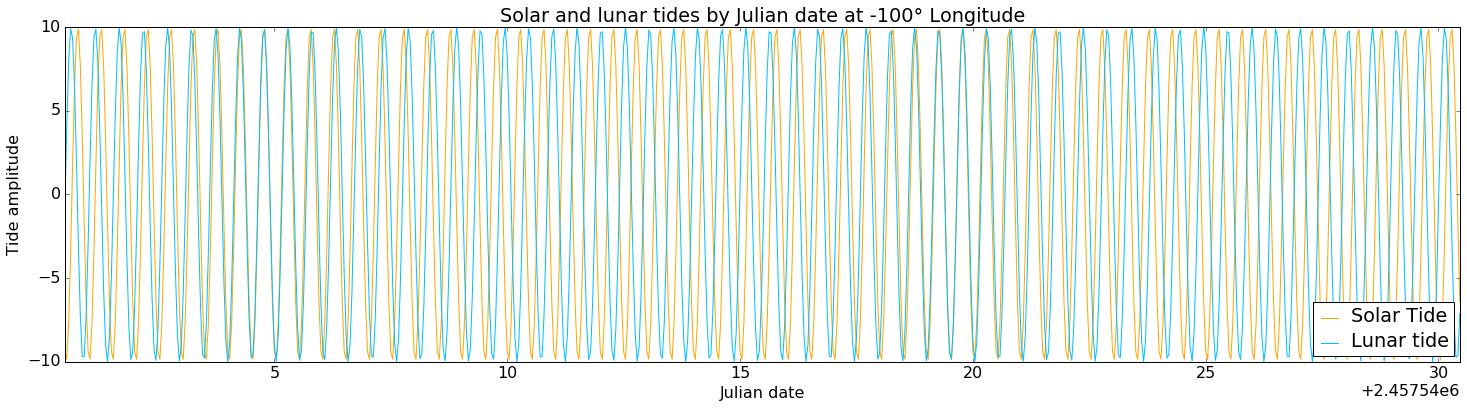

In [3]:
#============================================================================#
# Show solar and lunar semidiurnal migrating tides on top of each other
#============================================================================#

n = 2
s = 2
solar = generate_tides('2016-06-01', '2016-06-30', amps=[0,10,10], phase='C',
                       nRange=[n], sRange=[s], filename='solar30.txt', 
                       component='solar')

lunar = generate_tides('2016-06-01', '2016-06-30', amps=[0,10,10], phase='C',
                       nRange=[n], sRange=[s], filename='lunar30.txt', 
                       component='lunar')

plot_vs_date(solar, -100, 'Solar and lunar tides', data2=lunar, 
             c=['orange','deepskyblue'], lb=['Solar Tide', 'Lunar tide'], 
             mode='both')

## Verification: Same tidal value for same solar local time at any longitude

We expect the values to be the same across solar local time.

This is the migrating solar diurnal tide, n=1, s=1.


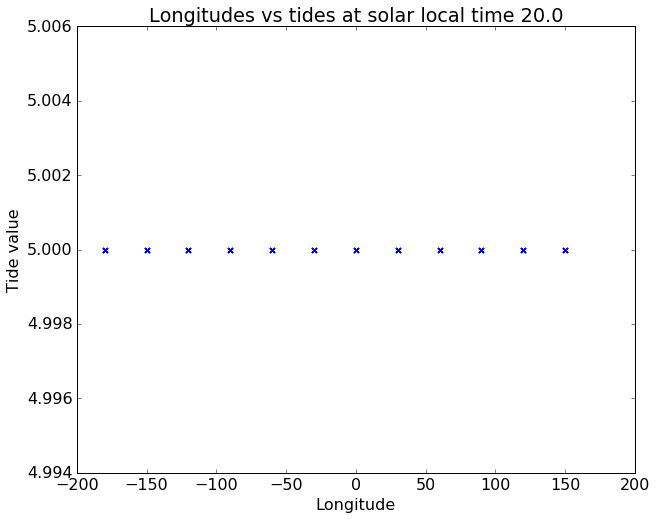

In [5]:
# tides n=1, s=1 => tides11.txt

n = 1
s = 1
tides11 = generate_tides('2016-06-01', '2016-07-30', amps=[0,10,10], phase='C',
                         nRange=[n], sRange=[s], filename='tides_const_value.txt')

print('This is the migrating solar diurnal tide, n={}, s={}.'.format(n,s))

plot_vs_slt(tides11, '20:00:00')

## Generating SW2 and M2

### 1. no background and constant amplitude and phase

Will start this after lunch. Now it's 12:30 pm

1:45 pm

Generating the data.

In [3]:
#============================================================================#
# Generate SW2 data
# Background = 0
# Constant amplitude and phase
#============================================================================#
data1S = generate_tides('2016-01-01', '2016-03-31', amps=[0,10,10], phase='C',
                        nRange=[2], sRange=[2], filename='SW2_0bg_CACP.txt', 
                        component='solar')

#============================================================================#
# Generate M2 data
# Background = 0
# Constant amplitude and phase
#============================================================================#
data1L = generate_tides('2016-01-01', '2016-03-31', amps=[0,10,10], phase='C',
                        nRange=[2], sRange=[2], filename='M2_0bg_CACP.txt', 
                        component='lunar')

#============================================================================#
# Generate total data
# Background = 0
# Constant amplitude and phase
#============================================================================#
data1T = generate_tides('2016-01-01', '2016-03-31', amps=[0,10,10], phase='C',
                        nRange=[2], sRange=[2], filename='TT_0bg_CACP.txt', 
                        component='s+l')


### 2. varying background  and constant amplitude and phase 

For this, let's assume that the varying background is some function of UT and longitude, but without specifying much more than that.

In [4]:
#============================================================================#
# Generate SW2 data
# Background = varies
# Constant amplitude and phase
#============================================================================#
from math import pi, cos
A = lambda t,l: 3*cos(2*pi*t/24 + l)

data2S = generate_tides('2016-01-01', '2016-03-31', amps=[A,10,10], phase='C',
                        nRange=[2], sRange=[2], filename='SW2_Vbg_CACP.txt',
                        component='solar')

#============================================================================#
# Generate M2 data
# Background = varies
# Constant amplitude and phase
#============================================================================#
data2L = generate_tides('2016-01-01', '2016-03-31', amps=[A,10,10], phase='C',
                        nRange=[2], sRange=[2], filename='M2_Vbg_CACP.txt', 
                        component='lunar')

#============================================================================#
# Generate total data
# Background = varies
# Constant amplitude and phase
#============================================================================#
data2T = generate_tides('2016-01-01', '2016-03-31', amps=[A,10,10], phase='C',
                        nRange=[2], sRange=[2], filename='TT_Vbg_CACP.txt', 
                        component='s+l')

### 3. constant background  and varying SW2 amplitude and phase

In [5]:
#============================================================================#
# Generate SW2 data
# Background = constant
# Variable SW2 amplitude and phase
#============================================================================#
S = lambda t,l: 10*cos(2*pi*t/24 + l)

data3S = generate_tides('2016-01-01', '2016-03-31', amps=[3,S,10], phase='V',
                        nRange=[2], sRange=[2], filename='SW2_Cbg_VSW2_solar.txt', 
                        component='solar')

#============================================================================#
# Generate M2 data
# Background = constant
# Variable SW2 amplitude and phase
#============================================================================#
data3L = generate_tides('2016-01-01', '2016-03-31', amps=[3,S,10], phase='C',
                        nRange=[2], sRange=[2], filename='M2_Cbg_VSW2_lunar.txt', 
                        component='lunar')

#============================================================================#
# Generate M2 data
# Background = constant
# Variable SW2 amplitude and phase
#============================================================================#
data3T = generate_tides('2016-01-01', '2016-03-31', amps=[3,S,10], phase='C',
                        nRange=[2], sRange=[2], filename='TT_Cbg_VSW2.txt', 
                        component='s+l')


### 4. constant background  and varying M2 amplitude and phase

In [6]:
#============================================================================#
# Generate SW2 data
# Background = constant
# Variable M2 amplitude and phase
#============================================================================#
L = lambda t,l: 10*cos(2*pi*t/24 + l)

data4S = generate_tides('2016-01-01', '2016-03-31', amps=[3,10,L], phase='V',
                        nRange=[2], sRange=[2], filename='M2_Cbg_VM2_solar.txt', 
                        component='solar')

#============================================================================#
# Generate M2 data
# Background = constant
# Variable M2 amplitude and phase
#============================================================================#
data4L = generate_tides('2016-01-01', '2016-03-31', amps=[3,10,L], phase='C',
                        nRange=[2], sRange=[2], filename='M2_Cbg_VM2_lunar.txt', 
                        component='lunar')

#============================================================================#
# Generate M2 data
# Background = constant
# Variable M2 amplitude and phase
#============================================================================#
data4T = generate_tides('2016-01-01', '2016-03-31', amps=[3,10,L], phase='C',
                        nRange=[2], sRange=[2], filename='TT_Cbg_VM2.txt', 
                        component='s+l')

## New versions of binning, removal functions

In [51]:
def bin_by_solar(data, filename):
    '''
    Finds the mean of the solar contribution at a given solar local time.
    Writes a file of means for each pair of a unique solar local time and
    longitude.
    ---INPUT---
        data        Array of tidal data
        filename    Name for output file
    ---OUTPUT---
        means       3-column array, columns: solar local time, longitude,
                    mean solar contribution.
    '''

    means = []

    # FIND UNIQUE SOLAR LOCAL TIMES ------------------------------------------
    slt = np.ndarray.tolist(data[:,0])
    unique_slt = set([round(x,4) for x in slt])

    # ITERATE OVER SOLAR LOCAL TIMES & LONGITUDES ----------------------------
    for val in unique_slt:
        for lon in range(-180, 190, 15):
            sltSlice = data[np.where(data[:,0] == val)]
            sltSlice = sltSlice[np.where(sltSlice[:,2]==lon)]
            if sltSlice.size != 0:
                means.append([val, lon, np.mean(sltSlice[:,6])])
                
    means = np.asarray(means)
        
    line0 = 'Solar Local Time\tLongitude\tMean Solar Tide'
    np.savetxt('{}_slt_bin.txt'.format(filename), means, fmt='%.4f', delimiter='\t', 
               header=line0)

    return means
    
    
def remove_solar(c, binfile): 
    '''
    Subtract off the solar tidal averages. Iterates through the file holding 
    solar tidal average data per solar local time and longitude.
    --INPUT--
        c           Data table where columns are solar local time, lunar local time, 
                    longitude, lunar Julian date, hour, moon phase and total tidal 
                    value.
        binfile     Name of a file from which to read binned solar data
    --OUTPUT--
        result      Array holding original data for columns 0-5 and the 
                    "reconstructed" lunar tidal values in column 6
    '''
    
    # create new array to store subtracted values
    r = np.zeros([c.shape[0]])

    # For each file line, find row in c array where solar local time and 
    # longitude for each match. Then subtract the solar tidal data, given in 
    # the file, from combined tidal data in c and store in r
    with open(binfile, 'r') as sbin:
        head = next(sbin)              # takes care of header line
        for line in sbin:
            l = line.split()
            slt = float(l[0])
            lon = float(l[1])
            # find rows in c that match this line's values
            i = np.where((c[:,0]==slt) & (c[:,2]==lon))[0]
            r[i] = c[i,6] - float(l[2])
            
    # Create copy of original data array, replace tidal data with r
    copy = np.array(c)
    print(copy[0,:])
    copy = np.delete(copy, 6, 1)
    result = np.column_stack((copy, r))
            
    return result

def compare_with_plot(recon, original):
    '''
    Compare reconstructed data with original data over a small window to get 
    a sense of how well it matches.
    ---INPUT---
        recon: lunar tidal data versus some variable (doesn't matter)
        original: data that was fed into the synthetic model
    ---OUTPUT---
        a plot of the two overlaid
    '''

    x = np.arange(0, recon.shape[0])
    i = 477
    s = 350

    plt.figure(figsize=(18,6))
    plt.title('reconstructed lunar tides vs original data')
    plt.plot(x[i:i+s], original[i:i+s], color='blue', label='original lunar tide data')
    plt.plot(x[i:i+s], recon[i:i+s], color='red', label='reconstructed lunar tides')
    plt.xlabel('whatever')
    plt.ylabel('Value')
    plt.legend(loc='upper right')
    plt.rcParams.update({'font.size': 14})
    plt.show()

## Binning and subtracting analyzation

### Total tides, no background, constant amplitude and constant phase

In [14]:
data1T[:,6]

array([ 1.42690527,  3.80974314,  5.17176342, ...,  3.35956052,
        4.49560982,  4.4270641 ])

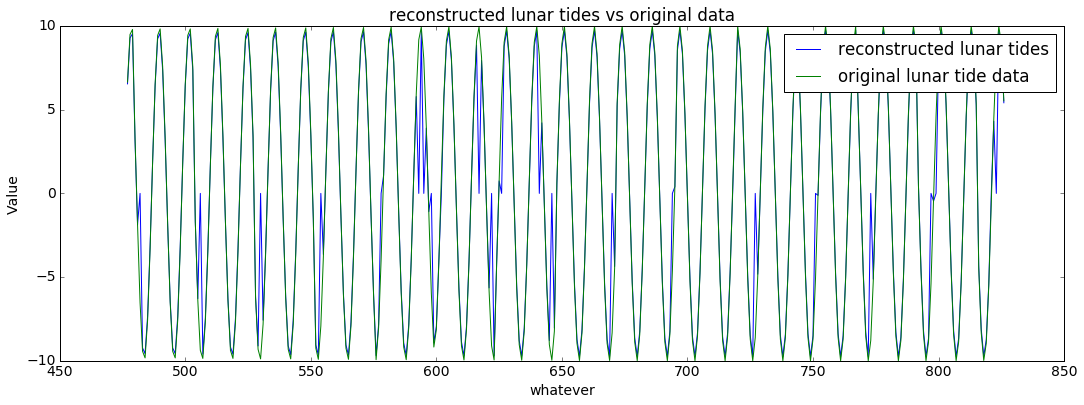

In [15]:
means1T = bin_by_solar(data1T, '0bg_CACP')
nosol1T = remove_solar(data1T, '0bg_CACP_slt_bin.txt')

# The following plot is done WITHOUT binning by LLT just to see how it looks.
compare_with_plot(nosol1T, data1L[:,6])

Interesting...

### Total tides, varying background  and constant amplitude and phase 

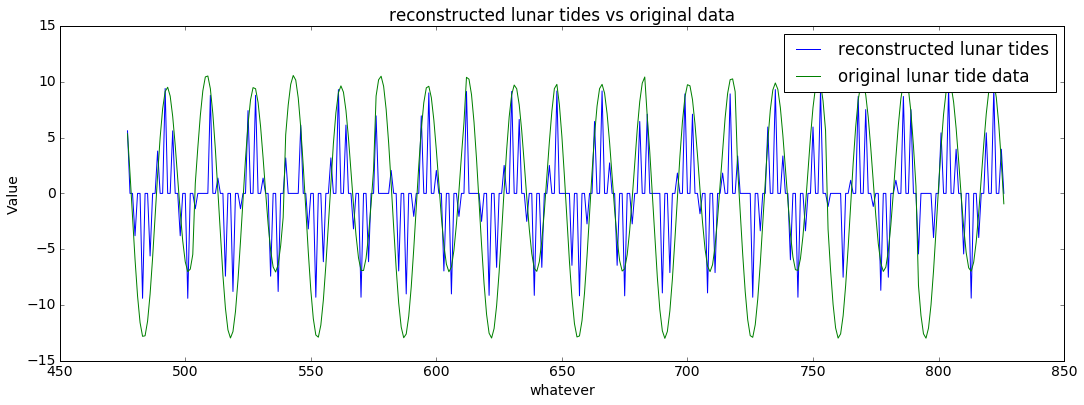

In [92]:
means2T = bin_by_solar(data2T, 'Vbg_CACP')
nosol2T = remove_solar(data2T, 'Vbg_CACP_slt_bin.txt')

# The following plot is done WITHOUT binning by LLT just to see how it looks.
compare_with_plot(nosol2T, data2L[:,6])

### Total tides, constant background  and varying SW2 amplitude and phase

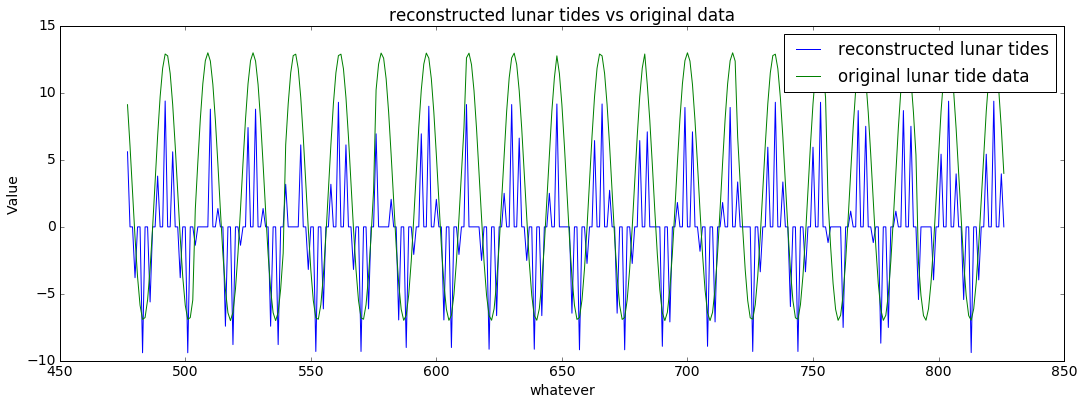

In [93]:
means3T = bin_by_solar(data3T, 'Cbg_VSW2')
nosol3T = remove_solar(data3T, 'Cbg_VSW2_slt_bin.txt')

# The following plot is done WITHOUT binning by LLT just to see how it looks.
compare_with_plot(nosol3T, data3L[:,6])

### Total tides, constant background  and varying M2 amplitude and phase

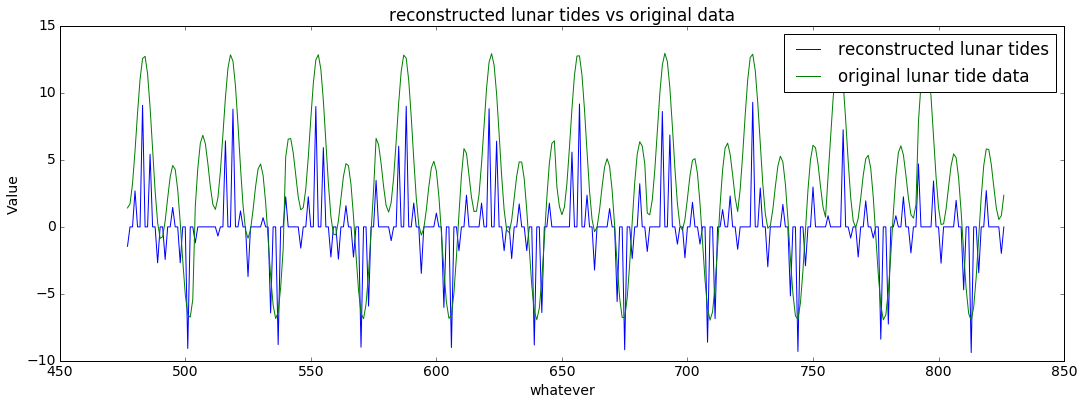

In [94]:
means4T = bin_by_solar(data4T, 'Cbg_VM2')
nosol4T = remove_solar(data4T, 'Cbg_VM2_slt_bin.txt')

# The following plot is done WITHOUT binning by LLT just to see how it looks.
compare_with_plot(nosol4T, data4L[:,6])

# 29 June 2016

First thing for today is to get a better graph of total tidal contributions for the presentation.

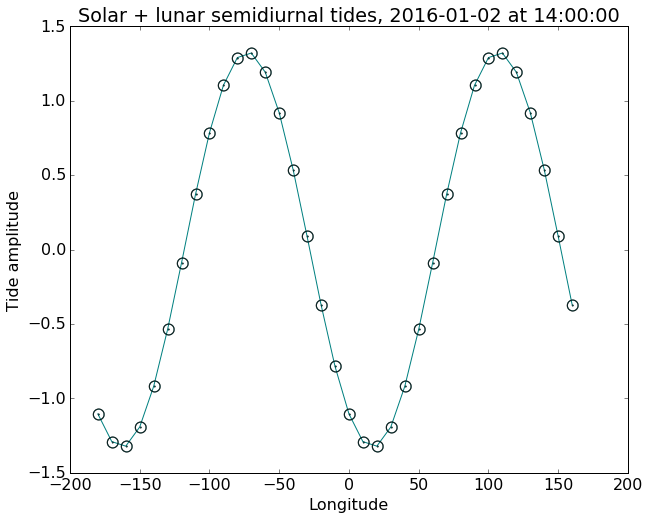

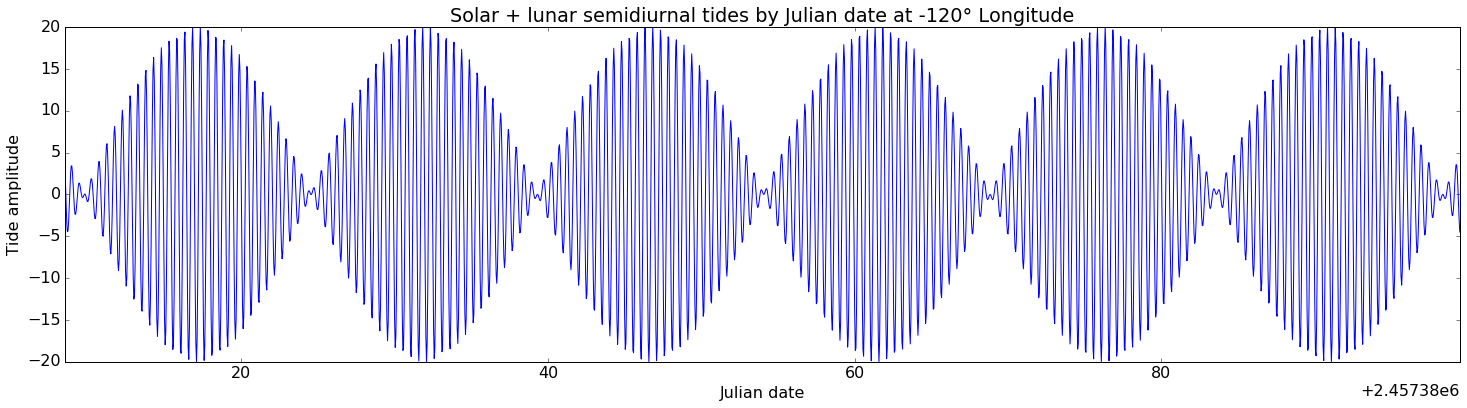

In [22]:
plot_vs_long(data1T, '2016-01-02', '14:00:00', 'show', 'Solar + lunar '
             'semidiurnal tides', 'teal')
plot_vs_date(data1T, -120, 'Solar + lunar semidiurnal tides', mode='both')

10 am

Now going to go over the math about the equations that Astrid sent.

## Afternoon

4:45 pm

Read some of a paper earlier, now coming back to this.

In [16]:
def bin_by_lunar(data, filename):
    '''
    Finds the mean of the solar contribution at a given solar local time.
    Writes a file of means for each pair of a unique solar local time and
    longitude.
    ---INPUT---
        data        Array of tidal data
        filename    Name for output file
    ---OUTPUT---
        means       3-column array, columns: solar local time, longitude,
                    mean solar contribution.
    '''

    means = []

    # FIND UNIQUE SOLAR LOCAL TIMES ------------------------------------------
    llt = np.ndarray.tolist(data[:,1])
    unique_llt = set([round(x,4) for x in llt])
    print(len(unique_llt))
    print(len(data[:,1]))

    # ITERATE OVER LUNAR LOCAL TIMES & LONGITUDES ----------------------------
    for val in unique_llt:
        for lon in range(-180, 190, 15):
            lltSlice = data[np.where(data[:,1] == val)]
            lltSlice = lltSlice[np.where(lltSlice[:,2]==lon)]
            if lltSlice.size != 0:
                means.append([val, lon, np.mean(lltSlice[:,6])])
                
    print('Done iterating over LLT...')
    
    means = np.asarray(means)
        
    line0 = 'Lunar Local Time\tLongitude\tMean Lunar Tide'
    np.savetxt('{}_llt_bin.txt'.format(filename), means, fmt='%.4f', delimiter='\t', 
               header=line0)

    return means

### Total tides, no background, constant amplitude and constant phase

In [21]:
# Bin by solar local time
means1T = bin_by_solar(data1T, '0bg_CACP')
print('Done with binning by solar')

# Subtract the averages according to solar local time
nosol1T = remove_solar(data1T, '0bg_CACP_slt_bin.txt')
print('Done with removing solar')

# Bin the results by lunar local time
result = bin_by_lunar(nosol1T, '1T')
print('Done with binning by lunar')

# The following plot is done WITHOUT binning by LLT just to see how it looks.
compare_with_plot(result[:,6], data1L[:,6])
print('Done')

Done with binning by solar
Done with removing solar
65364
78624


KeyboardInterrupt: 

Okay, we have a small problem... the number of unique LLT values (first number above) is really large. I was building the pairs of LLT and longitude and associated mean value by using a list, but this is a scale problem. I either need to translate it into an array or see if using longitudinal cells of 15° would decrease the number of unique LLT values. Just now I tried to change to 15° and it cause some serious issues--certain arrays that should have data do not. Will need to look into that. Also, now that I've got the engine mostly built, I might do all the code-calling in Spyder or something so that it is not cluttering up my notebook.

6:45 pm

Fixed the longitudinal cell size problem. There's still a lot of unique LLT values, but fewer. Ran the code in Spyder and got this plot:

![what](pics/what.png)

But this doesn't really make much sense... I think, now, it's an issue with the display of the data or the plotting. For instance, I don't really KNOW why I'm binning my lunar local time and what that is supposed to give me. I'll work on it later.

# 30 June 2016

So, all of a sudden the plots of the data minus the solar averages are different. It almost looks like they are more accurate but I can't quite tell. The difference may be due to adjustments in the equations that could have been made since I plotted the plots under 'Binning and subtracting analyzation.' I'm not really sure. I accidentally overwrote the first one--I'm leaving the others for posterity.

The plot directly above this cell is wrong, I think, because of the way I construct the output array from remove_solar. When I returned only the difference array it was fine:

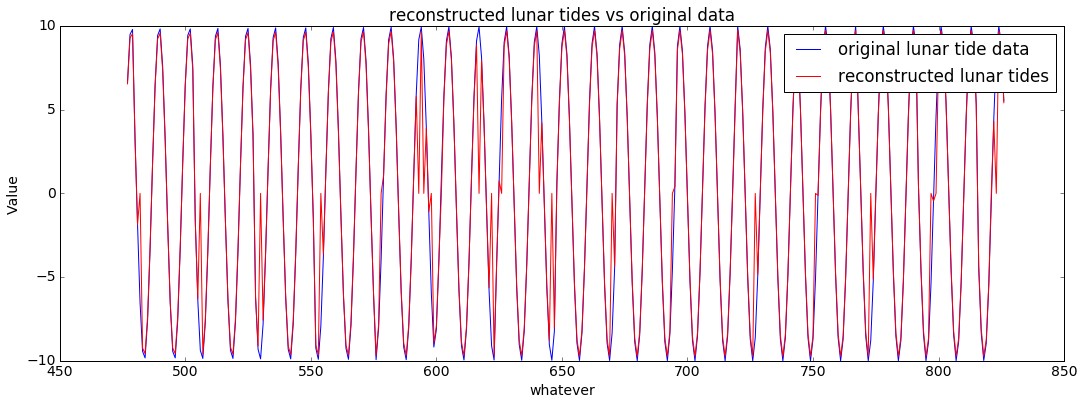

In [20]:
### This cell run with remove_solar returning just the 1D difference array

# Bin by solar local time
means1T = bin_by_solar(data1T, '0bg_CACP')

# Subtract the averages according to solar local time
nosol1T = remove_solar(data1T, '0bg_CACP_slt_bin.txt')

compare_with_plot(nosol1T, data1L[:,6])

[  1.20000000e+01   1.90328060e+01  -1.80000000e+02   2.45738850e+06
   0.00000000e+00   1.69671940e+01   1.42690527e+00  -8.32529473e+00]


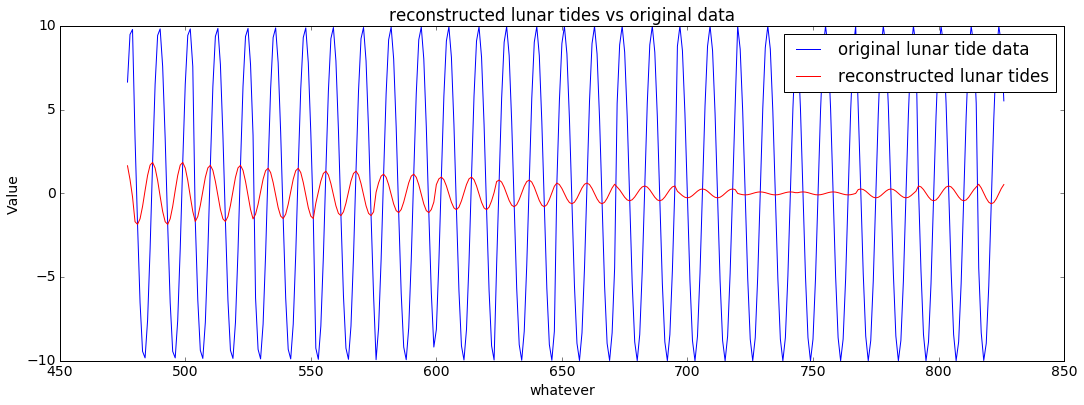

In [45]:
### This cell run with remove_solar returning a reconstucted array

# Bin by solar local time
means1T = bin_by_solar(data1T, '0bg_CACP')

# Subtract the averages according to solar local time
nosol1T = remove_solar(data1T, '0bg_CACP_slt_bin.txt')

print(nosol1T[0,:])

compare_with_plot(nosol1T[:,6], data1L[:,6])

In [27]:
np.savetxt('EXAMPLE.txt', nosol1T, fmt='%.4f')

11:19 am 

Trying again after doing some scratch work and fixing things.

[      12.               19.03280601     -180.          2457388.5               0.
       16.96719399        1.42690527]


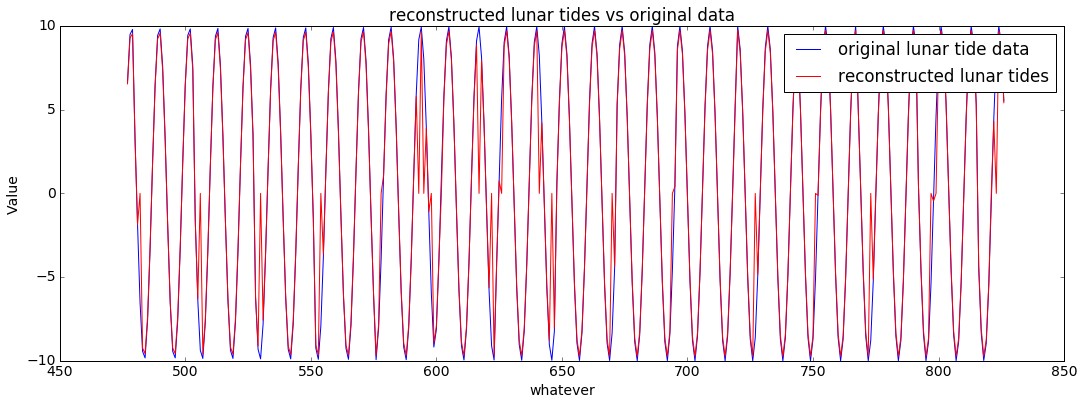

In [52]:
### This cell run with remove_solar returning a reconstucted array
np.set_printoptions(suppress=True)
# Bin by solar local time
means1T = bin_by_solar(data1T, '0bg_CACP')

# Subtract the averages according to solar local time
nosol1T = remove_solar(data1T, '0bg_CACP_slt_bin.txt')

compare_with_plot(nosol1T[:,6], data1L[:,6])

Okay there we go, fixed that at least. Astrid suggested that using a smaller time window might get rid of the weird spikes. Also, I do want to keep working in the notebook actually, so I'm going to make a cell at the top that contains the master copies.

## Trying different time step (15 minutes instead of hour)

/home/emc/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:155: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


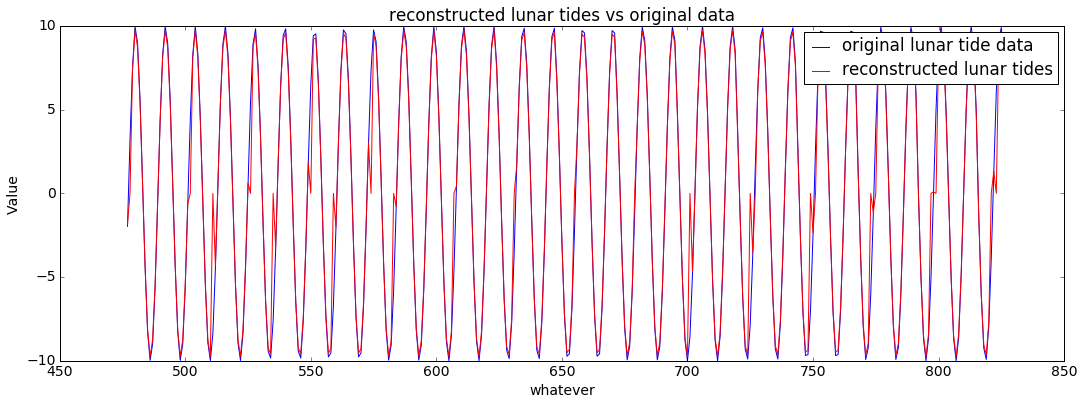

In [33]:
#============================================================================#
# Generate SW2 data
# Background = 0
# Constant amplitude and phase
#============================================================================#
data1S = generate_tides('2016-01-01', '2016-03-31', amps=[0,10,10], phase='C',
                        dt=0.25, nRange=[2], sRange=[2], filename='SW2_scenario1.txt', 
                        component='solar')

#============================================================================#
# Generate M2 data
# Background = 0
# Constant amplitude and phase
#============================================================================#
data1L = generate_tides('2016-01-01', '2016-03-31', amps=[0,10,10], phase='C',
                        dt=0.25, nRange=[2], sRange=[2], filename='M2_scenario1.txt', 
                        component='lunar')

#============================================================================#
# Generate total data
# Background = 0
# Constant amplitude and phase
#============================================================================#
data1T = generate_tides('2016-01-01', '2016-03-31', amps=[0,10,10], phase='C',
                        dt=0.25, nRange=[2], sRange=[2], filename='TT_scenario1.txt', 
                        component='s+l')

# Bin by solar local time
means1T = bin_by_solar(data1T, '1T')

# Subtract the averages according to solar local time
nosol1T = remove_solar(data1T, '1T_slt_bin.txt')

compare_with_plot(nosol1T[:,6], data1L[:,6])

12:05 pm 

Aha! Finally it ran. It does indeed look better after increasing the time resolution. I should take care of the integer problem after lunch.